In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import batman
from astropy.io import fits
import spiderman as sp
from astropy import units as u
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook


import sys
sys.path.insert(1, '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis')
import RECTE
import fitting_fns_template as fit_fns

from scipy.optimize import curve_fit

Options = 'OE_order1'
reload(fit_fns)

looking for spidermanrc file at /Users/s.baratuva.nl/.spidermanrc
no spidermanrc file detected


<module 'fitting_fns_template' from 'fitting_fns_template.pyc'>

Let's first load the data and put them into some handy arrays.

In [5]:
fname,direction=np.genfromtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/Data/input_image.lis',usecols=(0,3),dtype=str,unpack=True)
spectra_dir = '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'
#Spectra_files = glob.glob(spectra_dir + '*q_spec.txt')
import os
import shutil
filelist=np.array([])
#print (direction)
for file in os.listdir(spectra_dir):
    if ( file.endswith("q_spec.txt")):
        #print(os.path.join("/mydir", file))
        filelist=np.append(filelist,file)
#print (fname[0]+'_spec.txt',filelist)
files=np.array([])
for i in range (len(fname)):
    files=np.append(files,fname[i]+'_spec.txt')
#print (files)
#print (filelist)
for i in range(len(filelist)):
    temp=direction[np.where(files==filelist[i])[0]][0]
#    print (temp)
    print (i)
    if (temp=='reverse'):
        shutil.copy(spectra_dir+filelist[i],spectra_dir+'reverse')
        ext=filelist[i].split('spec.txt')[0]
        ext=ext+'red.fits'
        shutil.copy(spectra_dir+ext,spectra_dir+'reverse')
    else:
        shutil.copy(spectra_dir+filelist[i],spectra_dir+'forward')
        ext=filelist[i].split('spec.txt')[0]
        ext=ext+'red.fits'
        shutil.copy(spectra_dir+ext,spectra_dir+'forward')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [6]:
x='avs_spec.txt'
x.split('_spec.txt')[0]

'avs'

In [7]:
spectra_dir = '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'
#Spectra_files = glob.glob(spectra_dir + '*.fits')
#print (Spectra_files)
Spectra_files=np.array([])
#print (direction)
for file in os.listdir(spectra_dir):
    if ( file.endswith("q_spec.txt")):
        #print(os.path.join("/mydir", file))
        Spectra_files=np.append(Spectra_files,spectra_dir+file)
Red_fits_files = []
imagesize = 165  #FWHM of effectivly illuminated CCD surface.
for s in Spectra_files:
#     Red_fits_files.append(spectra_dir + s.split('spec.txt')[0] + 'red.fits')
    Red_fits_files.append(spectra_dir + s.split(spectra_dir)[1].split('spec.txt')[0] + 'red.fits')
print (Red_fits_files)

['/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie9301btq_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1c5q_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93h1goq_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93f1fbq_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93c1dfq_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1ciq_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93d1ebq_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93g1fqq_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93b1crq_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93d1e3q_red.fits', '/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie9301byq_red.fits'

In [8]:
Flux = []
Error = []
Times = []
Forward = []
Names = []
exptime1 = fits.open(Red_fits_files[0], ignore_missing_end=True)[0].header['EXPTIME']

for j,spectrum in enumerate(Spectra_files):
    s = np.loadtxt(spectrum, skiprows=2).T
    Name = spectrum.replace(spectra_dir, '')
    Names.append(Name.split('_spec')[0])
    F = fits.open(Red_fits_files[j], ignore_missing_end=True)
    exptime = F[0].header['EXPTIME']
    if exptime != exptime1: 
        print "ERROR: not every exposure has the same exposure time."
    Flux.append(s[1] / exptime)
    Error.append(s[2] / exptime)
    if F[0].header['POSTARG2'] >= 0:
        Forward.append(False)
    else:
        Forward.append(True)
    with open(spectrum, 'r') as g:
        for i,lines in enumerate(g):
            if i == 1:
                Times.append(float(lines.split()[1]))
    
    
Times_org = Times
print (Times_org)
Wave = np.array(s[0])
Flux = np.array(Flux)
Error = np.array(Error)
Times = (np.array(Times) - min(Times))
Forward = np.array(Forward)

df = pd.DataFrame(data=Flux, 
              index=np.arange(len(Times)),  
              columns = Wave)
df['Times'] = Times 
df['Names'] = Names
df['Forward'] = Forward

df_err= pd.DataFrame(data=Error, 
              index=np.arange(len(Times)), 
              columns = Wave)
df_err['Times'] = Times
df_err['Forward'] = Forward
df_err['Names'] = Names

df_sorted = df.sort_values(by=['Times'])
df_sorted_err = df_err.sort_values(by=['Times'])
sorted_times = np.array(df_sorted['Times'])
print (sorted_times)
orb=1
j=0
j0=j
for i in range(len(sorted_times)-1):
    if ((sorted_times[i+1]-sorted_times[i])<0.01):
        j=j+1
    else:
        print (j0,j)
        print (orb)
        j0=j
        j=j+1
        orb=orb+1
print (j0,j)
print (orb)
print (len(sorted_times))

[2459118.75887, 2459118.81312, 2459119.29586, 2459119.15154, 2459118.9485, 2459118.82954, 2459119.02812, 2459119.20877, 2459118.87931, 2459119.01767, 2459118.76484, 2459119.35759, 2459118.8161, 2459118.89275, 2459119.27645, 2459119.09879, 2459118.74842, 2459119.14109, 2459118.82357, 2459119.2237, 2459119.14707, 2459119.35012, 2459119.0311, 2459118.75588, 2459119.02513, 2459118.88827, 2459119.15453, 2459119.2869, 2459119.09431, 2459118.81013, 2459118.82058, 2459118.74543, 2459118.95746, 2459119.27197, 2459119.14408, 2459119.08386, 2459119.34564, 2459119.22071, 2459119.02065, 2459119.3546, 2459119.0102, 2459118.8823, 2459119.0973, 2459118.90021, 2459119.1605, 2459119.27944, 2459118.81163, 2459119.15304, 2459119.29437, 2459119.08535, 2459119.36356, 2459118.76036, 2459118.96492, 2459119.20727, 2459119.02961, 2459118.94999, 2459118.82805, 2459118.8176, 2459118.89125, 2459119.27794, 2459118.8808, 2459119.01617, 2459119.35908, 2459119.0749, 2459119.2222, 2459118.74991, 2459118.95447, 2459119.

What does our spectrum look like?

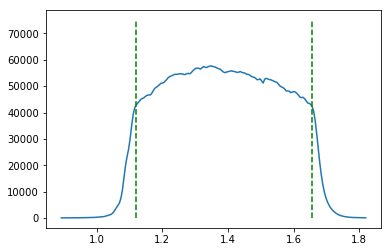

In [9]:
w1 = 1.12
w2 = 1.655
firstspec = df_sorted[Wave].iloc[1]
plt.plot(Wave, firstspec)
plt.plot([w1, w1], [np.min(firstspec), 1.3*np.max(firstspec)], '--', color='g')
plt.plot([w2, w2], [np.min(firstspec), 1.3*np.max(firstspec)], '--', color='g')
plt.show()

Now select the correct wavelengths for a white light curve. What does our white light curve look like?

Estimated photon noise: 42.896502988042975 ppm
4.3294834076436704e-05


<ErrorbarContainer object of 3 artists>

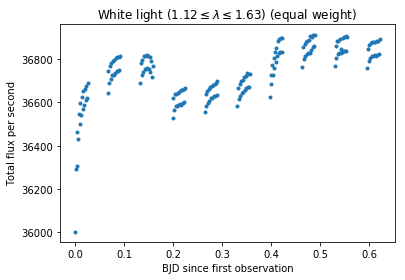

In [10]:
Wavelengthrange = (Wave > w1) & (Wave < w2)
Whitelight_LC, Whitelight_errors = fit_fns.calc_WL(df_sorted, df_sorted_err, Wave[Wavelengthrange]) #np.array(np.sum(df_sorted[Wave[Wavelengthrange]], axis=1))
Whitelight_LC, Whitelight_errors = Whitelight_LC  / imagesize, Whitelight_errors  / imagesize
#plt.scatter(sorted_times, Whitelight_LC)
plt.xlabel('BJD since first observation')
plt.ylabel('Total flux per second')
plt.title('White light ($1.12 \leq \lambda \leq 1.63$) (equal weight)')
#plt.show()
print "Estimated photon noise:", 1. / np.sqrt(np.mean(Whitelight_LC *imagesize * exptime)) * 1.e6, "ppm"
print np.mean(Whitelight_errors)/ np.mean(Whitelight_LC)
#for i in range(len(Whitelight_LC)):
#    temp=1./np.sqrt((Whitelight_LC[i] *imagesize * exptime)) * 1.e6
#    print (temp)
t,x_shift,x_shift_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/xshift_full.txt',unpack=True)
#Whitelight_LC=Whitelight_LC/(1+x_shift)
#plt.scatter(sorted_times, Whitelight_LC)
plt.errorbar(sorted_times,Whitelight_LC,yerr=Whitelight_errors,ls='none',marker='.')
#plt.savefig ('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_whitelc_delx.pdf',format='pdf')

(180, 180)


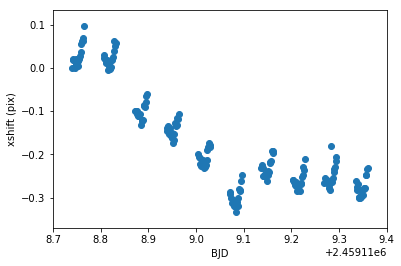

In [11]:
t,x_shift,x_shift_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/xshift_full.txt',unpack=True)

print (len(x_shift),len(Whitelight_LC))
plt.scatter(t,x_shift)
#plt.ylim(36400,37000)
plt.xlabel('BJD')
plt.ylabel('xshift (pix)')
plt.savefig ('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_xshift.pdf',format='pdf')

Now we need to divide our data into orbits.

In [12]:
#Define what the first, second, third, forth, fifth and sixth orbit are
Fir = np.arange(0,18)
Sec = np.arange(18,36)
Thi = np.arange(36,54)
For = np.arange(54,72)
Fif =np.arange(72,90)
Six = np.arange(90,108)
Sev = np.arange(108,126)
Eig = np.arange(126,144)
Nin = np.arange(144,162)
Ten = np.arange(162,180)
#print (Fir,Sec)

Ex_Fir_orbit = np.concatenate((Sec, Thi, For, Fif, Six,Sev,Eig,Nin,Ten))

Orbits = [Fir, Sec, Thi, For, Fif, Six,Sev,Eig,Nin,Ten]
Orbit_times = []
for i,o in enumerate(Orbits):
    Orbit_start = sorted_times[o[0]] - 1.e-6
    if i < len(Orbits) - 1:
        Orbit_end = sorted_times[Orbits[i+1][0]] - 1.e-6
    else:
        Orbit_end = sorted_times[-1] + 1.e-6
    Orbit_times.append([Orbit_start, Orbit_end])
    
    
#Which orbits are out of transit and could be used for a divide-out-of-transit?
Out_of_transit = np.concatenate((  Sec,Eig,Nin,Ten))
excl_First = np.concatenate(( Sec,Thi, For, Fif, Six,Sev,Eig,Nin,Ten))


Forwardscanned = np.array(df_sorted['Forward'] == True)

df_F = df_sorted[Forwardscanned]
df_F_err = df_sorted_err[Forwardscanned]
df_R = df_sorted[~Forwardscanned]
df_R_err = df_sorted_err[~Forwardscanned]


Out_of_transit_F = []
Out_of_transit_R = []
Excl_First = np.zeros(len(sorted_times), dtype=bool)
for i in np.arange(len(sorted_times)):
    if Forwardscanned[i] and i in Out_of_transit and i not in Fir:
        Out_of_transit_F.append(i)
    if not Forwardscanned[i] and i in Out_of_transit and i not in Fir:
        Out_of_transit_R.append(i)
    if i in excl_First:
        Excl_First[i] = True
        
Out_of_transit_F = np.array(Out_of_transit_F)
Out_of_transit_R = np.array(Out_of_transit_R)
#print (Out_of_transit_R ,Out_of_transit_F )
#print ((sorted_times[Excl_First]))
#print (sorted_times)

# Data visualization

Let's visualize the data with tags of image names

In [40]:
f_i = np.array(np.mean(df_sorted[Wave[Wavelengthrange]], axis=1) / imagesize)
f_i_err = np.array(np.mean(df_sorted_err[Wave[Wavelengthrange]], axis=1) / imagesize / np.sqrt(len(Wavelengthrange)))
#Let's normalize the data to have the data ~1 outside of transit
#f_i_err /= np.max(f_i)
#f_i /= np.max(f_i)
f_i_full, f_i_full_err = f_i.copy(), f_i_err.copy()
f_i_err /= np.max(f_i)
f_i /= np.max(f_i)

source = ColumnDataSource(data=dict(times=sorted_times,
                                    flux=f_i,
                                    labels=df_sorted['Names']))

output_notebook()
p = figure()
p.scatter(x='times', y='flux', source=source)
labels = LabelSet(x='times', y='flux', text='labels', level='glyph', x_offset=5, y_offset=5, source=source, render_mode='canvas', text_font_size='8px')
p.add_layout(labels)
show(p)

Loading BokehJS ...

# Fitting with a ramp model

## White light fitting

Let's fit a white light curve to the data

In [13]:
Planet_LC = fit_fns.Planet('HD209458')
print (Planet_LC)

<fitting_fns_template.Planet instance at 0x7fa9f01606c8>


In [29]:
n0=len(Thi)-1
print (Thi[n0-3:])
print (Thi)

[58 59 60 61]
[38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 135
    # variables        = 14
    chi-square         = 2.8243e-06
    reduced chi-square = 2.3342e-08
    Akaike info crit   = -2359.13867
    Bayesian info crit = -2318.46483
[[Variables]]
    depth_F:                  0.00403428 +/- 6.7506e-05 (1.67%) (init = 0.0016)
    depth_R:                  0.00406446 +/- 6.8288e-05 (1.68%) (init = 0.0016)
    Mid_transit_time_offset:  0.02196897 +/- 2.2461e-04 (1.02%) (init = 0)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.1561563 +/- 0.08025858 (0.30%) (init = 30.06)
    u1:                       0.63385435 +/- 0.03165880 (4.99%) (init = 0.46)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.01342983 +/- 5.9525e-04 (4.43%) (init = -0.003)
    V2_R:                     0.014608

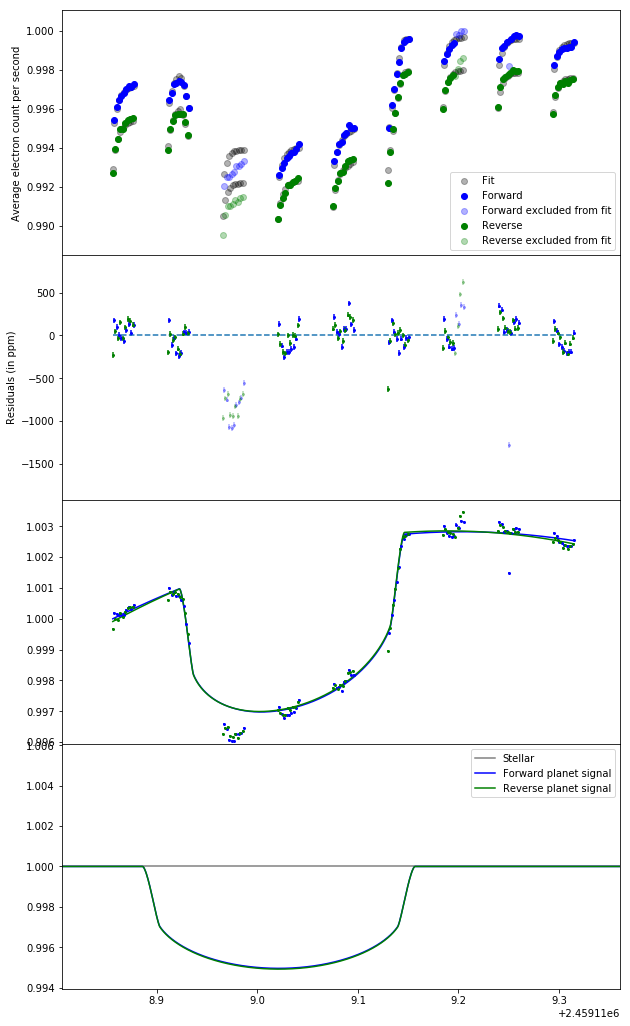

residuals on fitted data in ppm 337.5151294859321
Estimated photon noise: 42.88274129103094 ppm
6.750647356986602e-05


In [65]:
reload(fit_fns)

Planet_LC = fit_fns.Planet('V1298b')
t0 = Planet_LC.sp_params.t0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
t0 -= 2 * Planet_LC.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
#Excl_first[Sec] = False
n0=len(Thi)-1
#Excl_first[Thi[n0-3:]]=False
#Excl_first[[Nin[9]]]=False
#Excl_first[Eig]=False
#Excl_first[[Eig[16]]]=False
#Excl_first[[Six[17],Six[16],Six[15]]]=False
#print (Excl_first)
#print (Excl_first,Thi[n0-3:])
#Excl_first[17]=False
#Excl_first[18]=False
#Excl_first[19]=False
#for i in range (len(Sec)):
#    Excl_first[Sec[i]]=False
#Excl_first
#print (Excl_first)
#Excl_first=Excl_First
#print (len(sorted_times[Excl_first]))
exc_indices=[]
exc_indices.extend(Thi)

lis1=[118,119,120,121,122,123,124,125,135]
exc_indices.extend(lis1)
#exc_indices.append(135)
#exc_indices.append(161)
#exc_indices.append(160)
opt, err, chi2, bic = Planet_LC.Fit_with_exponential_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           f_i[Excl_first], f_i_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, fix_aRs=False,
                                                           nosat=True,
                                                           t0=t0, exptime = exptime,exc_indices=exc_indices,
                                                           Transit=True,sine=False,stel_pulse=False,polynomial=True)

fit_opt = opt[:-3]
LC_new = Planet_LC.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]




print "residuals on fitted data in ppm",np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i[Excl_first]**2.) / len(f_i[Excl_first])) *1.e6
print "Estimated photon noise:", 1. / np.sqrt(np.mean(f_i_full[Excl_first] * np.sum(Wavelengthrange) * imagesize * exptime)) * 1.e6, "ppm"

noise = np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i[Excl_first]**2.) / len(f_i[Excl_first])) *1.e6


print (err[0])
#Planet_LC = fit_fns.Planet('V1298b')
#print (Planet_LC.sp_params.pulse_alpha)


We need to fix some parameters that will be shared among each color bin: deltat and a/Rs 

In [31]:
import batman
params = batman.TransitParams()

In [79]:
deltat = opt[2]
aRs = opt[5]

## In bins (spectrum) 

Now we'll bin the white lightcurve into bins of 5 pixels (can be adjusted)

In [138]:
Nr_pixels = 5
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

cm = plt.cm.get_cmap('RdYlGn')
colors = cm(np.arange(N_bins)  * cm.N / N_bins)
print (bins)

[array([1.12084605, 1.12550243, 1.13015885, 1.13481531, 1.1394718 ]), array([1.14412834, 1.14878492, 1.15344153, 1.15809818, 1.16275487]), array([1.1674116 , 1.17206836, 1.17672516, 1.18138199, 1.18603886]), array([1.19069577, 1.19535271, 1.20000968, 1.20466669, 1.20932373]), array([1.2139808 , 1.2186379 , 1.22329504, 1.2279522 , 1.2326094 ]), array([1.23726663, 1.24192389, 1.24658118, 1.25123849, 1.25589584]), array([1.26055321, 1.26521061, 1.26986804, 1.27452549, 1.27918297]), array([1.28384048, 1.28849801, 1.29315557, 1.29781315, 1.30247076]), array([1.30712839, 1.31178604, 1.31644372, 1.32110142, 1.32575914]), array([1.33041688, 1.33507464, 1.33973242, 1.34439023, 1.34904805]), array([1.35370589, 1.35836375, 1.36302163, 1.36767953, 1.37233744]), array([1.37699538, 1.38165332, 1.38631129, 1.39096927, 1.39562726]), array([1.40028527, 1.4049433 , 1.40960134, 1.41425939, 1.41891745]), array([1.42357553, 1.42823362, 1.43289172, 1.43754983, 1.44220796]), array([1.44686609, 1.45152423, 1.

In [32]:
reload(fit_fns)
Planet_LC_multi = fit_fns.Planet('HD209458')
t0 = Planet_LC_multi.sp_params.t0
while t0 < min(Times_org) + Planet_LC_multi.sp_params.per:
    t0 += Planet_LC_multi.sp_params.per
t0 -= 2 * Planet_LC_multi.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
#Excl_first[Sec]=False
n0=len(Thi)-1
Excl_first[Thi[n0-3:]]=False


RpRs2 = []
RpRs2_err = []
opt_cs = []
err_cs = []
noise = []
photonnoise = []



for i,wave_bin in enumerate(bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
    Binned_LC = Binned_LC / imagesize
    Binned_LC_err = Binned_LC_err / imagesize
    Binned_LC_full, Binned_LC_full_err = Binned_LC.copy(), Binned_LC_err.copy()
    Binned_LC_err /= np.max(Binned_LC)
    Binned_LC /= np.max(Binned_LC)
    opt_c, err_c, chi2_c, bic_c = Planet_LC_multi.Fit_with_exponential_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           Binned_LC[Excl_first], Binned_LC_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, 
                                                           nosat=True,
                                                           deltat=deltat, a=aRs, fix_aRs=True,
                                                           t0=t0, exptime = exptime, 
                                                           verbose=False,
                                                           Transit=True)
    RpRs2.append(opt_c[0])
    RpRs2_err.append(err_c[0])
    opt_cs.append(opt_c)
    err_cs.append(err_c)
    
    fit_opt = opt_c[:-3]
    LC_new = Planet_LC_multi.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]


    noise.append(np.sqrt(np.sum((Binned_LC[Excl_first] - LC_new)**2./ Binned_LC[Excl_first]**2.) / len(Binned_LC[Excl_first])) *1.e6)
    photonnoise.append(1. / np.sqrt(np.mean(Binned_LC_full[Excl_first] * len(wave_bin) * imagesize * exptime)) * 1.e6)


RpRs2 = np.array(RpRs2)
RpRs2_err = np.array(RpRs2_err)


print (RpRs2,RpRs2_err)



(array([0.01492853, 0.01488569, 0.01483178, 0.01479473, 0.01485366,
       0.01477947, 0.01477895, 0.01481455, 0.01476693, 0.01485259,
       0.0149539 , 0.01495457, 0.01498225, 0.01487374, 0.01495131,
       0.01485683, 0.01501417, 0.01487595, 0.01486351, 0.01483038,
       0.01482303, 0.01477002, 0.01477827]), array([4.16633018e-05, 4.25162737e-05, 4.81595693e-05, 4.08714958e-05,
       3.81070013e-05, 4.62017932e-05, 4.14778046e-05, 4.60812275e-05,
       4.53438766e-05, 3.91470804e-05, 4.02804777e-05, 4.90827558e-05,
       4.67306113e-05, 4.56346496e-05, 4.04417499e-05, 4.68404781e-05,
       5.40705562e-05, 5.03050276e-05, 4.59791566e-05, 5.20695140e-05,
       5.73610813e-05, 5.66837839e-05, 6.05729414e-05]))


In [103]:
reload(fit_fns)
Planet_LC_multi = fit_fns.Planet('V1298b')
t0 = Planet_LC_multi.sp_params.t0
while t0 < min(Times_org) + Planet_LC_multi.sp_params.per:
    t0 += Planet_LC_multi.sp_params.per
t0 -= 2 * Planet_LC_multi.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False


RpRs2 = []
RpRs2_err = []
opt_cs = []
err_cs = []
noise = []
photonnoise = []



for i,wave_bin in enumerate(bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
    Binned_LC = Binned_LC / imagesize
    Binned_LC_err = Binned_LC_err / imagesize
    Binned_LC_full, Binned_LC_full_err = Binned_LC.copy(), Binned_LC_err.copy()
    Binned_LC_err /= np.max(Binned_LC)
    Binned_LC /= np.max(Binned_LC)
    opt_c, err_c, chi2_c, bic_c = Planet_LC_multi.Fit_with_exponential_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           Binned_LC[Excl_first], Binned_LC_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, 
                                                           nosat=True,
                                                           deltat=deltat, a=aRs, fix_aRs=True,
                                                           t0=t0, exptime = exptime, 
                                                           verbose=False,
                                                           Transit=True,stel_pulse=True,fix_pulse_amp=True,puls_amp=0.48)
    RpRs2.append(opt_c[0])
    RpRs2_err.append(err_c[0])
    opt_cs.append(opt_c)
    err_cs.append(err_c)
    
    fit_opt = opt_c[:-3]
'''
    LC_new = Planet_LC_multi.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]


    noise.append(np.sqrt(np.sum((Binned_LC[Excl_first] - LC_new)**2./ Binned_LC[Excl_first]**2.) / len(Binned_LC[Excl_first])) *1.e6)
    photonnoise.append(1. / np.sqrt(np.mean(Binned_LC_full[Excl_first] * len(wave_bin) * imagesize * exptime)) * 1.e6)'''


RpRs2 = np.array(RpRs2)
RpRs2_err = np.array(RpRs2_err)


print (RpRs2)
print (RpRs2_err)




[0.00725054 0.00518064 0.00695796 0.00585146 0.00566315 0.00416765
 0.00435041 0.00543923 0.00418966 0.00441552 0.00437956 0.00444886
 0.00461046 0.00471358 0.00426475 0.00292036 0.00418546 0.00439467
 0.00258483 0.00279282 0.00430269 0.00250009 0.00131779]
[0.00107652 0.00036316 0.00098246 0.00058647 0.0005675  0.0001712
 0.00015247 0.00049718 0.00019156 0.00016315 0.00051513 0.00048604
 0.00016579 0.00026996 0.00046561 0.00087699 0.00014948 0.00031252
 0.00096929 0.00085141 0.00028125 0.00091984 0.00134391]


(23, 23)
(23, 23)


<ErrorbarContainer object of 3 artists>

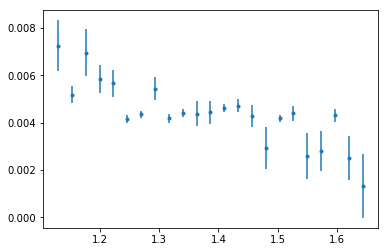

In [104]:
r_err=RpRs2_err[np.where(RpRs2_err!=None)[0]]
r=RpRs2[np.where(RpRs2_err!=None)[0]]
print (len(bins_avg_wave),len(RpRs2))
wave_bin=np.array([])
for i in range(len(np.where(RpRs2_err!=None)[0])):
    wave_bin=np.append(wave_bin,bins_avg_wave[i])
print (len(wave_bin),len(r))
#print (bins_)
#wave_bins=bins_avg_wave[np.where(RpRs2_err!=None)[0]]
plt.errorbar(wave_bin,r,r_err,ls='none',marker='.')
#plt.plot(bins_avg_wave,RpRs2,ls='none',marker='.')

23


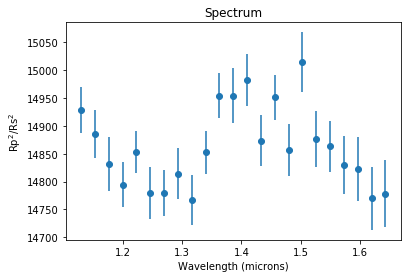

In [33]:
#You can load in a previous spectrum:
#base_wave, base, base_err = np.genfromtxt('KELT-9b_spectrum.txt').T
#if you have Forward and reverse scanned data you can do:
#eds_total, eds_total_err = fit_fns.arithmic_mean(np.array([RpRs_c_F, RpRs_c_R]), 
#                                                 np.array([RpRs_c_F_err, RpRs_c_R_err]), 
#                                                 axis=0, weighted=True)


#plt.errorbar(bins_avg_wave, eds_total, eds_total_err, fmt='o')
#plt.errorbar(base_wave, base, base_err, fmt='o', color='k', alpha=0.3)

#But now we only do a forward scanned spectrum:
plt.errorbar(bins_avg_wave, RpRs2*1e6, RpRs2_err*1e6, fmt='o')

plt.title('Spectrum')
plt.ylabel('Rp$^2$/Rs$^2$')
plt.xlabel('Wavelength (microns)')
#plt.savefig('HD209_transmission_spectra_bob.pdf',format='pdf')
print (len(RpRs2))

# Fitting with an RECTE model

We can also try fitting with an RECTE model (Zhou et al. 2017). This enables us to also fit for the first orbit (this could be important for establishing the baseline).

## Fitting the white lightcurve 

This time we'll exclude the last few points of the third orbit. We do this by adding the exc_indices parameter. These points are still plot, but they aren't used for fitting.

In [28]:
reload(fit_fns)
data_xshift=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/xshift_full.txt',usecols=(1),unpack=True)
Planet_LC = fit_fns.Planet('V1298b')
t0 = Planet_LC.sp_params.t0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
t0 -= 2 * Planet_LC.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
#Excl_first[Fir] = False
#n0=len(Thi)-1
#Excl_first[Thi[n0-3:]]=False
opt, err, chi2, bic = Planet_LC.Fit_with_recte_lmfit(sorted_times + min(Times_org), 
                                                           f_i_full, f_i_full_err, 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned, data_xshift, 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, fix_aRs=False,
                                                           nosat=True,
                                                           t0=t0, exptime = exptime, 
                                                           
                                                           Transit=True,stel_pulse=False,polynomial=True)

fit_opt = opt[:-3]
LC_new = Planet_LC.func(sorted_times + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array,
                                                                          exptime=exptime,
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]




print "residuals on fitted data in ppm",np.sqrt(np.sum((f_i_full - LC_new)**2./ f_i_full**2.) / len(f_i_full)) *1.e6
print "Estimated photon noise:", 1. / np.sqrt(np.mean(f_i_full * np.sum(Wavelengthrange) * imagesize * exptime)) * 1.e6, "ppm"

noise = np.sqrt(np.sum((f_i - LC_new)**2./ f_i_full**2.) / len(f_i_full)) *1.e6
print (bic)







Fitting a transit


RECTE.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  obsCounts[i] = f_i * exptime - dE1_s - dE1_f


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 180
    # variables        = 17
    chi-square         = 3.10110805
    reduced chi-square = 0.01902520
    Akaike info crit   = -697.015526
    Bayesian info crit = -642.735260
[[Variables]]
    depth_F:                  0.00516819 +/- 1.7644e-04 (3.41%) (init = 0.0015)
    depth_R:                  0.00528286 +/- 1.7607e-04 (3.33%) (init = 0.0015)
    Mid_transit_time_offset:  0.02240796 +/- 4.8165e-04 (2.15%) (init = 0)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.2105959 +/- 0.16955392 (0.62%) (init = 30.06)
    u1:                       0.51581934 +/- 0.07465065 (14.47%) (init = 0.46)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.04937940 +/- 0.00351927 (7.13%) (init = -0.003)
    V2_R:                     0.05346776 +/- 0.00342453

TypeError: Func_recte_transit() takes at least 34 arguments (37 given)

However, sometimes even RECTE won't fit that first orbit. So, you also simply remove that first orbit. RECTE will still work!

2457067.04929
86
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 135, 118, 119, 120, 121, 122, 123, 124, 125]
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 13
    # data points      = 135
    # variables        = 17
    chi-square         = 1.6852e-06
    reduced chi-square = 1.4281e-08
    Akaike info crit   = -2422.85268
    Bayesian info crit = -2373.46300
[[Variables]]
    depth_F:                  0.00391020 +/- 6.2750e-05 (1.60%) (init = 0.0015)
    depth_R:                  0.00399014 +/- 6.2421e-05 (1.56%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 +/- 1.8362e-04 (0.98%) (init = 0)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.3738816 +/- 0.06175387 (0.23%) (init = 30.06)
    u1:                       0.54929970 +/- 0.02887573 (5.26%) (init = 0.46)
    u2:                       0 (fixed)
    Phase_offset:       

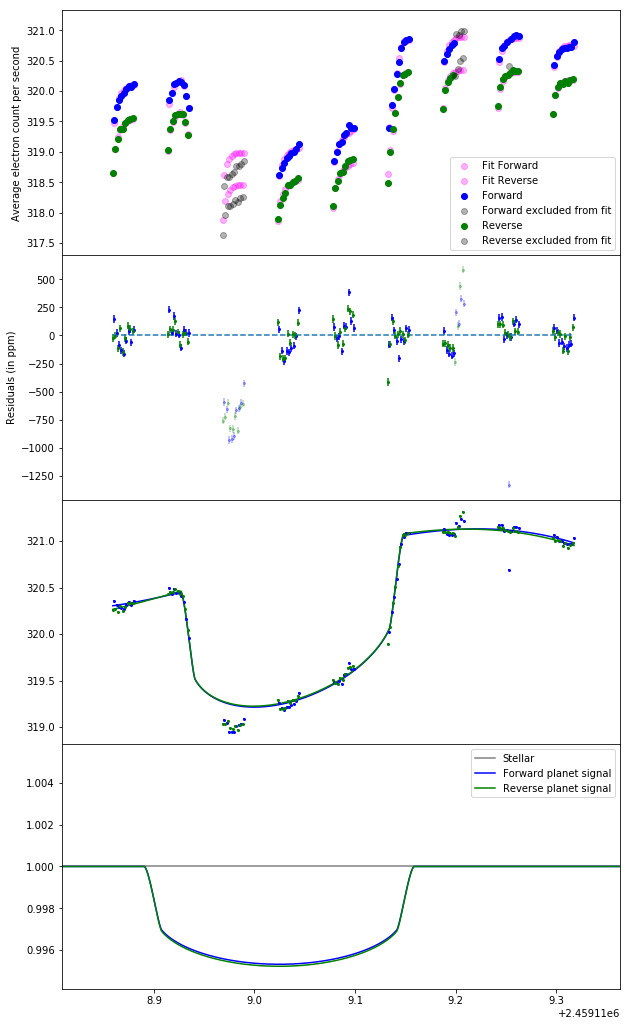

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[0.0039102011

In [41]:
reload(fit_fns)
data_xshift=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/xshift_full.txt',usecols=(1),unpack=True)
Planet_LC = fit_fns.Planet('V1298b')
t0 = Planet_LC.sp_params.t0
print (t0)
count=0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
    count=count+1
t0 -= 2 * Planet_LC.sp_params.per
print (count)
Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
#Excl_first[[Nin[8],Nin[9],Nin[10]]]=False
#Excl_first[[Nin[9]]]=False
#Excl_first[Nin]=False
#print (Thi)
n0=len(Thi)-1
#print (Thi[n0-3:])
#Excl_first[Thi[n0-3:]]=False
#Excl_first[Sec]=False
#Excl_first[For]=False
#print (Planet_LC.sp_params.rp)
exc_indices=[]
#exc_indices.extend(Fir)
#exc_indices.extend(Sec)
#exc_indices.extend(For)
#exc_indices.extend(Fif)
#exc_indices.extend(Six)
exc_indices.extend(Thi)
#exc_indices.extend(Sev)
#exc_indices.append(13)
exc_indices.append(135)
#exc_indices.append(161)
#exc_indices.append(160)
#exc_indices.append(69)
#exc_indices.append(71)
#exc_indices.append(85)
lis1=[118,119,120,121,122,123,124,125]
exc_indices.extend(lis1)
print (exc_indices)
opt, err, chi2, bic,out,eclipse_LC,Res,Error,Expected = Planet_LC.Fit_with_recte_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           f_i_full[Excl_first], f_i_full_err[Excl_first], 
                                                           np.array(Orbit_times)[1:] + min(Times_org), 
                                                           Forwardscanned[Excl_first],data_xshift[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, fix_aRs=False,
                                                           nosat=True,
                                                           t0=t0, exptime = exptime, exc_indices=exc_indices,c_xshift=0.0,
                                                           Transit=True,polynomial=True,fitting_method='least_squares',stel_pulse=False,sine=False,vary_cxshift=False,
                                                           fit_transit=True,jitter=False,separate_depth=True)
fit_opt = opt[:-3]
print (Planet_LC.exc_array)
'''
LC_new = Planet_LC.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array,
                                                                          exptime=exptime,
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]




print "residuals on fitted data in ppm",np.sqrt(np.sum((/Users/s.baratuva.nl/Desktop/PhD/f_i_full[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6
print "Estimated photon noise:", 1. / np.sqrt(np.mean(f_i_full[Excl_first] * np.sum(Wavelengthrange) * imagesize * exptime)) * 1.e6, "ppm"

noise_g_F = np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6
noise_g_R = np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6





'''
print (opt)
print (bic)
#print (Planet_LC.sp_params.pulse_Pi)
#print (np.sqrt(f_i_full)/f_i_full_err)
print (f_i_full_err[Fir])
print (t0+Planet_LC.sp_params.per+opt[2],np.sqrt(0.001**2+1.825e-4**2))


In [10]:
print (opt[5]*np.cos(opt[3]*np.pi/180.0))
print ((err[5]/opt[5])+np.tan(opt[3]*np.pi/180.0)*np.pi*err[3]/180.0)*(opt[5]*np.cos(opt[3]*np.pi/180.0))

0.2309869293408901
0.0005509523478616623


-0.0009389713815626106
5175.790747618209
{'nearest': None, 'xi': 0.3, 't_secondary': 2459107.3604327366, 'limb_dark': 'linear', 'n_layers': 5, 'thermal': False, 'T_s': 9600.0, 'T_n': 2556.0, 'inc': 89.517, 'a_abs': 0.1688, 'rp': 0.0628663110272838, 'per': 24.141106, 'u': [0.5548074794952161], 'fp': None, 'ecc': 0.087, 'grid': [[], [], [[]]], 'Hmag': 8.191, 'a': 27.40164991156351, 'delta_T': 2010.0, 'eclipse': True, 't0': 2459094.9021970145, 'brightness_type': 9, 'filter': False, 'stellar_model': 'blackbody', 'w': 85.0, 'Teq': 677.0, 'p_u1': 0, 'p_u2': 0}
(2459094.9021970145, 2459118.73963, 2459119.36074)


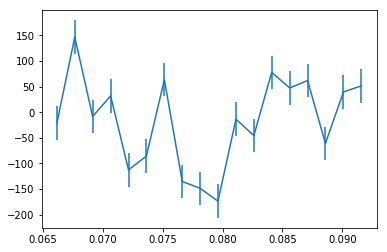

In [20]:
plt.errorbar(sorted_times[Excl_first][Fir],Res[Fir]*1e6,yerr=Error[Fif]*1e6)
print (np.min(Res[Thi]))
apas=(0.073)**2
Ts=4970
Tspot=(-1.0*np.min(Res[Thi])/apas +1)*Ts**4
Tspot=Tspot**(1.0/4)
print (Tspot)
print (vars(Planet_LC.sp_params))
print (t0,min(Times_org),max(Times_org))

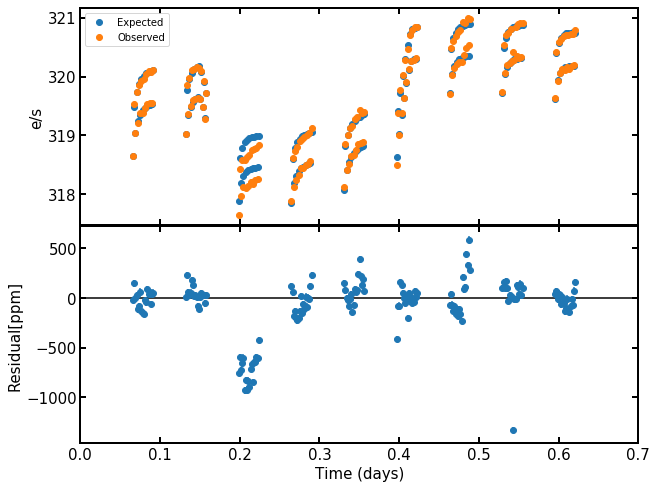

In [15]:
fig,axs=plt.subplots(2,1,figsize=(10,8),sharex=True)
inc_array=np.ones_like(sorted_times[Excl_first], dtype=bool)
inc_array[exc_indices]=False
axs[0].plot(sorted_times[Excl_first],Expected,ls='none',marker='o',label='Expected')
axs[0].plot(sorted_times[Excl_first],f_i_full[Excl_first],ls='none',marker='o',label='Observed')
axs[1].errorbar(sorted_times[Excl_first],Res*1e6,yerr=Error*1e6,ls='none',marker='o')
axs[1].hlines(0.0,0.0,1.0)
axs[1].set_xlim(0.0,0.7)
axs[0].set_ylabel('e/s',fontsize=15)
axs[1].set_ylabel('Residual[ppm]',fontsize=15)
axs[1].set_xlabel('Time (days)',fontsize=15)
axs[0].legend()
plt.subplots_adjust(hspace=0.005)
for i in range(2):
   # ax=axs[i]
    axs[i].tick_params('both',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
    for axis in ['top','bottom','left','right']:
        axs[i].spines[axis].set_linewidth(2.0)

In [15]:
from astropy.modeling import models
from astropy import units as u
from astropy.visualization import quantity_support
def blackbody(T):
    bb = models.BlackBody(temperature=T*u.K)
    wav = np.arange(1.12, 1.65,1000) * u.um
    flux = bb(wav)
    return flux
flux=blackbody(3000)

AttributeError: 'module' object has no attribute 'BlackBody'

In [137]:
reload(fit_fns)
data_xshift=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/xshift_full.txt',usecols=(1),unpack=True)
Planet_LC = fit_fns.Planet('V1298b')
t0 = Planet_LC.sp_params.t0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
t0 -= 2 * Planet_LC.sp_params.per

Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
#Excl_first[[Nin[8],Nin[9],Nin[10]]]=False
#Excl_first[[Nin[9]]]=False
#Excl_first[Nin]=False
#print (Thi)
n0=len(Thi)-1
#print (Thi[n0-3:])
#Excl_first[Thi[n0-3:]]=False
#Excl_first[Sec]=False
#Excl_first[For]=False
#print (Planet_LC.sp_params.rp)
exc_indices=[]
#exc_indices.extend(Fir)
#exc_indices.extend(Sec)
#exc_indices.extend(For)
#exc_indices.extend(Fif)
#exc_indices.extend(Six)
exc_indices.extend(Thi)
#exc_indices.extend(Sev)
#exc_indices.append(13)
exc_indices.append(135)
#exc_indices.append(161)
#exc_indices.append(160)
#exc_indices.append(69)
#exc_indices.append(71)
#exc_indices.append(85)
lis1=[118,119,120,121,122,123,124,125]
exc_indices.extend(lis1)
print (exc_indices)
#time,data_xshift[Excl_first],ecc, forward, Planet_LC.sp_params,orbit_times,inc_array,ex_time,
#                            u1,stel_flux_f,stel_flux_r,E0_s,Delta_Ef,V3_F,V3_R,V4_F,V4_R,V2_F,V2_R,E0_f,Delta_Es,
#                          depth_f,depth_r,t_mid,aRs,inc

def transit_model_recte(time,data_xshift,ecc, Forward, sp_params,orbit_times,Include,exptime, 
                        inc,stel_flux_f,stel_flux_r, V3_F,V3_R,V4_F,V4_R,V2_F,V2_R,
                        depth_f,depth_r,t_mid,aRs,E0_s,Delta_Ef,E0_f,Delta_Es,u1,sig_jitter
                        ):
    
    u2=0.0
    phi=0.0
    SatF=0.0
    V1_R=0.0
    V1_F=0.0
    c_xshift=0.0
    f0_F=stel_flux_f
    f0_R=stel_flux_r
    satellite_time=1e6
    noexcl=False
  #  depth_r=depth_f
    model=fit_fns.Func_recte_transit(time,data_xshift,depth_f, depth_r, t_mid, inc, ecc, aRs, u1, u2, phi, V2_F, V2_R, f0_F, f0_R, E0_s, E0_f, Delta_Es,
              Delta_Ef, SatF, V1_F, V1_R, V3_F, V3_R,V4_F,V4_R, c_xshift, Forward, sp_params, orbit_times, satellite_time, Include,
              exptime, noexcl, Stel_puls_phase=0., Stel_puls_amp=0., Harm_amp=0., fit=True)
    return model

def lnlike(theta,time,data,data_err,data_xshift,ecc, Forward, sp_params,orbit_times,Include,exptime,inc,stel_flux_f,stel_flux_r, V3_F,V3_R,V4_F,V4_R,V2_F,V2_R):
#     P,T,R=np.loadtxt('final_temp_pressure_profile.txt',unpack=True)
#     lmb=x
#     print 'theta',theta
 #    print (len(time),len(data_xshift),len(Forward),len(Include))
     chisq=-0.5*sum(((transit_model_recte(time,data_xshift,ecc, Forward, sp_params,orbit_times,Include,exptime,inc,stel_flux_f,stel_flux_r, V3_F,V3_R,V4_F,V4_R,V2_F,V2_R,*theta)-data[Include])**2)/(data_err[Include]**2+(theta[-1]*(eclipse_LC[Include]-1.0))**2))
#     print chisq
     return chisq

def lnprior(theta):
    theta0=[0.0036,0.0036,-0.2,22,1000,50,50,50,0.3,0.0]
    theta1=[0.0041,0.0041,0.2,28.5,1200,200,150,100,0.8,100.0]
    b=True
    for i in range (len(theta)):
        b=b*((theta[i]>theta0[i]) and (theta[i]<theta1[i]))
  #      print (b)
    if (b==1):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,time,data,data_err,data_xshift,ecc, Forward, sp_params,orbit_times,Include,exptime,inc,stel_flux_f,stel_flux_r, V3_F,V3_R,V4_F,V4_R,V2_F,V2_R):
    lp = lnprior(theta)
  #  print (lp)
    if (lp== -np.inf):
        
        return -np.inf
    else:
        return lnlike(theta,time,data,data_err,data_xshift,ecc, Forward, sp_params,orbit_times,Include,exptime,inc,stel_flux_f,stel_flux_r, V3_F,V3_R,V4_F,V4_R,V2_F,V2_R)  

[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 135, 118, 119, 120, 121, 122, 123, 124, 125]


In [17]:
#p0[10][1]=-0.05
#print (lnprior(p0[10]),p0[10print 
print (opt)
print (err)

[0.0038719944038794816, 0.003950754597072577, 0.01875852961663086, 89.517, 0.087, 27.40110336501817, 0.5550895669083666, 0.0, 0.0, 0.003977686459485008, 0.00660309813252435, 320.30415382695463, 319.7253845441297, 1176.6441007497297, 104.07065460232639, 77.67891394761848, 100.2265211541285, 0.0, 0.0, 0.0, 0.02186314034228792, 0.013426086157205036, -0.03995617383923711, -0.03310495083456229, 0.0, 0.0, 0.0, 0.0]
[6.282535408966142e-05, 6.246209894441707e-05, 0.00018224241058367429, 0, 0, 0.06535738743328272, 0.02861323782229122, 0, 0, 0.001601391593511094, 0.001558481431693963, 0.021957751983562746, 0.021360348493923976, 20.933187968203143, 6.500735661864916, 7.372835718232177, 2.411959894129523, 0, 0, 0, 0.006199676704799923, 0.006024881236255742, 0.006523218545143198, 0.006354124827211911, 0, 0, 0, 0]


In [ ]:
depth_f,t_mid,aRs,V2_F,V2_R,E0_f,Delta_Es,
                        V3_F,V3_R,V4_F,V4_R

In [138]:
ndim = 10
nwalkers =50
p0=[]
theta_val=[0.00387199,0.0039,0.018,27.4,1176,100,104,77,0.55,0.5]
theta_err=[0.0001,0.0001,0.01,0.001,20,10,20,10,0.1,0.1]
for i in range(nwalkers):
    f=np.array([]) 
  #  temp=[]
    for j in range (ndim):
        f=np.append(f,np.random.normal(theta_val[j],theta_err[j]))
 #   f4=np.random.uniform(0.0,0.1)
#    f4=np.random.uniform(-0.05,0.05)
#    f=np.array([f0,f1,f2,f3])
    p0.append(f)
    
    
    
data_xshift=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/xshift_full.txt',usecols=(1),unpack=True)
Planet_LC = fit_fns.Planet('V1298b')
t0 = Planet_LC.sp_params.t0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
t0 -= 2 * Planet_LC.sp_params.per

Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
#Excl_first[[Nin[8],Nin[9],Nin[10]]]=False
#Excl_first[[Nin[9]]]=False
#Excl_first[Nin]=False
#print (Thi)
n0=len(Thi)-1
#print (Thi[n0-3:])
#Excl_first[Thi[n0-3:]]=False
#Excl_first[Sec]=False
#Excl_first[For]=False
#print (Planet_LC.sp_params.rp)
exc_indices=[]
#exc_indices.extend(Fir)
#exc_indices.extend(Sec)
#exc_indices.extend(For)
#exc_indices.extend(Fif)
#exc_indices.extend(Six)
exc_indices.extend(Thi)
#exc_indices.extend(Sev)
#exc_indices.append(13)
exc_indices.append(135)
#exc_indices.append(161)
#exc_indices.append(160)
#exc_indices.append(69)
#exc_indices.append(71)
#exc_indices.append(85)
lis1=[118,119,120,121,122,123,124,125]
exc_indices.extend(lis1)


data, data_err=f_i_full[Excl_first], f_i_full_err[Excl_first]
orbit_times,forward,xshift=np.array(Orbit_times)[1:] + min(Times_org), Forwardscanned[Excl_first],data_xshift[Excl_first]
time=sorted_times[Excl_first] + min(Times_org)
ecc=Planet_LC.sp_params.ecc
inc=Planet_LC.sp_params.inc
ex_time=exptime
inc_array=np.ones_like(time, dtype=bool)
inc_array[exc_indices]=False
u1,stel_flux_f,stel_flux_r,E0_s,Delta_Ef=0.555,320.30415382695463, 319.7253845441297,1176.64410,100.226
V3_F,V3_R,V4_F,V4_R=0.02186314034228792, 0.013426086157205036, -0.03995617383923711, -0.03310495083456229
V2_F,V2_R,E0_f,Delta_Es=0.00397769,0.00660310,104.070655,77.6789139
#print (forward,len(forward),len(inc_array),len(orbit_times),len(data))
print (len(p0[0]))

10


In [ ]:
stel_flux_f,stel_flux_r, V3_F,V3_R,V4_F,V4_R,V2_F,V2_R

In [139]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time,data,data_err,xshift,ecc, forward, Planet_LC.sp_params,orbit_times,inc_array,ex_time,inc,stel_flux_f,stel_flux_r, V3_F,V3_R,V4_F,V4_R,V2_F,V2_R),threads=8)



#print (len(time),len(data),len(data_err),len(xshift),ecc, len(forward), vars(Planet_LC.sp_params),len(orbit_times),len(inc_array),ex_time)

In [140]:
print("Running burn-in...")
p0, prob0, state0 = sampler.run_mcmc(p0,10000)
print p0
sampler.reset()

Running burn-in...
[[3.83693119e-03 3.84947531e-03 1.86655966e-02 2.63224093e+01
  1.17904912e+03 9.89485204e+01 1.03942086e+02 8.69397035e+01
  5.53842829e-01 8.52398861e+01]
 [3.90103308e-03 3.86877082e-03 1.86846108e-02 2.61681476e+01
  1.17749010e+03 9.89023303e+01 1.03419893e+02 8.76547090e+01
  7.66699809e-01 8.41138037e+01]
 [3.77413224e-03 3.69884640e-03 1.88567480e-02 2.62784045e+01
  1.17689900e+03 9.95712747e+01 1.04125952e+02 8.49521560e+01
  5.32398671e-01 7.42822164e+01]
 [3.98189848e-03 4.00996728e-03 1.86626100e-02 2.62179473e+01
  1.18295021e+03 9.88355625e+01 1.01443069e+02 8.28724433e+01
  7.43811999e-01 8.15435953e+01]
 [3.66670341e-03 3.68042177e-03 1.87355496e-02 2.62341153e+01
  1.17979151e+03 9.82366142e+01 1.05176849e+02 8.74238117e+01
  6.13442515e-01 8.79379828e+01]
 [3.93337997e-03 4.07907242e-03 1.86772808e-02 2.63911274e+01
  1.17452460e+03 9.91291022e+01 1.04626325e+02 8.46707954e+01
  4.82894442e-01 9.51964499e+01]
 [4.05163667e-03 3.66349406e-03 1.86045

In [141]:
print("Running production...")
pos, prob, state = sampler.run_mcmc(p0,10000)
print 'posterior',pos
samples = sampler.flatchain
print 'samples',samples
print 'prob',prob

Running production...
posterior [[3.98907106e-03 3.85543697e-03 1.86484275e-02 2.62325092e+01
  1.17836238e+03 9.84234980e+01 1.01273587e+02 8.60570658e+01
  7.21436071e-01 8.78741428e+01]
 [3.95320983e-03 3.87349442e-03 1.85620537e-02 2.62704754e+01
  1.17840271e+03 9.95389510e+01 1.03109593e+02 8.57476845e+01
  6.84815908e-01 9.53626602e+01]
 [3.84183773e-03 3.70155527e-03 1.87364755e-02 2.61267658e+01
  1.17775498e+03 1.00250682e+02 1.02641643e+02 8.69309041e+01
  7.65951527e-01 9.54957714e+01]
 [4.00989771e-03 3.60429545e-03 1.86646043e-02 2.61629734e+01
  1.17409469e+03 9.97991813e+01 1.03531477e+02 8.18736813e+01
  7.89361866e-01 9.95934894e+01]
 [3.94185346e-03 3.78735332e-03 1.87287960e-02 2.62623433e+01
  1.17551776e+03 9.84225484e+01 1.04101750e+02 8.79125518e+01
  6.59835064e-01 8.40721978e+01]
 [3.99369672e-03 3.99579612e-03 1.86683743e-02 2.63391791e+01
  1.17354720e+03 9.88944570e+01 1.04326529e+02 8.74102955e+01
  6.02215259e-01 9.77834705e+01]
 [3.79751866e-03 3.6727046

/Users/s.baratuva.nl/opt/anaconda3/envs/myenv2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


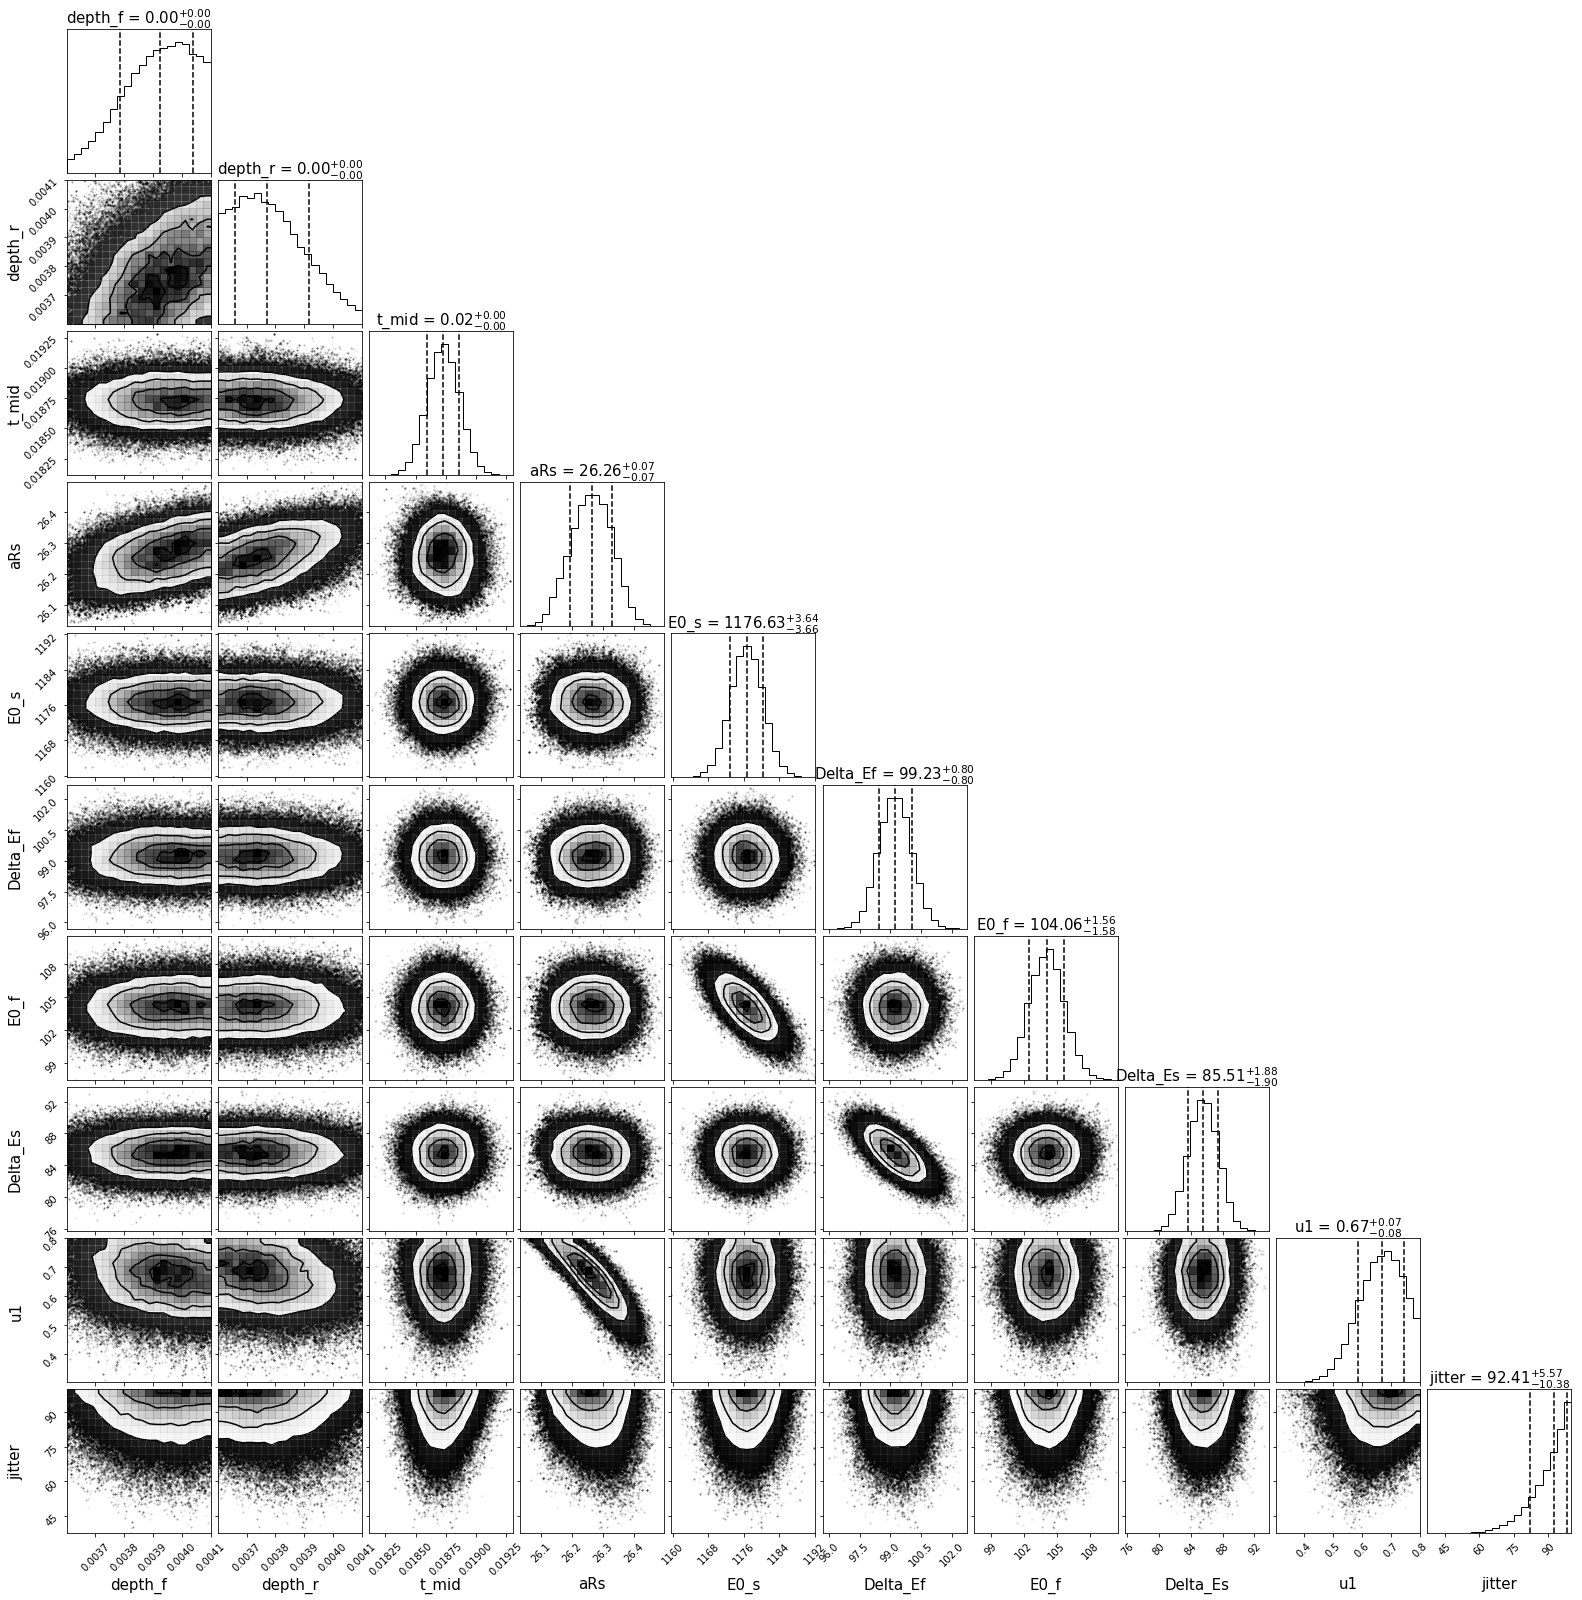

In [142]:
import corner
lab=['depth_f','depth_r','t_mid','aRs','E0_s','Delta_Ef','E0_f','Delta_Es','u1','jitter']
figure=corner.corner(samples,labels=lab,quantiles=[0.16,0.5,0.84],show_titles=True,title_kwargs={"fontsize": 15},label_kwargs={"fontsize": 15})
axes = np.array(figure.axes).reshape((ndim, ndim))
figure.show()

In [21]:
theta_final=[]
samples1=samples[50000:]
lab=['depth_f','depth_r','t_mid','aRs','E0_s','Delta_Ef','E0_f','Delta_Es','u1','stel_flux_f','stel_flux_r', 'V3_F','V3_R','V4_F','V4_R','V2_F','V2_R']
for i in range (ndim):
    q=np.quantile(samples1[:,i],[0.16,0.5,0.84])
    print (lab[i],q[1]  ,q[2]-q[1],q[1]-q[0])
    theta_final.append(q[1])
#fit= transit_model_recte(time,xshift,ecc, forward, Planet_LC.sp_params,orbit_times,inc_array,ex_time,
#                            u1,stel_flux_f,stel_flux_r,E0_s,Delta_Ef,V3_F,V3_R,V4_F,V4_R,V2_F,V2_R,E0_f,Delta_Es,*theta_final)

#plt.plot(time[inc_array],fit,ls='none',marker='.')
#plt.plot(time[inc_array],data[inc_array],ls='none',marker='.')
#print (26.45*np.cos(89.21*np.pi/180))
t_mid_offset=0.018758618941469973
t_mid_err= 4.45082955239165e-05
print (t0+Planet_LC.sp_params.per-t_mid_offset,np.sqrt((0.0018)**2+t_mid_err**2))

('depth_f', 0.0038477098351938892, 9.780065345836066e-05, 7.423442704065225e-05)
('depth_r', 0.003909120458618522, 0.0001029975451319106, 0.00010054788259207829)
('t_mid', 0.016316515662572174, 0.0077855189796718766, 0.006791393438744787)
('aRs', 27.399685610888366, 0.0009701657085265936, 0.0008527097534276606)
('E0_s', 1182.402987200304, 14.682292511529113, 23.798246893256874)
('Delta_Ef', 100.09244525515813, 8.897512894358087, 8.985646199104195)
('E0_f', 106.60464371879982, 14.2981244999568, 28.277366315745383)
('Delta_Es', 75.51898693130752, 10.514024888362911, 9.888679080356255)
('u1', 0.5573194772955274, 0.08404457469419813, 0.08893437717268704)
('stel_flux_f', 320.27286289679176, 1.0066048024634142, 0.6459373111918012)
('stel_flux_r', 319.45937194883874, 0.9910366090429079, 0.8580652378606146)
('V3_F', 0.020906498441229757, 0.0010953582189357942, 0.0008123366199570617)
('V3_R', 0.012720211416965837, 0.00120498156093732, 0.0005499659276514031)
('V4_F', -0.039248422128994535, 0.001

In [16]:
b=True
print (True*True*True)

1


(162, 162, 135)


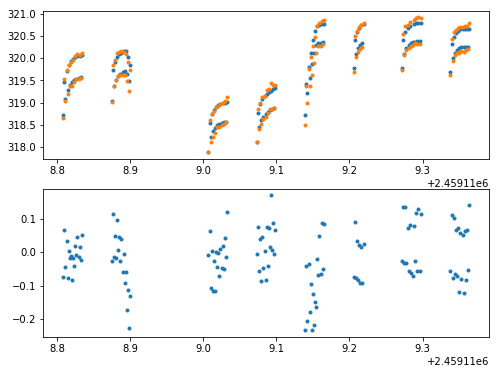

In [39]:
Planet_LC = fit_fns.Planet('V1298b')
time=sorted_times[Excl_first] + min(Times_org)
data_xshift=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/xshift_full.txt',usecols=(1),unpack=True)
ecc=Planet_LC.sp_params.ecc
#print (ecc)
orbit_times=np.array(Orbit_times)[1:] + min(Times_org)
forward=Forwardscanned[Excl_first]
#print (Forward,len(Forward))
inc_array=np.ones_like(time, dtype=bool)
inc_array[exc_indices]=False
ex_time=exptime
noexcl=False
depth_f=0.0038477
depth_r=0.0039091
t_mid=0.01875861
inc=89.57
aRs=27.401
u1=0.554978
V2_F=0.0038900
V2_R=0.0066049
stel_flux_f=320.27
stel_flux_r=319.7593
E0_s=1182.68
E0_f=106.05
Delta_Es=75.608
Delta_Ef=100.24
V3_F=0.02106
V3_R=0.0139
V4_F= -0.03924
V4_R= -0.03316
#V3_F,V3_R,V4_F,V4_R=0.02186314034228792, 0.020426086157205036, -0.03995617383923711, -0.03390495083456229
#V2_F,V2_R=0.00397769,0.00660310
model=transit_model_recte(time,data_xshift[Excl_first],ecc, forward, Planet_LC.sp_params,orbit_times,inc_array,ex_time, 
                        inc,
                        depth_f,depth_r,t_mid,aRs,E0_s,Delta_Ef,E0_f,Delta_Es,u1,
                        stel_flux_f,stel_flux_r, V3_F,V3_R,V4_F,V4_R,V2_F,V2_R)
import matplotlib.pyplot as plt
#plt.plot(time[inc_array],model,ls='none',marker='.')
#ln=lnprob(p0[3],time,data,data_err,data_xshift[Excl_first],ecc, Forward, Planet_LC.sp_params,orbit_times,inc_array,ex_time)
#print (ln)
print (len(time),len(data),len(model))
fig,axs=plt.subplots(2,1,figsize=(8,6))
axs[0].plot(time[inc_array],model,ls='none',marker='.')
axs[0].plot(time[inc_array],data[inc_array],ls='none',marker='.')
axs[1].plot(time[inc_array],data[inc_array]-model,ls='none',marker='.')

In [41]:
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23
from scipy.integrate import simps
def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity
def f(T,fspot):
    wav=np.arange(1.12e-6,1.65e-6,1e-8)
#    print (wav)
  #  I=np.array([])
#    for i in range (len(wav)):
        
    #I=np.append(I,planck(wav[i],T))
    I=planck(wav,T)
#    print (I)
    return simps(I,wav)-fspot
apas=(0.073)**2
Ts=4970
fspot=(-1*np.min(Res[Thi])/apas +1)*f(Ts,0)
#print (fspot,f(Ts,0),f(Ts+500,0),f(Ts-500,0))
print (f(Ts+500,fspot),f(Ts,fspot),f(Ts-500,fspot))
x=Ts+500
y=Ts-500
z=(x+y)/2.0
dc=10000
print (f(x,fspot),f(z,fspot),f(y,fspot))
#print (a,b,c)

while (dc>0.1):
    c0=z
    if ((f(x,fspot)*f(z,fspot)<0.0) and (f(z,fspot)*f(y,fspot))>0):
        y=z
        z=(x+y)/2.0
        dc=abs(z-c0)
     #   print (1)
    elif ((f(x,fspot)*f(z,fspot))>0.0 and (f(y,fspot)*f(z,fspot))<0.0):
        x=z
        z=(x+y)/2.0
        dc=abs(z-c0)
    #    print (2)
    else:
        dc=0.0
    print (z)
   # print (c,dc)
print (z)


(146853.19017035002, -318648.4268282119, -749636.6962880408)
(146853.19017035002, -318648.4268282119, -749636.6962880408)
5220.0
5345.0
5282.5
5313.75
5329.375
5321.5625
5317.65625
5315.703125
5316.6796875
5316.19140625
5315.94726562
5315.82519531
5315.76416016
5315.76416016


In [16]:

import batman
import numpy as np
import matplotlib as plt
def transit_model(time,t0,per,depth,aRs,inc,ecc,w,u1,c1,c2,t_mid):

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = t0                        #time of inferior conjunction
    params.per = per                       #orbital period
    params.rp = depth                       #planet radius (in units of stellar radii)
    params.a = aRs                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = ecc                       #eccentricity
    params.w = w                        #longitude of periastron (in degrees)
    params.limb_dark = "linear"        #limb darkening model
    params.u = [u1]      #limb darkening coefficients [u1, u2, u3, u4]

    t = time+t_mid  #times at which to calculate light curve
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params) 
    flux=flux*(c1+c2*(t-t[0]))
    return flux



def residual(pars,time,data,lc,lc_err,z,z_err):
        model=transit_model(time,pars['t0'].value,pars['per'].value,pars['depth'].value,pars['aRs'].value,
                       pars['inc'].value,pars['ecc'].value,pars['w'].value,pars['u1'].value,
                        pars['c1'].value,pars['c2'].value,pars['t_mid'].value)
        err=(lc_err/lc+(z_err/z))*data
        return (model-data)/(err)
    
    
#flux_f,t=transit_model(sorted_times[Excl_first][forward]+min(Times_org)+opt[2],t0,t_orb,depth_F,aRs,inc,ecc,w,u1)
'''
t0=Planet_LC.sp_params.t0
t_orb=Planet_LC.sp_params.per
depth_F=opt[0]
depth_R=opt[1]
aRs=opt[5]
inc=opt[3]
ecc=opt[4]
w=Planet_LC.sp_params.w
u1=opt[6]
forward=Planet_LC.Forward
flux_f=transit_model(sorted_times[Excl_first][forward]+min(Times_org)+opt[2],t0,t_orb,depth_F,aRs,inc,ecc,w,u1,150,0.0001)
flux_r=transit_model(sorted_times[Excl_first][~forward]+min(Times_org)+opt[2],t0,t_orb,depth_R,aRs,inc,ecc,w,u1,150,0.0001)

import matplotlib.pyplot as plt
plt.plot(t,flux_f,ls='none',marker='.')
plt.plot(t1,flux_r,ls='none',marker='.')

'''




"\nt0=Planet_LC.sp_params.t0\nt_orb=Planet_LC.sp_params.per\ndepth_F=opt[0]\ndepth_R=opt[1]\naRs=opt[5]\ninc=opt[3]\necc=opt[4]\nw=Planet_LC.sp_params.w\nu1=opt[6]\nforward=Planet_LC.Forward\nflux_f=transit_model(sorted_times[Excl_first][forward]+min(Times_org)+opt[2],t0,t_orb,depth_F,aRs,inc,ecc,w,u1,150,0.0001)\nflux_r=transit_model(sorted_times[Excl_first][~forward]+min(Times_org)+opt[2],t0,t_orb,depth_R,aRs,inc,ecc,w,u1,150,0.0001)\n\nimport matplotlib.pyplot as plt\nplt.plot(t,flux_f,ls='none',marker='.')\nplt.plot(t1,flux_r,ls='none',marker='.')\n\n"

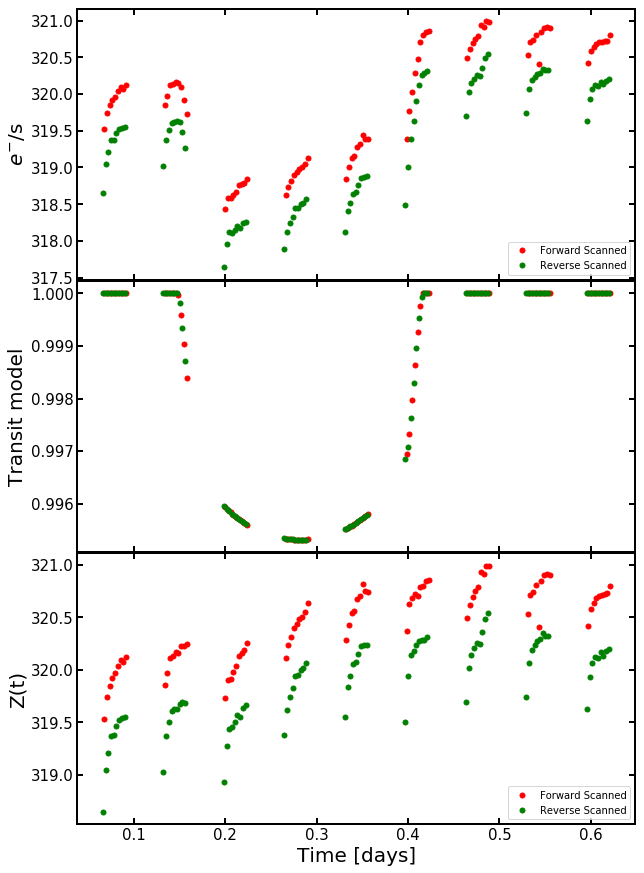

In [18]:
forward=Planet_LC.Forward
import matplotlib.pyplot as plt
z=f_i_full[Excl_first]/eclipse_LC
z_err=f_i_full_err[Excl_first]
fig,axs=plt.subplots(3,1,figsize=(10,15),sharex=True)
axs[0].plot(sorted_times[Excl_first][forward],f_i_full[Excl_first][forward],ls='none',marker='.',ms=10,color='red',label='Forward Scanned')
axs[0].plot(sorted_times[Excl_first][~forward],f_i_full[Excl_first][~forward],ls='none',marker='.',ms=10,color='green',label='Reverse Scanned')
axs[0].legend(loc='lower right')
axs[1].plot(sorted_times[Excl_first][forward],eclipse_LC[forward],ls='none',marker='.',ms=10,color='red')
axs[1].plot(sorted_times[Excl_first][~forward],eclipse_LC[~forward],ls='none',marker='.',ms=10,color='green')
axs[2].plot(sorted_times[Excl_first][forward],z[forward],ls='none',marker='.',color='red',ms=10,label='Forward Scanned')
axs[2].plot(sorted_times[Excl_first][~forward],z[~forward],ls='none',marker='.',color='green',ms=10,label='Reverse Scanned')
axs[2].legend(loc='lower right')
axs[0].set_ylabel(r'$e^{-}$/s',fontsize=20)
axs[2].set_ylabel('Z(t)',fontsize=20)
axs[2].set_xlabel('Time [days]',fontsize=20)
axs[1].set_ylabel('Transit model',fontsize=20)
plt.subplots_adjust(hspace=0.005)
for i in range(3):
   # ax=axs[i]
    axs[i].tick_params('both',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
    for axis in ['top','bottom','left','right']:
        axs[i].spines[axis].set_linewidth(2.0)
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/V1298_systematics_function.png',format='png',bbox_inches='tight')

In [14]:
Nr_pixels = 7
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]
bins_std_wave = [np.max(bin)-np.mean(bin) for bin in bins]
print (bins_std_wave)



[0.013969530897124827, 0.013970323410006591, 0.013971050649354666, 0.013971712613400245, 0.013972309300378516, 0.013972840708528445, 0.013973306836093435, 0.013973707681320668, 0.013974043242461764, 0.013974313517771897, 0.013974518505511124, 0.013974658203944834, 0.013974732611339746, 0.013974741725969464, 0.013974685546110921, 0.013974564070047268, 0.004658152493441259]


In [15]:
Nr_pixels = 7
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

excl_indices=[]
excl_indices.append(135)

lis1=[118,119,120,121,122,123,124,125]
inc=np.ones(len(z),dtype=bool)
forward=Planet_LC.Forward
#excl_indices.extend(lis1)
inc[excl_indices]=False
import lmfit
Rad_f=np.array([])
Rad_err_f=np.array([])
Rad_r=np.array([])
Rad_err_r=np.array([])
for i in range (N_bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, bins[i], average=True, weighted=False)
    Binned_LC=Binned_LC/imagesize
    Binned_LC_err=Binned_LC_err/imagesize
  #  Binned_LC=Binned_LC/np.max(Binned_LC)
  #  Binned_LC_err=Binned_LC_err/np.max(Binned_LC)
    data_f=Binned_LC[Excl_first][forward*inc]/z[forward*inc]
    times_f=sorted_times[Excl_first][forward*inc]+min(Times_org)
    data_r=Binned_LC[Excl_first][~forward*inc]/z[~forward*inc]
    times_r=sorted_times[Excl_first][~forward*inc]+min(Times_org)
#import lmfit
    params=lmfit.Parameters()
    params.add('t0',value=Planet_LC.sp_params.t0,vary=False)

    params.add('per',value=Planet_LC.sp_params.per,vary=False)
    params.add('aRs',value=opt[5],vary=False)
    params.add('depth',value=opt[0],max=0.1,min=0.0)
    params.add('inc',value=Planet_LC.sp_params.inc,vary=False)
    params.add('ecc',value=Planet_LC.sp_params.ecc,vary=False)
    params.add('w',value=Planet_LC.sp_params.w,vary=False)
    params.add('u1',value=opt[6],max=1,min=0.0)
    params.add('c1',value=1.0,min=0.6,max=1.2)
    params.add('c2',value=0.0,max=1,min=-1)
    params.add('t_mid',value=0.0,max=0.04,min=-0.04)
    out_f=lmfit.minimize(residual,params,args=(times_f,data_f,Binned_LC_err[Excl_first][forward*inc],z[forward*inc],z_err[forward*inc]),method='leastsq')
    out_r=lmfit.minimize(residual,params,args=(times_r,data_r,Binned_LC_err[Excl_first][~forward*inc],z[~forward*inc],z_err[~forward*inc]),method='leastsq')
    lmfit.report_fit(out_f)
    opt_f = [out_f.params[key].value for key in out_f.params.keys()]
    err_f = [out_f.params[key].stderr for key in out_f.params.keys()]
    opt_r = [out_r.params[key].value for key in out_r.params.keys()]
    err_r = [out_r.params[key].stderr for key in out_r.params.keys()]
#print (opt)
    times_plot=np.linspace(min(sorted_times),max(sorted_times),1000)
    times_plot+=min(Times_org)
    expected_f=transit_model(times_f,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
    expected_r=transit_model(times_r,t0=opt_r[0],per=opt_r[1],aRs=opt_r[2],depth=opt_r[3],inc=opt_r[4],ecc=opt_r[5],w=opt_r[6]
                            ,u1=opt_r[7],c1=opt_r[8],c2=opt_r[9],t_mid=opt_r[10])
#    print ('Residual in ppm',(np.sqrt(sum((data_f-expected_f)**2/expected_f**2))/len(data_f))*1e6)
    expected_plot_f=transit_model(times_plot,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
    expected_plot_r=transit_model(times_plot,t0=opt_r[0],per=opt_r[1],aRs=opt_r[2],depth=opt_r[3],inc=opt_r[4],ecc=opt_r[5],w=opt_r[6]
                            ,u1=opt_r[7],c1=opt_r[8],c2=opt_r[9],t_mid=opt_r[10])
    res_f=data_f-expected_f
    res_r=data_r-expected_r
    print ('Res in ppm forward,reverse ',np.sqrt(np.sum(res_f**2/data_f**2)/len(data_f))*1e6
          ,np.sqrt(np.sum(res_r**2/data_r**2)/len(data_r))*1e6)
    fig,axs=plt.subplots(3,1,figsize=(12,10),sharex=False,gridspec_kw={'hspace':0})
    axs[0].plot(times_plot,expected_plot_f,color='blue',label='Expected Forward')
    axs[0].plot(times_f,data_f,ls='none',marker='.',color='blue',label='Forward')
    axs[0].plot(times_plot,expected_plot_r,color='green',label='Expected Reverse')
    axs[0].plot(times_r,data_r,ls='none',marker='.',color='green',label='Reverse')
    axs[1].plot(times_f,((data_f-expected_f)/np.max(expected_f))*1e6,ls='none',marker='.',label='Forward',color='blue')
    axs[1].plot(times_r,((data_r-expected_r)/np.max(expected_r))*1e6,ls='none',marker='.',label='Reverse',color='green')
    axs[2].hist(((data_f-expected_f)/np.max(expected_f))*1e6,color='blue',histtype='step')
    axs[2].hist(((data_r-expected_r)/np.max(expected_r))*1e6,color='green',histtype='step')
    axs[2].set_xlim(-700,700)
    axs[1].hlines(0,min(times_f),max(times_f))
    axs[1].legend()
    axs[0].legend()
    Rad_f=np.append(Rad_f,opt_f[3])
    Rad_err_f=np.append(Rad_err_f,err_f[3])
    Rad_r=np.append(Rad_r,opt_r[3])
    Rad_err_r=np.append(Rad_err_r,err_r[3])
    
    

NameError: name 'residual' is not defined

(17, 17, 17)
(array([0.00055022, 0.00049528, 0.00048695, 0.00047982, 0.00049161,
       0.00050266, 0.000472  , 0.00046681, 0.00044122, 0.00039279,
       0.00046535, 0.00054776, 0.00044896, 0.00051778, 0.0005166 ,
       0.00050118, 0.00090358]), 17)


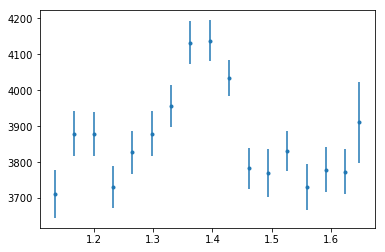

In [14]:
plt.errorbar(bins_avg_wave,(Rad_f**2)*1e6,yerr=(Rad_err_f*Rad_f*2)*1e6,ls='none',marker='.')
#plt.errorbar(bins_avg_wave,(Rad_r**2)*1e6,yerr=(Rad_err_r*Rad_r*2)*1e6,ls='none',marker='.')
#plt.plot(bins_avg_wave,Rad,ls='none',marker='.')
#print (Rad)
#plt.ylim(0.0575,0.0650)
#plt.ylim(3500,4300)
#print (Rad_r,Rad_f)
print (len(bins_avg_wave),len(Rad_r),len(Rad_err_r))
print (Rad_err_f,N_bins)

2459119.024624373
2459119.024624373
2459119.024624373


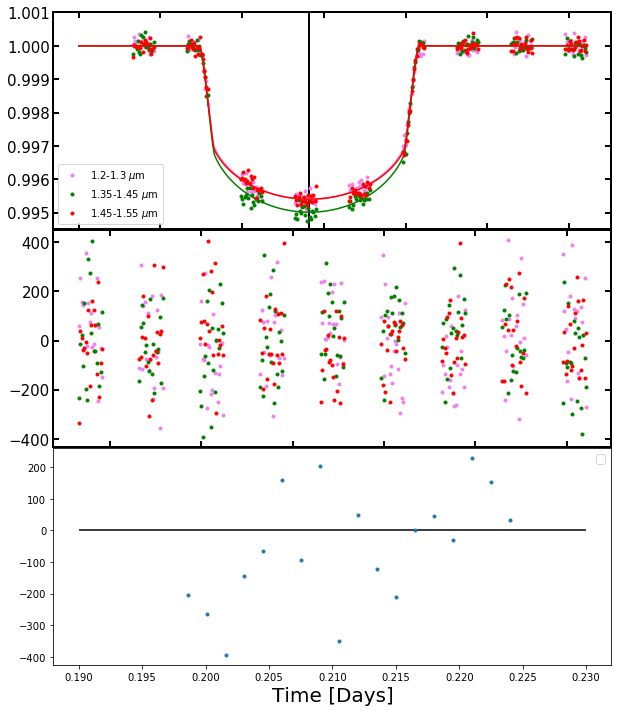

In [52]:
WL_waves_0 = Wave[(Wave > 1.25) & (Wave < 1.3)]#Wave[Wavelengthrange]
WL_waves_1 = Wave[(Wave > 1.4) & (Wave < 1.45)]#Wave[Wavelengthrange]
WL_waves_2 = Wave[(Wave > 1.5) & (Wave < 1.55)]#Wave[Wavelengthrange]
wave_bins=[WL_waves_0,WL_waves_1,WL_waves_2]
times=sorted_times[Excl_first]+min(Times_org)

excl_indices=[]
excl_indices.append(135)

lis1=[0,1,2,3,4,5,6,7,8,118,119,120,121,122,123,124,125,135]
inc=np.ones(len(z),dtype=bool)
forward=Planet_LC.Forward
#excl_indices.extend(lis1)
inc[excl_indices]=False
import lmfit
color=['violet','green','red']
labels=[r'1.2-1.3 $\mu$m',r'1.35-1.45 $\mu$m',r'1.45-1.55 $\mu$m']
fig,axs=plt.subplots(3,1,figsize=(10,12),sharex=False)
for i in range (3):

    Binned_LC_0, Binned_LC_err_0 = fit_fns.calc_WL(df_sorted, df_sorted_err,wave_bins[i], average=True, weighted=False)
    Binned_LC0=Binned_LC_0/imagesize
    Binned_LC_err_0=Binned_LC_err_0/imagesize
    Binned_LC0=(Binned_LC0[Excl_first]/z)/max(Binned_LC0[Excl_first]/z)
    params=lmfit.Parameters()
    params.add('t0',value=Planet_LC.sp_params.t0,vary=False)

    params.add('per',value=Planet_LC.sp_params.per,vary=False)
    params.add('aRs',value=opt[5],vary=False)
    params.add('depth',value=opt[0],max=0.1,min=0.0)
    params.add('inc',value=Planet_LC.sp_params.inc,vary=False)
    params.add('ecc',value=Planet_LC.sp_params.ecc,vary=False)
    params.add('w',value=Planet_LC.sp_params.w,vary=False)
    params.add('u1',value=opt[6],max=1,min=0.0)
    params.add('c1',value=1.0,min=0.6,max=1.2)
    params.add('c2',value=0.0,max=1,min=-1)
    params.add('t_mid',value=opt[2],vary=False)
    out_f=lmfit.minimize(residual,params,args=(times[inc],Binned_LC0[inc],Binned_LC_0[Excl_first][inc],Binned_LC_err_0[Excl_first][inc],z[inc],z_err[inc]),method='leastsq')
    opt_f = [out_f.params[key].value for key in out_f.params.keys()]
    err_f = [out_f.params[key].stderr for key in out_f.params.keys()]
    
    expected_f=transit_model(times,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
#    res_f=data_f-expected_f
    c1=opt_f[8]
    c2=opt_f[9]
    Binned_LC0=Binned_LC0/(c1+c2*(times-times[0]))
    expected_f=expected_f/(c1+c2*(times-times[0]))
    axs[0].plot(times[inc]-min(Times_org),Binned_LC0[inc],ls='none',marker='.',color=color[i],label=labels[i])
    axs[1].plot(times[inc]-min(Times_org),((Binned_LC0[inc]-expected_f[inc])/np.max(expected_f[inc]))*1e6,ls='none',marker='.',color=color[i])
    plt.xlabel('Time [Days]',fontsize=20)
    t_plot=np.linspace(min(Times_org),max(Times_org),1000)
    expected_plot=transit_model(t_plot,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
    axs[0].plot(t_plot-min(Times_org),expected_plot/(c1+c2*(t_plot-t_plot[0])),color=color[i])
    t_centre=t0+Planet_LC.sp_params.per-opt[2]-min(Times_org)
    print (t_centre+min(Times_org))
    axs[0].vlines(t_centre,0.9935,1.005)
    axs[0].set_ylim(0.9945,1.001)
#   axs[2].hist(((Binned_LC0[Thi]-expected_f[Thi])/np.max(expected_f))*1e6,histtype='bar',color=color[i])
    if (i==1):
        axs[2].plot(times[Thi]-min(Times_org),((Binned_LC0[Thi]-expected_f[Thi])/np.max(expected_f))*1e6,ls='none',marker='.')
        axs[2].hlines(0.0,0.19,0.23)
    
#    axs[0].ylabel('Normalized flux',fontsize=20)
plt.legend(fontsize=12)

axs[0].tick_params('both',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
axs[1].tick_params('both',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(2.0)
    axs[1].spines[axis].set_linewidth(2.0)
plt.subplots_adjust(hspace=0.005)   
axs[0].legend()
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/V1298_photometric_transits.png',format='png',bbox_inches='tight')

#Binned_LC_1, Binned_LC_err_1 = fit_fns.calc_WL(df_sorted, df_sorted_err,WL_waves_1, average=True, weighted=False)
#Binned_LC1=Binned_LC_1/imagesize
#Binned_LC_err_1=Binned_LC_err_1/imagesize
#Binned_LC1=(Binned_LC1[Excl_first]/z)/max(Binned_LC1[Excl_first]/z)


#Binned_LC_2, Binned_LC_err_2 = fit_fns.calc_WL(df_sorted, df_sorted_err,WL_waves_2, average=True, weighted=False)
#Binned_LC2=Binned_LC_2/imagesize
#Binned_LC_err_2=Binned_LC_err_2/imagesize
#Binned_LC2=(Binned_LC2[Excl_first]/z)/max(Binned_LC2[Excl_first]/z)

#times=sorted_times[Excl_first]+min(Times_org)


#plt.plot(times,Binned_LC0,ls='none',marker='.',color='violet')
#plt.plot(times,Binned_LC1,ls='none',marker='.',color='green')
#plt.plot(times,Binned_LC2+0.0001,ls='none',marker='.',color='red')

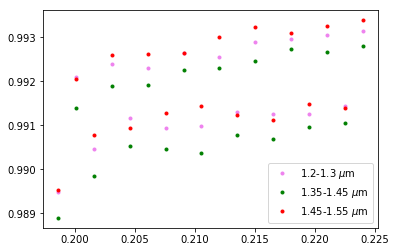

In [25]:
for i in range (3):

    Binned_LC_0, Binned_LC_err_0 = fit_fns.calc_WL(df_sorted, df_sorted_err,wave_bins[i], average=True, weighted=False)
    Binned_LC0=Binned_LC_0[Excl_first]/imagesize
    Binned_LC_err_0=Binned_LC_err_0/imagesize
    plt.plot(times[Thi]-min(Times_org),Binned_LC0[Thi]/max(Binned_LC0),ls='none',marker='.',color=color[i],label=labels[i])
plt.legend()


In [25]:
print (opt[2],Planet_LC.sp_params.t0+Planet_LC.sp_params.per+opt[2],min(Times_org),max(Times_org),t0)

(0.021580454159367636, 2459119.0648834687, 2459118.73963, 2459119.36074, 2459094.9021970145)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 161
    # variables        = 5
    chi-square         = 173.417649
    reduced chi-square = 1.11165160
    Akaike info crit   = 21.9620548
    Bayesian info crit = 37.3690767
[[Variables]]
    t0:     2459095 (fixed)
    per:    24.14111 (fixed)
    aRs:    26.84106 (fixed)
    depth:  0.06398695 +/- 4.2546e-04 (0.66%) (init = 0.06475332)
    inc:    89.35 (fixed)
    ecc:    0.112 (fixed)
    w:      85 (fixed)
    u1:     0.31232112 +/- 0.04142498 (13.26%) (init = 0.2698101)
    c1:     0.85826574 +/- 3.7335e-05 (0.00%) (init = 1)
    c2:     8.6441e-04 +/- 9.8958e-05 (11.45%) (init = 0)
    t_mid:  0.01887105 +/- 5.3296e-04 (2.82%) (init = 0.02)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2)       = -0.834
    C(depth, u1)    = -0.700
    C(depth, c1)    =  0.521
    C(u1, t_mid)    = -0.459
    C(depth, t_mid) =  0.382
    C(depth, c2)    = -0.274
    C(c2,

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 161
    # variables        = 5
    chi-square         = 125.057580
    reduced chi-square = 0.80165116
    Akaike info crit   = -30.6734445
    Bayesian info crit = -15.2664227
[[Variables]]
    t0:     2459095 (fixed)
    per:    24.14111 (fixed)
    aRs:    26.84106 (fixed)
    depth:  0.06673340 +/- 3.1942e-04 (0.48%) (init = 0.06475332)
    inc:    89.35 (fixed)
    ecc:    0.112 (fixed)
    w:      85 (fixed)
    u1:     0.27286495 +/- 0.03038338 (11.13%) (init = 0.2698101)
    c1:     1.06562695 +/- 3.6088e-05 (0.00%) (init = 1)
    c2:     2.3615e-04 +/- 9.5541e-05 (40.46%) (init = 0)
    t_mid:  0.01885519 +/- 3.7919e-04 (2.01%) (init = 0.02)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2)       = -0.834
    C(depth, u1)    = -0.698
    C(depth, c1)    =  0.527
    C(u1, t_mid)    = -0.458
    C(depth, t_mid) =  0.384
    C(depth, c2)    = -0.279
    C(c

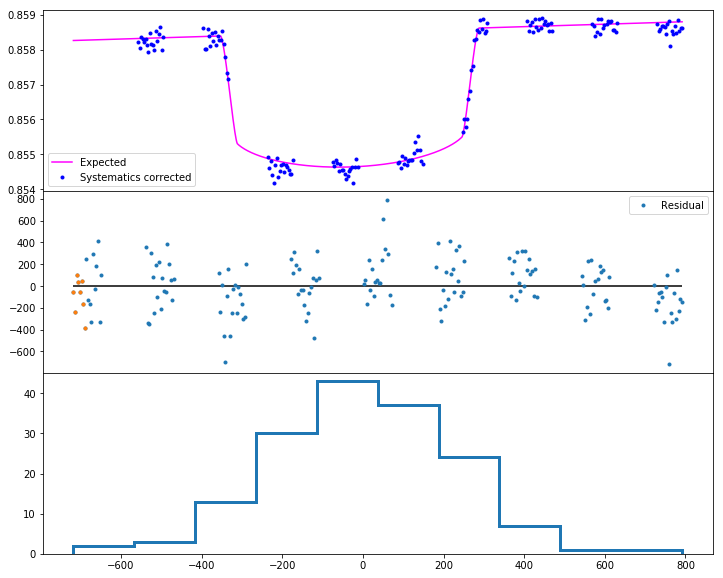

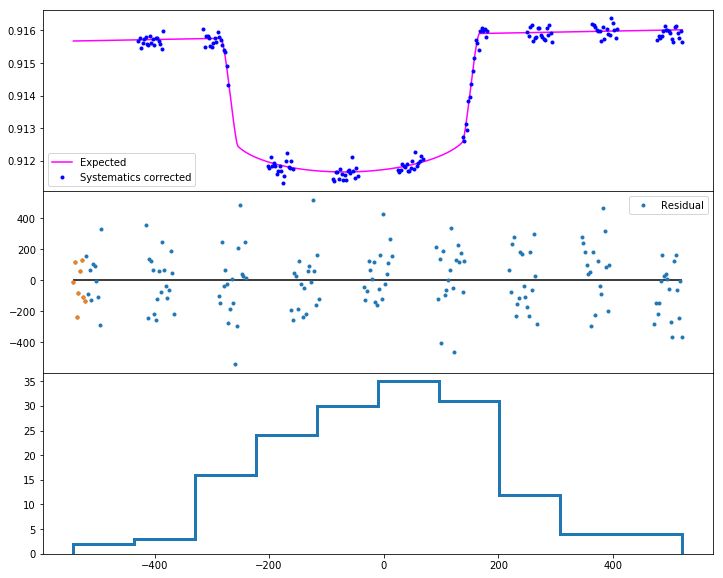

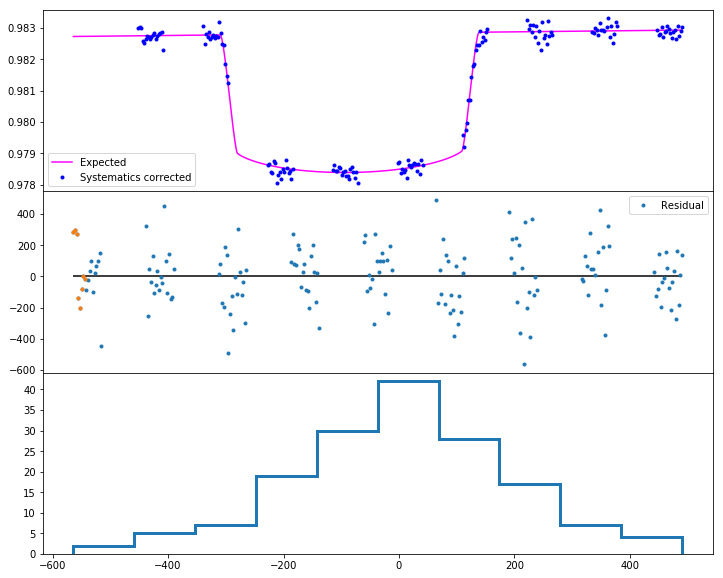

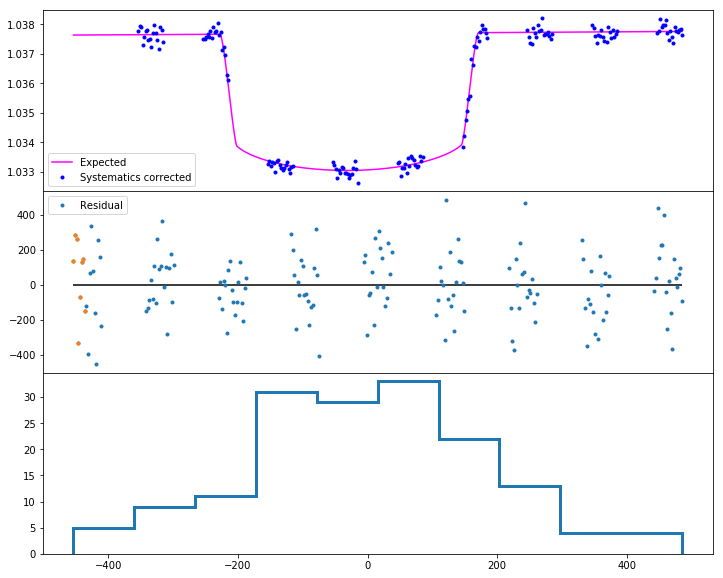

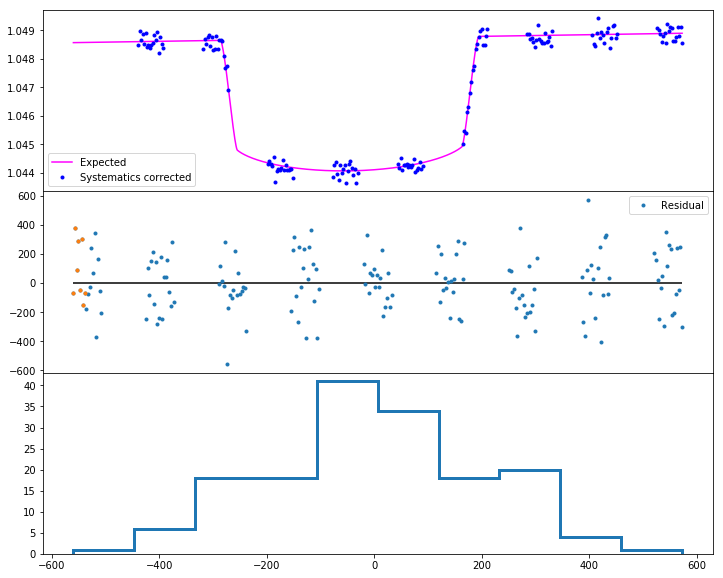

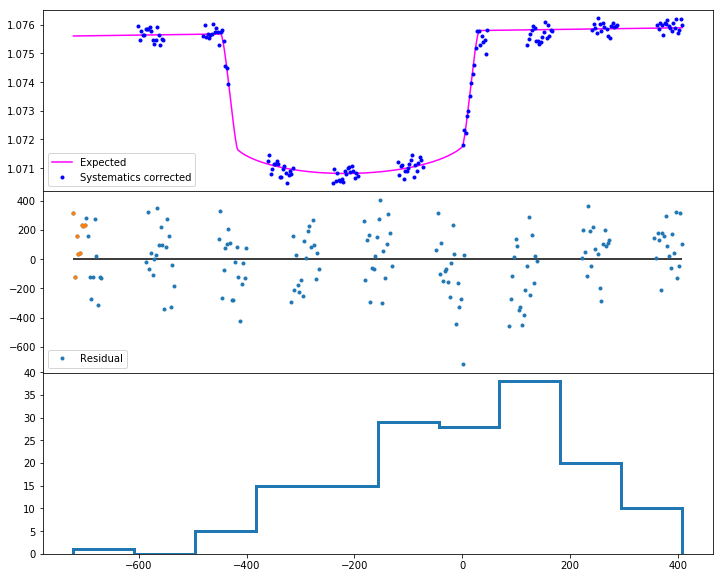

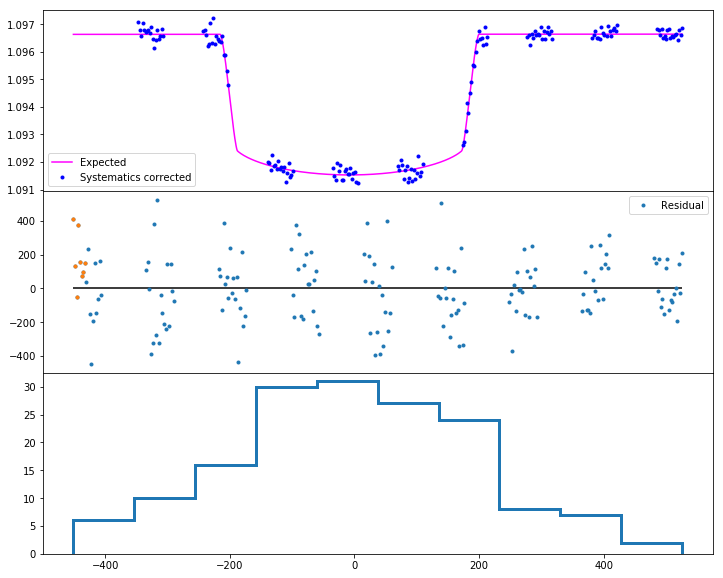

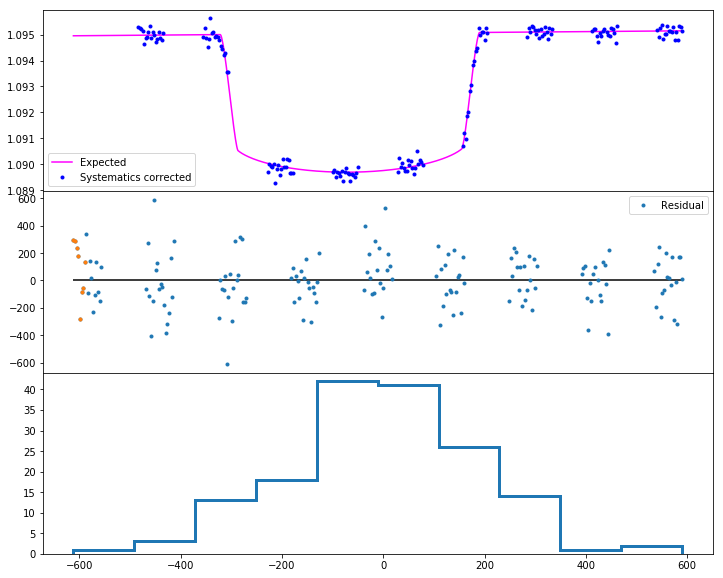

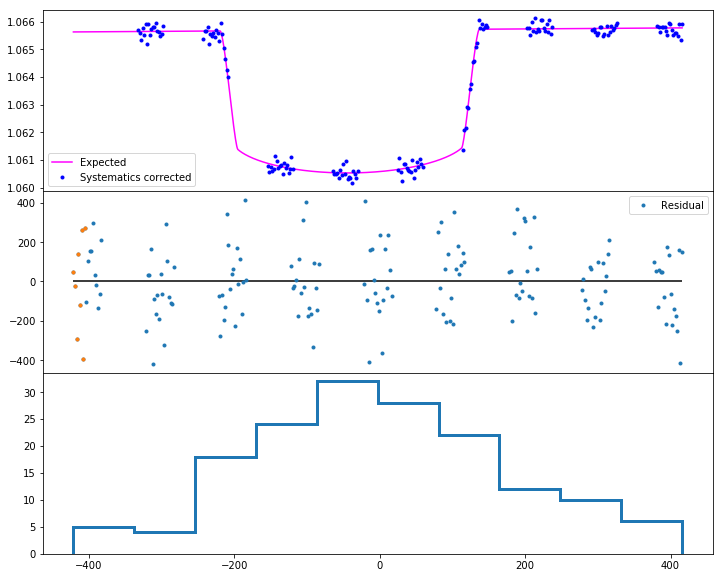

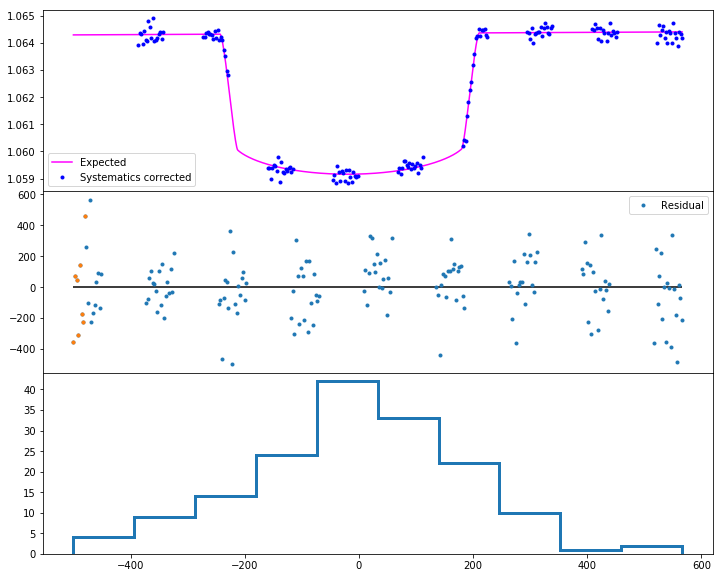

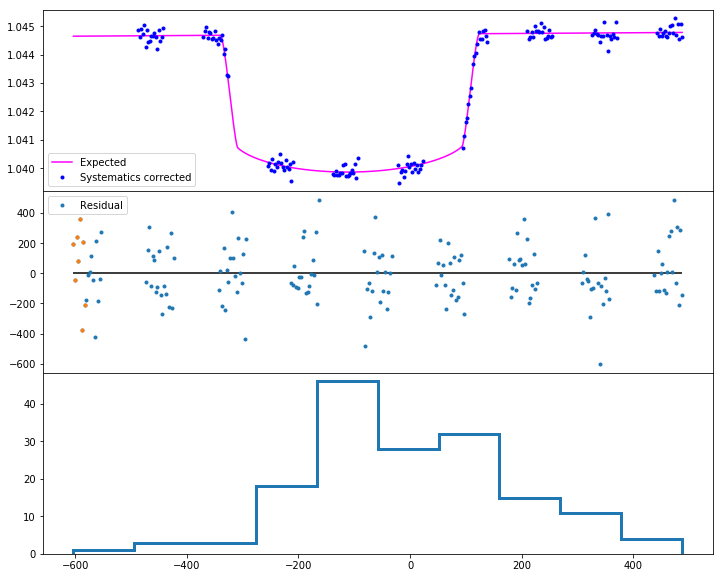

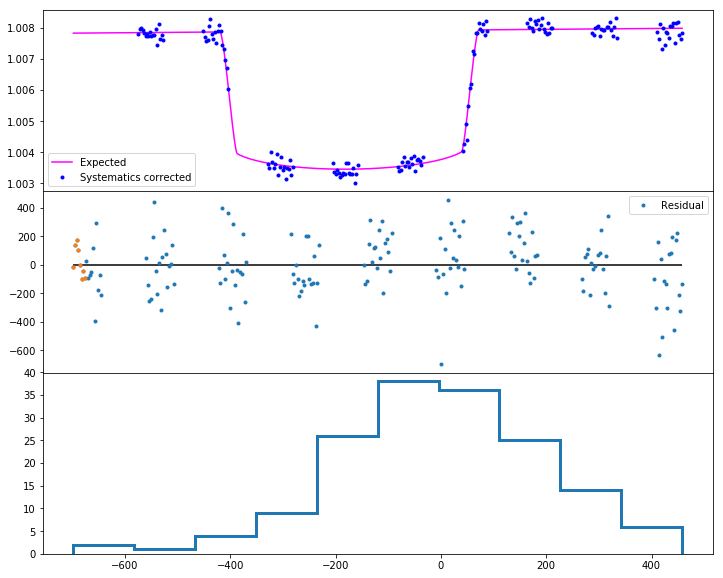

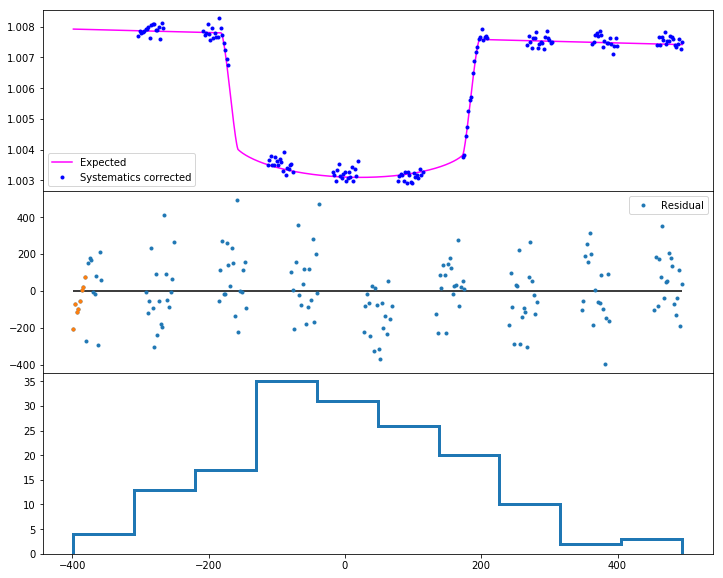

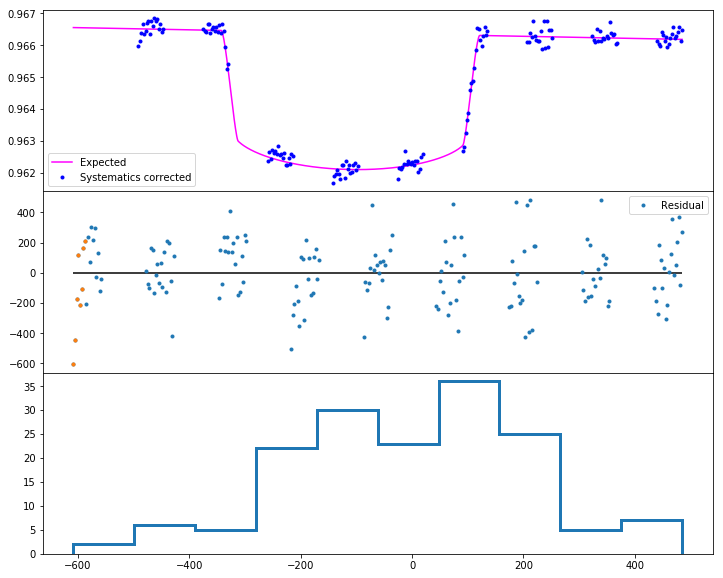

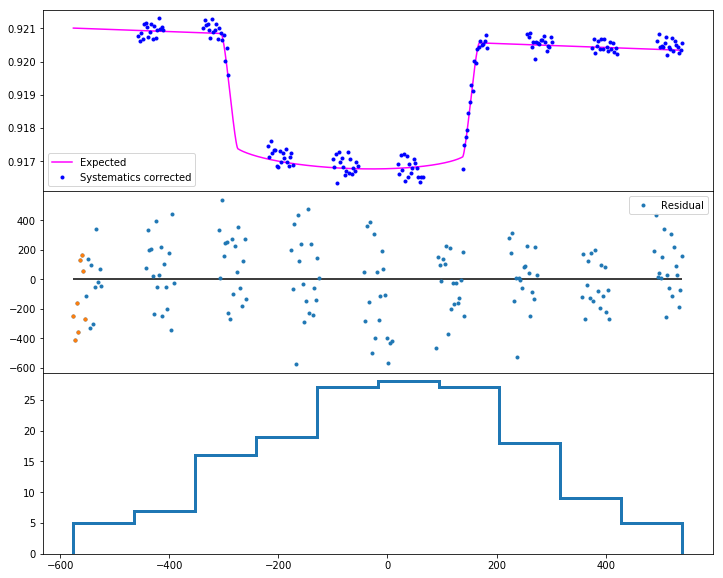

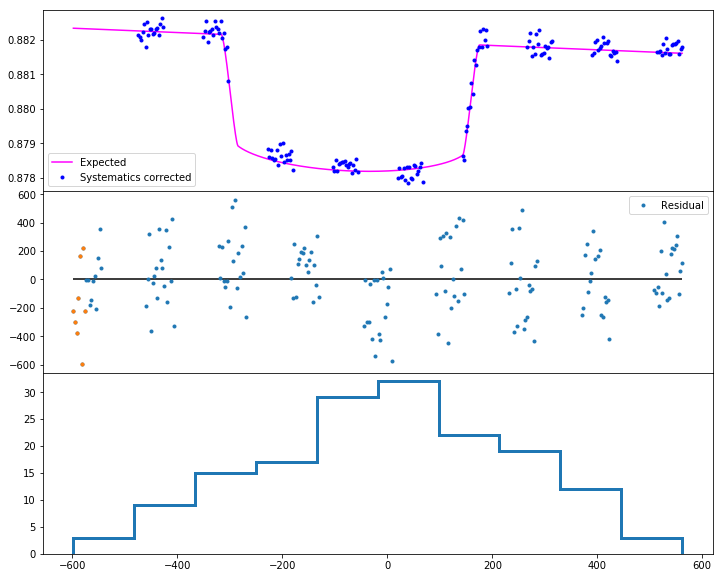

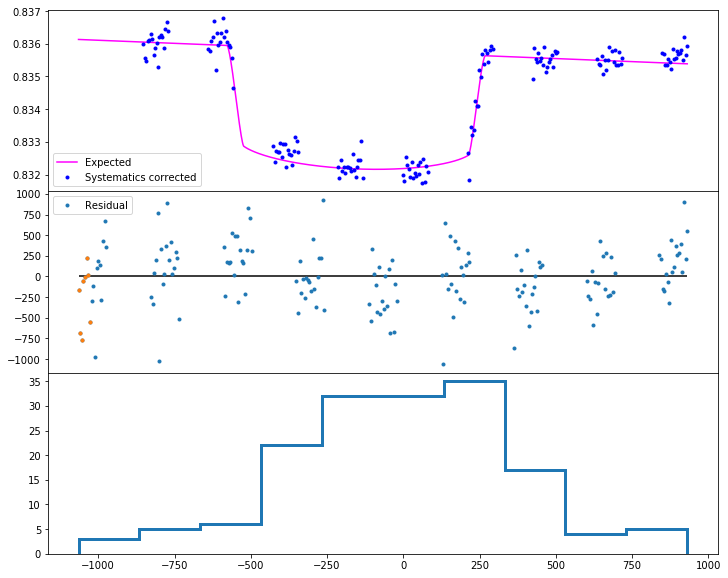

In [15]:
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels import robust
Nr_pixels = 7
bins = []
i = 0
res_median=[]
res_dev=[]
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]
bins_std_wave= [np.std(bin) for bin in bins]

N_bins = len(bins_avg_wave)

excl_indices=[]
excl_indices.append(135)

lis1=[0,1,2,3,4,5,6,7,8,118,119,120,121,122,123,124,125]
#lis1=[118,119,120,121,122,123,124,125]
inc=np.ones(len(z),dtype=bool)
forward=Planet_LC.Forward
#excl_indices.extend(lis1)
inc[excl_indices]=False
import lmfit
Rad=np.array([])
Rad_err=np.array([])
#Rad_r=np.array([])
#Rad_err_r=np.array([])
u_limb=np.array([])
u_limb_err=np.array([])
Res=np.array([])
mid_time=np.array([])
mid_time_err=np.array([])
for i in range (N_bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, bins[i], average=True, weighted=False)
    Binned_LC=Binned_LC/imagesize
    Binned_LC_err=Binned_LC_err/imagesize
  #  Binned_LC=Binned_LC/np.max(Binned_LC)
  #  Binned_LC_err=Binned_LC_err/np.max(Binned_LC)
    data_f=Binned_LC[Excl_first][inc]/z[inc]
    times_f=sorted_times[Excl_first][inc]+min(Times_org)
    times_plot=np.linspace(min(sorted_times),max(sorted_times),1000)
    times_plot+=min(Times_org)
    
 #   data_r=Binned_LC[Excl_first][~forward*inc]/z[~forward*inc]
 #   times_r=sorted_times[Excl_first][~forward*inc]+min(Times_org)
#import lmfit
    params=lmfit.Parameters()
    params.add('t0',value=Planet_LC.sp_params.t0,vary=False)

    params.add('per',value=Planet_LC.sp_params.per,vary=False)
    params.add('aRs',value=opt[5],vary=False)
    params.add('depth',value=np.sqrt(opt[0]),max=0.1,min=0.0)
    params.add('inc',value=opt[3],vary=False)
    params.add('ecc',value=Planet_LC.sp_params.ecc,vary=False)
    params.add('w',value=Planet_LC.sp_params.w,vary=False)
    params.add('u1',value=opt[6],max=1,min=0.0)
    params.add('c1',value=1.0,min=0.6,max=1.2)
    params.add('c2',value=0.0,max=1,min=-1)
    params.add('t_mid',value=0.02,max=0.2,min=0.001)
    out_f=lmfit.minimize(residual,params,args=(times_f,data_f,Binned_LC[Excl_first][inc],Binned_LC_err[Excl_first][inc],z[inc],z_err[inc]),method='leastsq')
#    out_r=lmfit.minimize(residual,params,args=(times_r,data_r),method='leastsq')
 #   if (i==7):
        
    lmfit.report_fit(out_f)
    opt_f = [out_f.params[key].value for key in out_f.params.keys()]
    err_f = [out_f.params[key].stderr for key in out_f.params.keys()]
    u_limb=np.append(u_limb,opt_f[7])
    u_limb_err=np.append(u_limb_err,err_f[7])
    mid_time=np.append(mid_time,opt_f[10])
    mid_time_err=np.append(mid_time_err,err_f[10])
 #   opt_r = [out_r.params[key].value for key in out_r.params.keys()]
 #   err_r = [out_r.params[key].stderr for key in out_r.params.keys()]
#print (opt)
    expected_f=transit_model(times_f,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
    expected_plot=transit_model(times_plot,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
#    expected_r=transit_model(times_r,t0=opt_r[0],per=opt_r[1],aRs=opt_r[2],depth=opt_r[3],inc=opt_r[4],ecc=opt_r[5],w=opt_r[6]
#                            ,u1=opt_r[7],c1=opt_r[8],c2=opt_r[9],t_mid=opt_r[10])
#    print ('Residual in ppm',(np.sqrt(sum((data_f-expected_f)**2/expected_f**2))/len(data_f))*1e6)
    res_f=data_f-expected_f
 #   res_r=data_r-expected_r
    if (i==7):
        print ('Res in ppm ',np.sqrt(np.sum(res_f**2/data_f**2)/len(data_f))*1e6)
    Res=np.append(Res,np.sqrt(np.sum(res_f**2/data_f**2)/len(data_f))*1e6)
 #         ,np.sqrt(np.sum(res_r**2/data_r**2)/len(data_r))*1e6)
    fig,axs=plt.subplots(3,1,figsize=(12,10),sharex=False,gridspec_kw={'hspace':0})
    axs[0].plot(times_plot,expected_plot,color='magenta',label='Expected')
    axs[0].plot(times_f,data_f,ls='none',marker='.',color='blue',label='Systematics corrected')
  #  axs[0].plot(times_r,expected_r,ls='none',marker='.',color='magenta',label='Expected')
  #  axs[0].plot(times_r,data_r,ls='none',marker='.',color='green',label='Reverse')
    axs[1].plot(times_f,((data_f-expected_f)/np.max(expected_f))*1e6,ls='none',marker='.',label='Residual')
    list1=[0,1,2,3,4,5,6,7]
    axs[1].plot(times_f[list1],((data_f[list1]-expected_f[list1])/np.max(expected_f))*1e6,ls='none',marker='.')
    res_median.append(np.median(((data_f[Sev]-expected_f[Sev])/np.max(expected_f))*1e6))
    res_dev.append(robust.mad(((data_f[Sev]-expected_f[Sev])/np.max(expected_f))*1e6))
    axs[2].hist(((data_f-expected_f)/np.max(expected_f))*1e6,histtype='step',linewidth=3)
  #  axs[1].plot(times_r,((data_r-expected_r)/np.max(expected_r))*1e6,ls='none',marker='.',label='Reverse')
    
    axs[1].hlines(0,min(times_f),max(times_f))
    axs[1].legend()
    axs[0].legend()
    Rad=np.append(Rad,opt_f[3])
    Rad_err=np.append(Rad_err,err_f[3])
  #  Rad_r=np.append(Rad_r,opt_r[3])
  #  Rad_err_r=np.append(Rad_err_r,err_r[3])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 161
    # variables        = 4
    chi-square         = 138.694919
    reduced chi-square = 0.88340713
    Akaike info crit   = -16.0095553
    Bayesian info crit = -3.68393785
[[Variables]]
    t0:     2459095 (fixed)
    per:    24.14111 (fixed)
    aRs:    26.37388 (fixed)
    depth:  0.06490475 +/- 2.9517e-04 (0.45%) (init = 0.0625316)
    inc:    89.35 (fixed)
    ecc:    0.112 (fixed)
    w:      85 (fixed)
    u1:     0.53137151 +/- 0.02255233 (4.24%) (init = 0.5492997)
    c1:     1.09496008 +/- 3.7888e-05 (0.00%) (init = 1)
    c2:     3.0074e-04 +/- 9.8885e-05 (32.88%) (init = 0)
    t_mid:  0.01873727 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2)    = -0.823
    C(depth, u1) = -0.633
    C(depth, c1) =  0.522
    C(depth, c2) = -0.221
    C(u1, c1)    = -0.136


Text(0.48,1.31,'$\\lambda$=4.5')

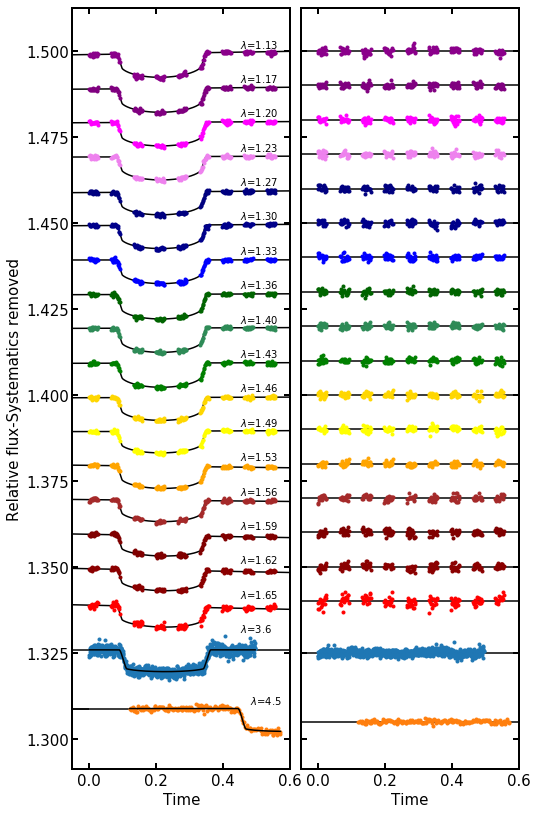

In [41]:
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels import robust
Nr_pixels = 7
bins = []
i = 0
res_median=[]
res_dev=[]
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

excl_indices=[]
excl_indices.append(135)
#excl_indices.extend(Thi)

lis1=[0,1,2,3,4,5,6,7,8,118,119,120,121,122,123,124,125]
#lis1=[118,119,120,121,122,123,124,125]
inc=np.ones(len(z),dtype=bool)
forward=Planet_LC.Forward
#excl_indices.extend(lis1)
inc[excl_indices]=False
import lmfit
Rad=np.array([])
Rad_err=np.array([])
#Rad_r=np.array([])
#Rad_err_r=np.array([])
u_limb=np.array([])
u_limb_err=np.array([])
Res=np.array([])
fig,axs=plt.subplots(1,2,figsize=(8,14),sharey=True,sharex=False)
color=['darkmagenta','purple','magenta','violet','navy','darkblue','blue','darkgreen','seagreen','green',
      'gold','yellow','orange','brown','maroon','darkred','red']
for i in range (N_bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, bins[i], average=True, weighted=False)
    Binned_LC=Binned_LC/imagesize
    Binned_LC_err=Binned_LC_err/imagesize
  #  Binned_LC=Binned_LC/np.max(Binned_LC)
  #  Binned_LC_err=Binned_LC_err/np.max(Binned_LC)
    data_f=Binned_LC[Excl_first][inc]/z[inc]
    times_f=sorted_times[Excl_first][inc]+min(Times_org)
    times_plot=np.linspace(min(sorted_times),max(sorted_times)+0.1,1000)
    times_plot+=min(Times_org)
    
 #   data_r=Binned_LC[Excl_first][~forward*inc]/z[~forward*inc]
 #   times_r=sorted_times[Excl_first][~forward*inc]+min(Times_org)
#import lmfit
    params=lmfit.Parameters()
    params.add('t0',value=Planet_LC.sp_params.t0,vary=False)

    params.add('per',value=Planet_LC.sp_params.per,vary=False)
    params.add('aRs',value=opt[5],vary=False)
    params.add('depth',value=np.sqrt(opt[0]),max=0.1,min=0.0)
    params.add('inc',value=opt[3],vary=False)
    params.add('ecc',value=Planet_LC.sp_params.ecc,vary=False)
    params.add('w',value=Planet_LC.sp_params.w,vary=False)
    params.add('u1',value=opt[6],max=1,min=0.0)
    params.add('c1',value=1.0,min=0.6,max=1.2)
    params.add('c2',value=0.0,max=1,min=-1)
    params.add('t_mid',value=opt[2],vary=False)
    out_f=lmfit.minimize(residual,params,args=(times_f,data_f,Binned_LC[Excl_first][inc],Binned_LC_err[Excl_first][inc],z[inc],z_err[inc]),method='leastsq')
#    out_r=lmfit.minimize(residual,params,args=(times_r,data_r),method='leastsq')
    if (i==7):
        lmfit.report_fit(out_f)
    opt_f = [out_f.params[key].value for key in out_f.params.keys()]
    err_f = [out_f.params[key].stderr for key in out_f.params.keys()]
    u_limb=np.append(u_limb,opt_f[7])
    u_limb_err=np.append(u_limb_err,err_f[7])
 #   opt_r = [out_r.params[key].value for key in out_r.params.keys()]
 #   err_r = [out_r.params[key].stderr for key in out_r.params.keys()]
#print (opt)
    expected_f=transit_model(times_f,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
    expected_plot=transit_model(times_plot,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
#    expected_r=transit_model(times_r,t0=opt_r[0],per=opt_r[1],aRs=opt_r[2],depth=opt_r[3],inc=opt_r[4],ecc=opt_r[5],w=opt_r[6]
#                            ,u1=opt_r[7],c1=opt_r[8],c2=opt_r[9],t_mid=opt_r[10])
#    print ('Residual in ppm',(np.sqrt(sum((data_f-expected_f)**2/expected_f**2))/len(data_f))*1e6)
    res_f=data_f-expected_f
 #   res_r=data_r-expected_r
#    if (i==7):
  #  print ("{:.2f}".format(bins_avg_wave[i]),"{:.2f}".format((opt_f[3]**2)*1e6),"{:.2f}".format(2*opt_f[3]*err_f[3]*1e6),"{:.2f}".format(opt_f[7]))
    noise=np.sqrt(np.sum(res_f**2/data_f**2)/len(data_f))*1e6
    Res=np.append(Res,np.sqrt(np.sum(res_f**2/data_f**2)/len(data_f))*1e6)
 #         ,np.sqrt(np.sum(res_r**2/data_r**2)/len(data_r))*1e6)
  #  fig,axs=plt.subplots(3,1,figsize=(12,10),sharex=False,gridspec_kw={'hspace':0})
    offset=1.5-i*0.01
    axs[0].plot(times_plot-min(times_f),offset*expected_plot/max(data_f),color='black')
   
    axs[0].plot(times_f-min(times_f),offset*data_f/max(data_f),ls='none',marker='.',color=color[i])
#    axs[0].plot(times_r,expected_r,ls='none',marker='.',color='black')
  #  axs[0].plot(times_r,data_r,ls='none',marker='.',color='green',label='Reverse')
    residuals=((data_f-expected_f)/np.max(expected_f))
    axs[1].plot(times_f-min(times_f),offset+np.mean(residuals)+residuals*3,ls='none',marker='.',color=color[i])
    t_res=np.linspace(-0.1,0.8,1000)
    axs[1].hlines(offset,min(t_res),max(t_res))
    list1=[0,1,2,3,4,5,6,7]
#    axs[1].plot(times_f[list1],((data_f[list1]-expected_f[list1])/np.max(expected_f))*1e6,ls='none',marker='.')
#    res_median.append(np.median(((data_f[Sev]-expected_f[Sev])/np.max(expected_f))*1e6))
    res_dev.append(robust.mad(((data_f[Sev]-expected_f[Sev])/np.max(expected_f))*1e6))
#    axs[2].hist(((data_f-expected_f)/np.max(expected_f))*1e6,histtype='step',linewidth=3)
  #  axs[1].plot(times_r,((data_r-expected_r)/np.max(expected_r))*1e6,ls='none',marker='.',label='Reverse')
    
#    axs[1].hlines(0,min(times_f),max(times_f))
#    axs[1].legend()
#    axs[0].legend()
    Rad=np.append(Rad,opt_f[3])
    Rad_err=np.append(Rad_err,err_f[3])
  #  Rad_r=np.append(Rad_r,opt_r[3])
  #  Rad_err_r=np.append(Rad_err_r,err_r[3])
    float = bins_avg_wave[i]
    format_float = "{:.2f}".format(float)
    axs[0].annotate(r'$\lambda$='+str(format_float),xy=(0.45,offset+0.001),xycoords='data')
np.savetxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_lmfit_full.txt',np.column_stack((bins_avg_wave,Rad**2,2*Rad*Rad_err)))
axs[0].set_xlim(-0.05,0.6)
axs[1].set_xlim(-0.05,0.6)
axs[0].set_ylabel('Relative flux-Systematics removed',fontsize=15)
plt.subplots_adjust(wspace=0.1)
axs[0].set_xlabel('Time',fontsize=15)
axs[1].set_xlabel('Time',fontsize=15)

axs[0].tick_params('both',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
axs[1].tick_params('both',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(2.0)
    axs[1].spines[axis].set_linewidth(2.0)
plt.subplots_adjust(wspace=0.05)  

#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/wavelength_LC.pdf',format='pdf',bbox_inches='tight')

df=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/V1298_spitzer/circ_fixaincdavidetal/Lightcurves_V1298_ch1_r69997568_circ_fixaincdavidetal.csv')
#t=np.linspace(0.0,0.4516,1000)
#print (bins)
df=df.groupby(df.index // 100).mean()
#print (list(df.columns))
#import matplotlib.pyplot as plt
c_lc=df['Corrected_lc'].tolist()
c_lc=np.array(c_lc)
offset=offset-0.01
axs[0].plot(df['Midtimes'].tolist(),offset*c_lc/max(c_lc),ls='none',marker='.')
c_model=df['Corrected_model'].tolist()
c_model=np.array(c_model)

axs[0].plot(df['Midtimes'].tolist(),c_model*offset/max(c_lc),color='black')
axs[0].hlines(offset/max(c_lc),-0.05,0.0,color='black')
axs[0].hlines(offset/max(c_lc),0.45,0.6,color='black')

res=[]
for i in range (len(df['Midtimes'].tolist())):
    res.append(df['Corrected_lc'].tolist()[i]- df['Corrected_model'].tolist()[i])
res1=np.array(res)
axs[1].plot(df['Midtimes'].tolist(),offset+np.mean(res1)+res-0.005,ls='none',marker='.')
axs[1].hlines(offset-0.005,-0.05,0.6,color='black')
axs[0].annotate(r'$\lambda$='+str(3.6),xy=(0.45,offset+0.001),xycoords='data')




df=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/V1298_spitzer/circ_fixaincdavidetal/Lightcurves_V1298_ch2_r69997568_circ_fixaincdavidetal.csv')
#t=np.linspace(0.0,0.4516,1000)
#print (bins)
df=df.groupby(df.index // 100).mean()
#print (list(df.columns))
#import matplotlib.pyplot as plt
c_lc=df['Corrected_lc'].tolist()
c_lc=np.array(c_lc)
offset=offset-0.02
axs[0].plot([x+0.12 for x in df['Midtimes'].tolist()],offset*c_lc/max(c_lc),ls='none',marker='.')
c_model=df['Corrected_model'].tolist()
c_model=np.array(c_model)

axs[0].plot([x+0.12 for x in df['Midtimes'].tolist()],c_model*offset/max(c_lc),color='black')
axs[0].hlines(offset/max(c_lc),-0.05,0.0,color='black')
#axs[0].hlines(offset/max(c_lc),0.45,0.6,color='black')

res=[]
for i in range (len(df['Midtimes'].tolist())):
    res.append(df['Corrected_lc'].tolist()[i]- df['Corrected_model'].tolist()[i])
res1=np.array(res)
axs[1].plot([x+0.12 for x in df['Midtimes'].tolist()],offset+np.mean(res1)+res-0.005,ls='none',marker='.')
axs[1].hlines(offset-0.005,-0.05,0.6,color='black')
axs[0].hlines(offset/max(c_lc),-0.05,0.2,color='black')

axs[0].annotate(r'$\lambda$='+str(4.5),xy=(0.48,offset),xycoords='data')

#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/wavelength_LC.pdf',format='pdf',bbox_inches='tight')

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), array([0.00059195, 0.00024547, 0.00046146, 0.00023128, 0.00049877,
       0.00025707, 0.0004707 , 0.00021217, 0.00020999, 0.00043783,
       0.00023285, 0.00023515, 0.00021614, 0.00028129, 0.00028931,
       0.00061925, 0.0004927 ]))


<ErrorbarContainer object of 3 artists>

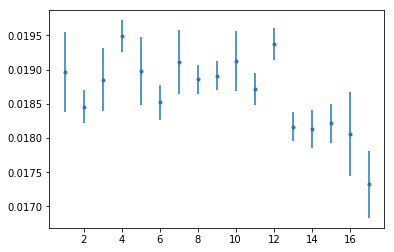

In [27]:
x=np.arange(1,18,1)
print (x,mid_time_err)
plt.errorbar(x,mid_time,yerr=mid_time_err,ls='none',marker='.')

['Corrected_lc', 'Corrected_model', 'Full(Raw)_model', 'Midtimes', 'Raw_lc', 'lc_err']


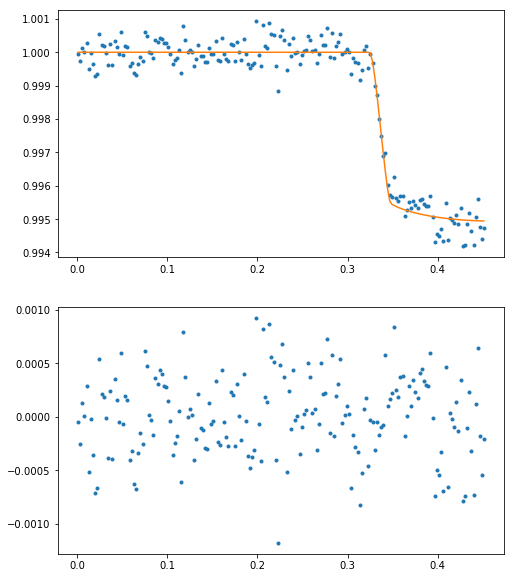

In [27]:
df=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/V1298_spitzer/circ_fixaincdavidetal/Lightcurves_V1298_ch2_r69997568_circ_fixaincdavidetal.csv')
#print (df)
df1=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/V1298_spitzer/circ_fixaincdavidetal/Lightcurves_V1298_ch1_r69997568_circ_fixaincdavidetal.csv')
#print (df)
fig,ax=plt.subplots(2,1,figsize=(8,10))
#df.plot(kind='scatter',x='Midtimes',y='Corrected_lc',ax=ax)
t=np.linspace(0.0,0.4516,1000)
#print (bins)
df=df.groupby(df.index // 100).mean()
print (list(df.columns))
import matplotlib.pyplot as plt
ax[0].plot(df['Midtimes'].tolist(),df['Corrected_lc'].tolist(),ls='none',marker='.')
ax[0].plot(df['Midtimes'].tolist(),df['Corrected_model'].tolist())
res=[]
for i in range (len(df['Midtimes'].tolist())):
    res.append(df['Corrected_lc'].tolist()[i]- df['Corrected_model'].tolist()[i])
ax[1].plot(df['Midtimes'].tolist(),res,ls='none',marker='.')

(array([0.00379928, 0.00385735, 0.00390708, 0.00376745, 0.00378206,
       0.00391894, 0.00397138, 0.00421263, 0.00414561, 0.00413582,
       0.00395006, 0.00382897, 0.00391558, 0.00378459, 0.00376683,
       0.0037516 , 0.00379967]), array([4.70146094e-05, 3.88167766e-05, 3.93703565e-05, 3.86483882e-05,
       4.07127160e-05, 4.22250530e-05, 4.05084535e-05, 3.83161046e-05,
       3.69196292e-05, 3.87354739e-05, 3.85550668e-05, 4.19653971e-05,
       3.52559446e-05, 4.38827840e-05, 4.78116872e-05, 4.89992876e-05,
       7.72988358e-05]))
(array([1.36786054, 1.12754535, 1.1412301 , 1.1251    , 1.18404109,
       1.22484721, 1.17510369, 1.10730828, 1.06828906, 1.12153535,
       1.11892059, 1.21837361, 1.02276492, 1.27661581, 1.38904644,
       1.42540103, 2.24436672]), 1.2551970459350255)
43.237444948820425


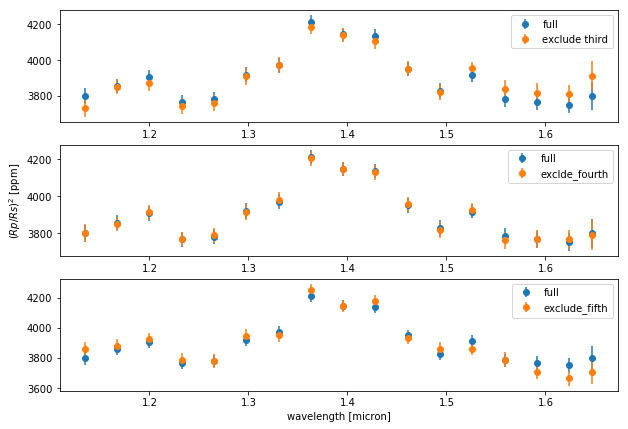

In [51]:
fig,axs=plt.subplots(3,1,figsize=(10,7))
w,r0,r0_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_lmfit_full.txt',unpack=True)

w,r1,r1_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_lmfit_third.txt',unpack=True)

w,r2,r2_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_lmfit_fourth.txt',unpack=True)

w,r3,r3_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_lmfit_fifth.txt',unpack=True)


axs[0].errorbar(w,r0*1e6,yerr=r0_err*1e6,ls='none',marker='o',label='full')
axs[1].errorbar(w,r0*1e6,yerr=r0_err*1e6,ls='none',marker='o',label='full')
axs[2].errorbar(w,r0*1e6,yerr=r0_err*1e6,ls='none',marker='o',label='full')
axs[0].errorbar(w,r1*1e6,yerr=r1_err*1e6,ls='none',marker='o',label='exclude third')
axs[1].errorbar(w,r2*1e6,yerr=r2_err*1e6,ls='none',marker='o',label='exclde_fourth')
axs[2].errorbar(w,r3*1e6,yerr=r3_err*1e6,ls='none',marker='o',label='exclude_fifth')
#plt.errorbar(bins_avg_wave,(Rad**2)*1e6,yerr=(Rad_err*Rad*2)*1e6,xerr=bins_std_wave,ls='none',marker='.',ms=10)
#plt.plot(bins_avg_wave,(Rad**2)*1e6,ls='none',marker='.',ms=10)
axs[1].set_ylabel(r'$(Rp/Rs)^{2}$ [ppm]')
plt.xlabel('wavelength [micron]')
#plt.title('V1298 b spectrum')
#np.savetxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_spectra_emcee_new.txt',np.column_stack((bins_avg_wave,bins_std_wave,Rad**2,2*Rad*Rad_err)))
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/V1298_common_mode_spectra.pdf',format='pdf')
print (Rad**2,2*Rad_err*Rad)
print (Res/168,np.mean(Res/168))
print (np.mean((Rad_err*Rad*2)*1e6))
axs[0].legend()
axs[1].legend()
axs[2].legend()

In [20]:
#plt.errorbar(bins_avg_wave,(Rad**2)*1e6,yerr=(Rad_err*Rad*2)*1e6,ls='none',marker='.',ms=10)
#plt.ylabel(r'$(Rp/Rs)^{2}$ [ppm]')
#plt.xlabel('wavelength [micron]')
#plt.title('V1298 b spectrum')
#np.savetxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_spectra_lmfit.txt',np.column_stack((bins_avg_wave,Rad**2,2*Rad*Rad_err)))
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/V1298_common_mode_spectra.pdf',format='pdf')
print (Rad**2,Rad_err)
#print (Res/168,np.mean(Res/168))
#print (np.mean((Rad_err*Rad*2)*1e6))

(array([0.00408824, 0.00412094, 0.00420126, 0.00407094, 0.00407885,
       0.00418867, 0.00427363, 0.00450159, 0.00445243, 0.00445105,
       0.00423307, 0.00414028, 0.00417679, 0.00402375, 0.00403288,
       0.00400604, 0.00404774]), array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None], dtype=object))


In [34]:
#print (max(Rad))
G=6.67e-11
T=677
mu=2.2*1.66e-27
k=1.38e-23
Rs=1.314*696340
Rs_err=0.05*696340
Rp=Rad[8]*Rs
Rp_err=((Rad_err[8]/Rad[8])+(Rs_err/Rs))*Rp
H=0.33*(Rad[8]-Rad[0])*Rs
H_err=(((Rad_err[8]+Rad_err[0])/(Rad[8]-Rad[0]))+(Rs_err/Rs))*H
Mj=5.972e24
Mp=1000*(k*T/(mu*G))*Rp**2/H/Mj
Mp_err=((2*Rp_err/Rp)+(H_err/H))*Mp
#print (max(Rad)-min(Rad),H)
#print (21.9*5.972e24/Mj)
print (Mp,Mp_err,H)

(26.863163443380067, 9.83645544216702, 829.7661150830512)


17
[0.62935419 0.61447428 0.55824801 0.61147647 0.59056548 0.58884484
 0.58503297 0.5588397  0.58160101 0.58957738 0.59592907 0.53292665
 0.5858487  0.6034443  0.53348831 0.58032743 0.59006499]
(array([0.59804936, 0.58858121, 0.53083121, 0.58525508, 0.5628792 ,
       0.5606891 , 0.55821843, 0.53408116, 0.55733766, 0.56544263,
       0.57025934, 0.50493811, 0.56097698, 0.57196869, 0.49466316,
       0.54131607, 0.52988435]), array([0.03130483, 0.02589306, 0.0274168 , 0.02622139, 0.02768628,
       0.02815573, 0.02681454, 0.02475854, 0.02426336, 0.02413475,
       0.02566973, 0.02798853, 0.02487173, 0.03147561, 0.03882516,
       0.03901136, 0.06018064]))


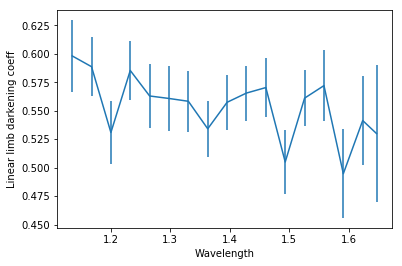

In [95]:
plt.errorbar(bins_avg_wave,u_limb,yerr=u_limb_err)
plt.ylabel('Linear limb darkening coeff')
plt.xlabel('Wavelength')
print (len(u_limb))
print (u_limb+u_limb_err)
print (u_limb,u_limb_err)
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/V1298_common_mode_limbdarkening.pdf',format='pdf')

Text(0,0.5,'Median residual')

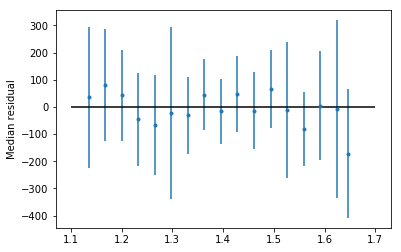

In [25]:
plt.errorbar(bins_avg_wave,res_median,yerr=res_dev,ls='none',marker='.')
plt.hlines(0.0,1.7,1.1)
plt.ylabel('Median residual')

In [42]:
from scipy import stats
from statsmodels import robust
#stats.mad(x)

In [96]:
import matplotlib.pyplot as plt
Nr_pixels = 7
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

excl_indices=[]
excl_indices.append(135)

lis1=[118,119,120,121,122,123,124,125]
inc=np.ones(len(z),dtype=bool)
forward=Planet_LC.Forward
excl_indices.extend(lis1)
inc[excl_indices]=False
import lmfit
Rad_up=np.array([])
Rad_err_up=np.array([])
#Rad_r=np.array([])
#Rad_err_r=np.array([])
#u_limb=[]
#u_limb_err=[]
for i in range (N_bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, bins[i], average=True, weighted=False)
    Binned_LC=Binned_LC/imagesize
    Binned_LC_err=Binned_LC_err/imagesize
  #  Binned_LC=Binned_LC/np.max(Binned_LC)
  #  Binned_LC_err=Binned_LC_err/np.max(Binned_LC)
    data_f=Binned_LC[Excl_first][inc]/z[inc]
    times_f=sorted_times[Excl_first][inc]+min(Times_org)
    
 #   data_r=Binned_LC[Excl_first][~forward*inc]/z[~forward*inc]
 #   times_r=sorted_times[Excl_first][~forward*inc]+min(Times_org)
#import lmfit
    params=lmfit.Parameters()
    params.add('t0',value=Planet_LC.sp_params.t0,vary=False)

    params.add('per',value=Planet_LC.sp_params.per,vary=False)
    params.add('aRs',value=opt[5],vary=False)
    params.add('depth',value=opt[0],max=0.1,min=0.0)
    params.add('inc',value=Planet_LC.sp_params.inc,vary=False)
    params.add('ecc',value=Planet_LC.sp_params.ecc,vary=False)
    params.add('w',value=Planet_LC.sp_params.w,vary=False)
    params.add('u1',value=u_limb[i]+u_limb_err[i],vary=False)
    params.add('c1',value=1.0,min=0.6,max=1.2)
    params.add('c2',value=0.0,max=1,min=-1)
    params.add('t_mid',value=0.0,max=0.1,min=-0.1)
    out_up=lmfit.minimize(residual,params,args=(times_f,data_f,Binned_LC_err[Excl_first][inc],z[inc],z_err[inc]),method='leastsq')
#    out_r=lmfit.minimize(residual,params,args=(times_r,data_r),method='leastsq')
    lmfit.report_fit(out_up)
    opt_up = [out_up.params[key].value for key in out_up.params.keys()]
    err_up = [out_up.params[key].stderr for key in out_up.params.keys()]
 #   u_limb.append(opt_f[7])
  #  u_limb_err.append(err_f[7])
 #   opt_r = [out_r.params[key].value for key in out_r.params.keys()]
 #   err_r = [out_r.params[key].stderr for key in out_r.params.keys()]
#print (opt)
    expected_up=transit_model(times_f,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
#    expected_r=transit_model(times_r,t0=opt_r[0],per=opt_r[1],aRs=opt_r[2],depth=opt_r[3],inc=opt_r[4],ecc=opt_r[5],w=opt_r[6]
#                            ,u1=opt_r[7],c1=opt_r[8],c2=opt_r[9],t_mid=opt_r[10])
#    print ('Residual in ppm',(np.sqrt(sum((data_f-expected_f)**2/expected_f**2))/len(data_f))*1e6)
    res_f=data_f-expected_up
    Rad_up=np.append(Rad_up,opt_up[3])
    Rad_err_up=np.append(Rad_err_up,err_up[3])
 #   res_r=data_r-expected_r
                              
    print ('Res in ppm ',np.sqrt(np.sum(res_f**2/data_f**2)/len(data_f))*1e6)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 153
    # variables        = 4
    chi-square         = 0.00224050
    reduced chi-square = 1.5037e-05
    Akaike info crit   = -1695.11862
    Bayesian info crit = -1682.99687
[[Variables]]
    t0:     2459095 (fixed)
    per:    24.14111 (fixed)
    aRs:    27.40165 (fixed)
    depth:  0.06102323 +/- 2.9588e-04 (0.48%) (init = 0.003870831)
    inc:    89.517 (fixed)
    ecc:    0.087 (fixed)
    w:      85 (fixed)
    u1:     0.6293542 (fixed)
    c1:     0.85801113 +/- 3.7108e-05 (0.00%) (init = 1)
    c2:     8.4998e-04 +/- 1.0084e-04 (11.86%) (init = 0)
    t_mid:  0.02171964 +/- 3.2926e-04 (1.52%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2)    = -0.819
    C(depth, c1) =  0.565
    C(depth, c2) = -0.256
    C(c2, t_mid) = -0.252
    C(c1, t_mid) =  0.173
('Res in ppm ', 25897.43425728764)
[[Fit Statistics]]
    # fitting method   = leastsq
 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 153
    # variables        = 4
    chi-square         = 0.00241536
    reduced chi-square = 1.6210e-05
    Akaike info crit   = -1683.62050
    Bayesian info crit = -1671.49874
[[Variables]]
    t0:     2459095 (fixed)
    per:    24.14111 (fixed)
    aRs:    27.40165 (fixed)
    depth:  0.06046500 +/- 4.8622e-04 (0.80%) (init = 0.003870831)
    inc:    89.517 (fixed)
    ecc:    0.087 (fixed)
    w:      85 (fixed)
    u1:     0.590065 (fixed)
    c1:     0.83629138 +/- 5.7888e-05 (0.01%) (init = 1)
    c2:    -0.00114622 +/- 1.5762e-04 (13.75%) (init = 0)
    t_mid:  0.01991273 +/- 5.5275e-04 (2.78%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2)    = -0.812
    C(depth, c1) =  0.561
    C(depth, c2) = -0.241
    C(c2, t_mid) = -0.236
    C(c1, t_mid) =  0.142
('Res in ppm ', 373.83185140670247)


In [97]:
import matplotlib.pyplot as plt
Nr_pixels = 7
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

excl_indices=[]
excl_indices.append(135)

lis1=[118,119,120,121,122,123,124,125]
inc=np.ones(len(z),dtype=bool)
forward=Planet_LC.Forward
excl_indices.extend(lis1)
inc[excl_indices]=False
import lmfit
Rad_low=np.array([])
Rad_err_low=np.array([])
#Rad_r=np.array([])
#Rad_err_r=np.array([])
#u_limb=[]
#u_limb_err=[]
for i in range (N_bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, bins[i], average=True, weighted=False)
    Binned_LC=Binned_LC/imagesize
    Binned_LC_err=Binned_LC_err/imagesize
  #  Binned_LC=Binned_LC/np.max(Binned_LC)
  #  Binned_LC_err=Binned_LC_err/np.max(Binned_LC)
    data_f=Binned_LC[Excl_first][inc]/z[inc]
    times_f=sorted_times[Excl_first][inc]+min(Times_org)
    
 #   data_r=Binned_LC[Excl_first][~forward*inc]/z[~forward*inc]
 #   times_r=sorted_times[Excl_first][~forward*inc]+min(Times_org)
#import lmfit
    params=lmfit.Parameters()
    params.add('t0',value=Planet_LC.sp_params.t0,vary=False)

    params.add('per',value=Planet_LC.sp_params.per,vary=False)
    params.add('aRs',value=opt[5],vary=False)
    params.add('depth',value=opt[0],max=0.1,min=0.0)
    params.add('inc',value=Planet_LC.sp_params.inc,vary=False)
    params.add('ecc',value=Planet_LC.sp_params.ecc,vary=False)
    params.add('w',value=Planet_LC.sp_params.w,vary=False)
    params.add('u1',value=u_limb[i]-u_limb_err[i],vary=False)
    params.add('c1',value=1.0,min=0.6,max=1.2)
    params.add('c2',value=0.0,max=1,min=-1)
    params.add('t_mid',value=0.0,max=0.1,min=-0.1)
    out_up=lmfit.minimize(residual,params,args=(times_f,data_f,Binned_LC_err[Excl_first][inc],z[inc],z_err[inc]),method='leastsq')
#    out_r=lmfit.minimize(residual,params,args=(times_r,data_r),method='leastsq')
    lmfit.report_fit(out_up)
    opt_up = [out_up.params[key].value for key in out_up.params.keys()]
    err_up = [out_up.params[key].stderr for key in out_up.params.keys()]
 #   u_limb.append(opt_f[7])
  #  u_limb_err.append(err_f[7])
 #   opt_r = [out_r.params[key].value for key in out_r.params.keys()]
 #   err_r = [out_r.params[key].stderr for key in out_r.params.keys()]
#print (opt)
    expected_up=transit_model(times_f,t0=opt_f[0],per=opt_f[1],aRs=opt_f[2],depth=opt_f[3],inc=opt_f[4],ecc=opt_f[5],w=opt_f[6]
                            ,u1=opt_f[7],c1=opt_f[8],c2=opt_f[9],t_mid=opt_f[10])
#    expected_r=transit_model(times_r,t0=opt_r[0],per=opt_r[1],aRs=opt_r[2],depth=opt_r[3],inc=opt_r[4],ecc=opt_r[5],w=opt_r[6]
#                            ,u1=opt_r[7],c1=opt_r[8],c2=opt_r[9],t_mid=opt_r[10])
#    print ('Residual in ppm',(np.sqrt(sum((data_f-expected_f)**2/expected_f**2))/len(data_f))*1e6)
    res_f=data_f-expected_up
    Rad_low=np.append(Rad_low,opt_up[3])
    Rad_err_low=np.append(Rad_err_low,err_up[3])
 #   res_r=data_r-expected_r
                              
    print ('Res in ppm ',np.sqrt(np.sum(res_f**2/data_f**2)/len(data_f))*1e6)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 153
    # variables        = 4
    chi-square         = 0.00224413
    reduced chi-square = 1.5061e-05
    Akaike info crit   = -1694.87102
    Bayesian info crit = -1682.74927
[[Variables]]
    t0:     2459095 (fixed)
    per:    24.14111 (fixed)
    aRs:    27.40165 (fixed)
    depth:  0.06158535 +/- 2.9914e-04 (0.49%) (init = 0.003870831)
    inc:    89.517 (fixed)
    ecc:    0.087 (fixed)
    w:      85 (fixed)
    u1:     0.5667445 (fixed)
    c1:     0.85802614 +/- 3.7265e-05 (0.00%) (init = 1)
    c2:     8.3392e-04 +/- 1.0097e-04 (12.11%) (init = 0)
    t_mid:  0.02189923 +/- 3.0880e-04 (1.41%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2)    = -0.819
    C(depth, c1) =  0.569
    C(depth, c2) = -0.259
    C(c2, t_mid) = -0.252
    C(c1, t_mid) =  0.178
('Res in ppm ', 25897.43425728764)
[[Fit Statistics]]
    # fitting method   = leastsq
 

[ 69.62411879  57.19921221  55.81131905  55.65576595  59.24286425
  62.07203567  60.08269471  56.69197118  54.12684602  56.33058597
  57.69921425  58.85305901  49.80271411  59.92652664  67.73995913
  69.3761655  109.38956118]


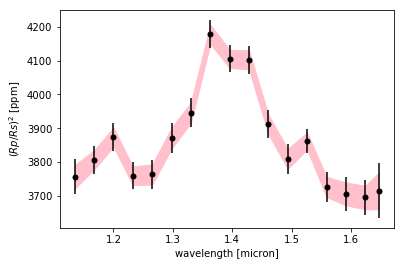

In [61]:
plt.errorbar(bins_avg_wave,(Rad**2)*1e6,yerr=(Rad_err*Rad*2)*1e6,ls='none',marker='.',ms=10,color='black')
#plt.plot(bins_avg_wave,(Rad_up**2)*1e6,ls='none',marker='.',ms=10)
#plt.plot(bins_avg_wave,(Rad_low**2)*1e6,ls='none',marker='.',ms=10)
plt.fill_between(bins_avg_wave,(Rad_up**2)*1e6,(Rad_low**2)*1e6,color='pink')
print ((Rad_low**2)*1e6-(Rad_up**2)*1e6)
plt.ylabel(r'$(Rp/Rs)^{2}$ [ppm]')
plt.xlabel('wavelength [micron]')
plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/V1298_common_mode_limb_contour.pdf',format='pdf')





17


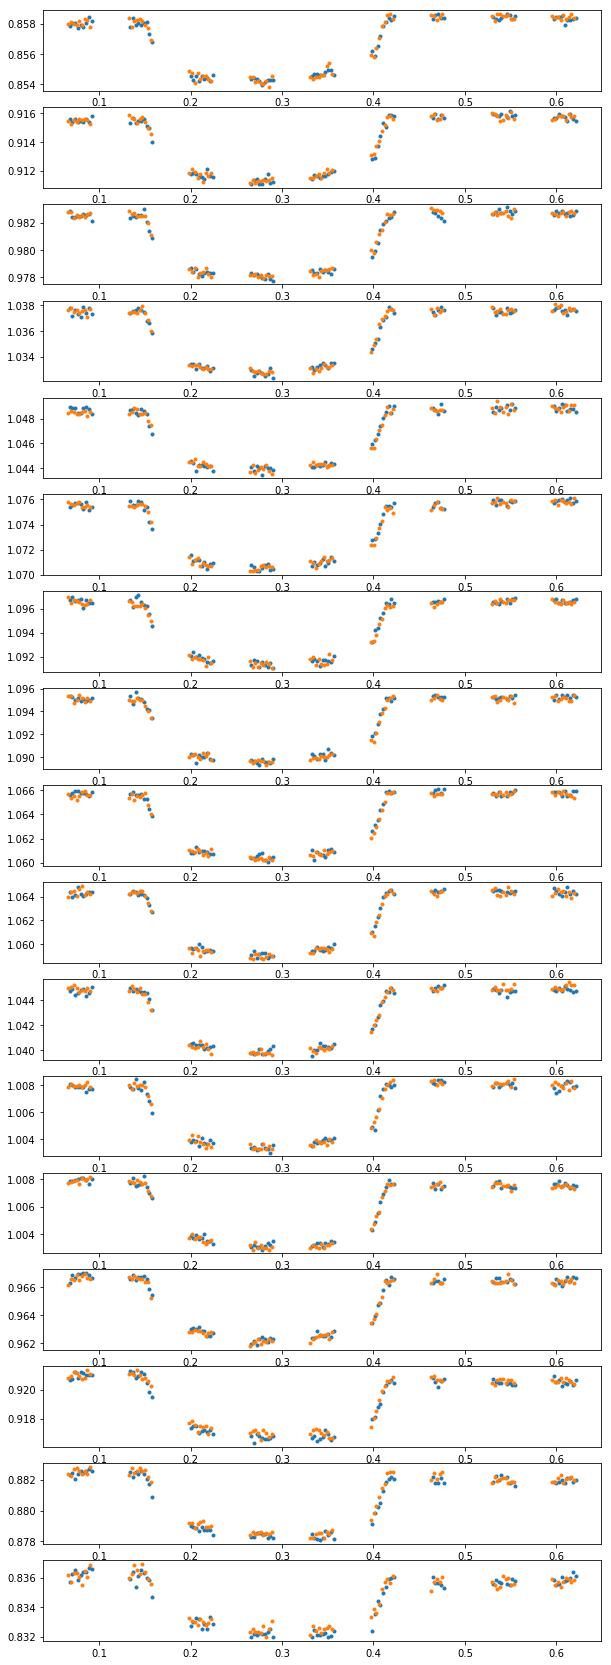

In [111]:
Nr_pixels = 7
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

print (N_bins)
excl_indices=[]
excl_indices.append(135)

lis1=[118,119,120,121,122,123,124,125]
inc=np.ones(len(z),dtype=bool)
excl_indices.extend(lis1)
inc[excl_indices]=False
fig,axs=plt.subplots(N_bins,1,figsize=(10,30))
for i in range(len(bins)):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, bins[i], average=True, weighted=False)
    Binned_LC=Binned_LC/imagesize
    Binned_LC_err=Binned_LC_err/imagesize
    Binned_LC=Binned_LC
    Binned_LC_err=Binned_LC_err
    axs[i].plot(sorted_times[Excl_first][forward*inc],Binned_LC[Excl_first][forward*inc]/z[forward*inc],ls='none',marker='.')
    axs[i].plot(sorted_times[Excl_first][~forward*inc],Binned_LC[Excl_first][~forward*inc]/z[~forward*inc],ls='none',marker='.')
#plt.hlines(172.4,0,0.65)

In [28]:
def transit_model_emcee(time,t0,per,aRs,inc,ecc,w,depth,u1,c1,c2,t_mid):

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = t0                        #time of inferior conjunction
    params.per = per                       #orbital period
    params.rp =   depth                     #planet radius (in units of stellar radii)
    params.a = aRs                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = ecc                       #eccentricity
    params.w = w                        #longitude of periastron (in degrees)
    params.limb_dark = "linear"        #limb darkening model
    params.u = [u1]      #limb darkening coefficients [u1, u2, u3, u4]

    t = time+t_mid  #times at which to calculate light curve
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params) 
    flux=flux*(c1+c2*(t-t[0]))
    return flux


def lnlike(theta,data,time,t0,per,aRs,inc,ecc,w,flux_err):
#     P,T,R=np.loadtxt('final_temp_pressure_profile.txt',unpack=True)
#     lmb=x
#     print 'theta',theta
     chisq=-0.5*sum(((transit_model_emcee(time,t0,per,aRs,inc,ecc,w,*theta)-data)**2)/flux_err**2)
#     print chisq
     return chisq


def lnprior(theta):
    f = theta
    flag=0
    for i in range(len(f)):
        if (f[0]<0.05 or f[0]>0.08 or f[1]<0.3 or f[1]>0.8 or f[2]>1.2 or f[2]<0.8 or f[3]>0.01 or f[3]<-0.01
           or f[4]>0.1 or f[4]<0.001):
            flag=1
    if (flag==0):
        return 0.0
    else:
        return -np.inf
    
    
    
def lnprob(theta,data,time,t0,per,aRs,inc,ecc,w,flux_err):
    lp = lnprior(theta)
    if (lp== -np.inf):
        
        return -np.inf
    else:
        return lnlike(theta,data,time,t0,per,aRs,inc,ecc,w,flux_err)

'''    
ndim = 5
nwalkers =20
p0=[]

for i in range(nwalkers):
            flag=0
            while (flag==0):
            
                f0=np.random.normal(0.003,1e-5)
                f1=np.random.uniform(0.4,0.7)
                f2=np.random.uniform(0.0,1.0)
                f3=np.random.uniform(-0.5,0.5)
                f4=np.random.uniform(-0.05,0.05)
              #  f5=np.random.uniform(0.0,0.05)
               
                
         #       f3=np.random.uniform(0.05,0.6)
#                f6=1-f1-f2-f0-f3-f4-f5
           #     if (f6<1.0 and f6>0.0):
           #         flag=1
            f=np.array([f0,f1,f2,f3,f4])
#            print f
            p0.append(f)
print p0  


'''

'    \nndim = 5\nnwalkers =20\np0=[]\n\nfor i in range(nwalkers):\n            flag=0\n            while (flag==0):\n            \n                f0=np.random.normal(0.003,1e-5)\n                f1=np.random.uniform(0.4,0.7)\n                f2=np.random.uniform(0.0,1.0)\n                f3=np.random.uniform(-0.5,0.5)\n                f4=np.random.uniform(-0.05,0.05)\n              #  f5=np.random.uniform(0.0,0.05)\n               \n                \n         #       f3=np.random.uniform(0.05,0.6)\n#                f6=1-f1-f2-f0-f3-f4-f5\n           #     if (f6<1.0 and f6>0.0):\n           #         flag=1\n            f=np.array([f0,f1,f2,f3,f4])\n#            print f\n            p0.append(f)\nprint p0  \n\n\n'

[0.00027348 0.00027355 0.00027347 0.00027365 0.00027348 0.00027367
 0.00027353 0.00027376 0.00027357 0.00027363 0.00027337 0.00027351
 0.00027337 0.00027352 0.00027311 0.00027342 0.00027323 0.00027336
 0.0002733  0.00027348 0.00027324 0.00027346 0.00027321 0.00027333
 0.00027321 0.00027335 0.00027302 0.00027306 0.00027268 0.00027285
 0.00027269 0.0002728  0.00027268 0.00027272 0.00027265 0.00027281
 0.00027254 0.00027276 0.00027254 0.00027276 0.0002725  0.00027273
 0.00027266 0.0002728  0.00027255 0.00027266 0.00027234 0.00027256
 0.0002723  0.0002725  0.00027225 0.00027244 0.00027224 0.00027238
 0.00027221 0.00027247 0.00027222 0.00027235 0.00027224 0.0002724
 0.00027227 0.00027253 0.00027216 0.00027355 0.00027338 0.00027353
 0.00027332 0.00027345 0.00027323 0.00027339 0.0002732  0.00027333
 0.00027315 0.00027338 0.00027321 0.00027336 0.00027317 0.00027345
 0.00027325 0.00027339 0.0002733  0.00027279 0.00027229 0.00027264
 0.00027236 0.00027253 0.00027249 0.00027264 0.00027249 0.00027

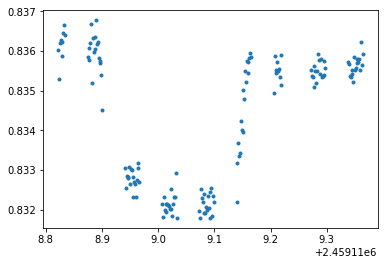

In [133]:
ndim = 5
nwalkers =50
p0=[]

for i in range(nwalkers):
            
    f0=np.random.uniform(0.05,0.07)
    f1=np.random.uniform(0.4,0.7)
    f2=np.random.uniform(0.8,1.2)
    f3=np.random.uniform(-0.01,0.01)
    f4=np.random.uniform(0.01,0.03)
 #   f4=np.random.uniform(0.0,0.1)
#    f4=np.random.uniform(-0.05,0.05)
    f=np.array([f0,f1,f2,f3,f4])
    p0.append(f)
              #  f5=np.random.uniform(0.0,0.05)
               
                
         #       f3=np.random.uniform(0.05,0.6)
#                f6=1-f1-f2-f0-f3-f4-f5
           #     if (f6<1.0 and f6>0.0):
           #         flag=1
          #  f=np.array([f0,f1,f2,f3,f4])
#            print f
         #   p0.append(f)
#print p0  


Nr_pixels = 7
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

excl_indices=[]
excl_indices.append(135)

lis1=[0,1,2,3,4,5,6,7,8,118,119,120,121,122,123,124,125]
inc=np.ones(len(z),dtype=bool)
forward=Planet_LC.Forward
excl_indices.extend(lis1)
inc[excl_indices]=False


i=16
Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, bins[i], average=True, weighted=False)
Binned_LC=Binned_LC/imagesize
Binned_LC_err=Binned_LC_err/imagesize
  #  Binned_LC=Binned_LC/np.max(Binned_LC)
  #  Binned_LC_err=Binned_LC_err/np.max(Binned_LC)
data_f=Binned_LC[Excl_first][inc]/z[inc]
times_f=sorted_times[Excl_first][inc]+min(Times_org)
#flux_err=
flux_err=(Binned_LC_err[Excl_first][inc]/Binned_LC[Excl_first][inc])*data_f+(z_err[inc]/z[inc])*data_f
print (flux_err)
print (N_bins,bins_avg_wave,i)
plt.plot(times_f,data_f,ls='none',marker='.')

In [134]:
per=Planet_LC.sp_params.per
aRs=opt[5]
inc=Planet_LC.sp_params.inc
ecc=Planet_LC.sp_params.ecc
t0=Planet_LC.sp_params.t0
w=Planet_LC.sp_params.w
t_mid=opt[2]
import emcee
import corner


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data_f,times_f,t0,per,aRs,inc,ecc,w,flux_err),threads=8)

In [135]:
print("Running burn-in...")
p0, prob0, state0 = sampler.run_mcmc(p0,10000)
print p0
sampler.reset()

Running burn-in...
[[ 0.06155755  0.56180664  0.83620983 -0.00141783  0.01668865]
 [ 0.06253733  0.50958306  0.83627355 -0.00159063  0.01843523]
 [ 0.05984026  0.58139969  0.83603664 -0.00112926  0.01757373]
 [ 0.06160165  0.50923359  0.83629088 -0.00152199  0.01707441]
 [ 0.06148176  0.55332458  0.8360925  -0.00110099  0.01692091]
 [ 0.06131077  0.5244277   0.83619255 -0.0014775   0.01736687]
 [ 0.06159714  0.49322183  0.83618607 -0.00123883  0.01716949]
 [ 0.0613289   0.49918416  0.83616131 -0.00126705  0.01695679]
 [ 0.06238072  0.4398865   0.83627932 -0.00145766  0.01733026]
 [ 0.06245501  0.46571383  0.83627671 -0.0016049   0.01835204]
 [ 0.06219024  0.50064035  0.83620803 -0.00139056  0.01755528]
 [ 0.06074998  0.54290898  0.83611924 -0.00126508  0.01793895]
 [ 0.06177487  0.51283541  0.83616187 -0.00124468  0.01740558]
 [ 0.06199788  0.4415247   0.83629733 -0.00157225  0.01757021]
 [ 0.06207727  0.42946865  0.83626034 -0.00159185  0.01734483]
 [ 0.06071124  0.50704604  0.8361062

In [136]:
print("Running production...")
pos, prob, state = sampler.run_mcmc(p0,10000)
print 'posterior',pos
samples = sampler.flatchain
print 'samples',samples
print 'prob',prob

Running production...
posterior [[ 0.06080098  0.53092709  0.83621754 -0.00138403  0.0169856 ]
 [ 0.06049946  0.55633971  0.83607249 -0.00105792  0.01720055]
 [ 0.06099116  0.47589453  0.83609939 -0.00113701  0.01793613]
 [ 0.06239561  0.51165286  0.83620319 -0.00136548  0.01804783]
 [ 0.06150745  0.57913289  0.83616755 -0.00122564  0.01737325]
 [ 0.06102486  0.55544742  0.83617705 -0.00140724  0.01713536]
 [ 0.06170556  0.4834939   0.83618174 -0.00136045  0.01777105]
 [ 0.06108671  0.59694983  0.8361747  -0.00124511  0.01685475]
 [ 0.06197309  0.50646201  0.83617379 -0.00138658  0.01744088]
 [ 0.06194047  0.48925663  0.83620159 -0.00136361  0.0176403 ]
 [ 0.06273141  0.47612666  0.8363173  -0.00155599  0.01775206]
 [ 0.06242388  0.47592229  0.83626132 -0.00140165  0.01754142]
 [ 0.0611427   0.52313331  0.83621126 -0.00144825  0.01805634]
 [ 0.06198771  0.48721488  0.8362622  -0.00150772  0.01768528]
 [ 0.06073342  0.56911571  0.83611747 -0.00123483  0.01689507]
 [ 0.06195447  0.509803

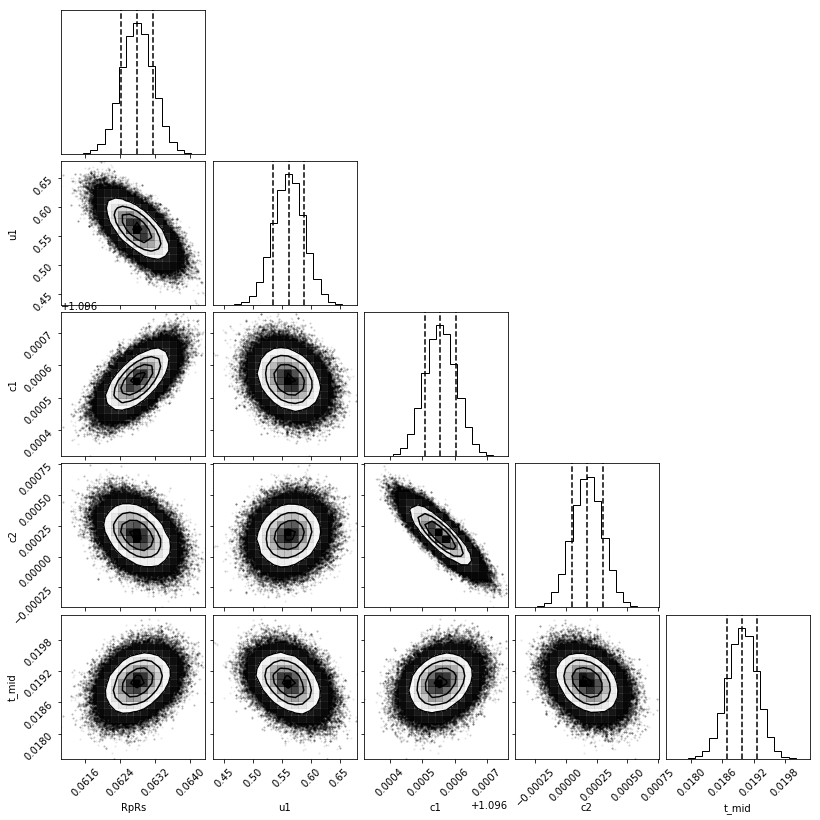

In [86]:
lab=['RpRs','u1','c1','c2','t_mid']
figure=corner.corner(samples,labels=lab,quantiles=[0.16,0.5,0.84],show_titles=False)
axes = np.array(figure.axes).reshape((ndim, ndim))
figure.show()
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/wavelength_posterior_1.65_.pdf',format='pdf')




In [137]:
#samples=result.flatchain
#samples1=samples[5000:]
for i in range(5):
    q=np.quantile(samples[:,i],[0.16,0.5,0.84])
    print (q[1],q[1]-q[0],q[2]-q[1])
#import pickle 

(0.06174336151235868, 0.0006032109583833933, 0.0005930327161138005)
(0.5137019636390363, 0.047586365241469086, 0.048061000327940695)
(0.8361972202032976, 5.912371671012995e-05, 5.8736520244795365e-05)
(-0.001356082008573426, 0.00015195664306888977, 0.0001539830143144369)
(0.017476918773671107, 0.0005057219412560737, 0.0004919296731246622)


In [57]:
args=[times_f,t0,per,aRs,inc,ecc,w,t_mid]
theta=[np.median(samples[:,0]),np.median(samples[:,1]),np.median(samples[:,2]),np.median(samples[:,3])]
#f_test=transit_model_emcee(args[0],args[1],args[2],args[3],args[4],args[5],args[6],args[7],theta[0],theta[1],theta[2],theta[3])
#print (*args)
#print ((samples[:,0]))
print (theta)
#plt.plot(times_f,f_test,ls='none',marker='.')
#plt.plot(times_f,data_f,ls='none',marker='.')
#print (f_test-data_f)
#print (flux_err)

#flux_err_new=(Binned_LC_err[Excl_first][inc]/Binned_LC[Excl_first][inc])*data_f+(z_err[inc]/z[inc])*data_f
#print (flux_err_new)
q=np.quantile(samples[:,0],[0.16,0.5,0.84])
#q1=np.quantile(samples[:,4],[0.16,0.5,0.84])
q2=np.quantile(samples[:,1],[0.16,0.5,0.84])
print (bins_avg_wave[0]  ,q[1]  ,q[2]-q[1])
print (bins_avg_wave[1],q2[1],q2[2]-q2[1])
#print (np.mean(samples[:,0]),np.std(samples[:,0]))

[0.062065768878490274, 0.5806829518345097, 0.9156894637089958, 0.0005475776086305176]
(1.1348153848454277, 0.062065768878490274, 0.0003906901970485918)
(1.1674116703739261, 0.5806829518345097, 0.02934267931673995)


1.838177524292262 0.14400000000000002
[[1.         0.22368759]
 [0.22368759 1.        ]]


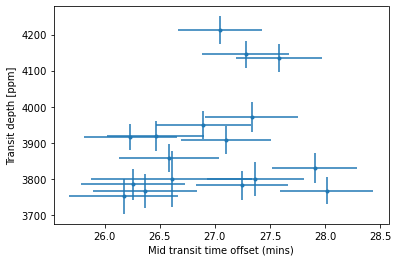

In [7]:
import numpy as np
import matplotlib.pyplot as plt
w,t,t_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/Mid_transit_times_hst.txt',unpack=True)
wave,wave_err,Rad,Rad_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_spectra_emcee_new.txt',skiprows=0,unpack=True)

plt.errorbar(t*24*60,Rad*1e6,yerr=Rad_err*1e6,xerr=t_err*24*60,ls='none',marker='.')
plt.xlabel('Mid transit time offset (mins)')
plt.ylabel('Transit depth [ppm]')
print ((max(t)-min(t))*24*60,0.0001*24*60)
print (np.corrcoef(t,Rad))

[0.00379928 0.00385735 0.00390708 0.00376746 0.00378207 0.00391894
 0.00397141 0.00421263 0.00414561 0.00413582 0.00395006 0.00382897
 0.00391558 0.0037846  0.00376684 0.0037516  0.00379966]
3.5313635986844627 0.2143338576899609
4.46909690501559 0.28350787907000247
0.33617822339963216
0.4312320844875197 0.43069405298107866


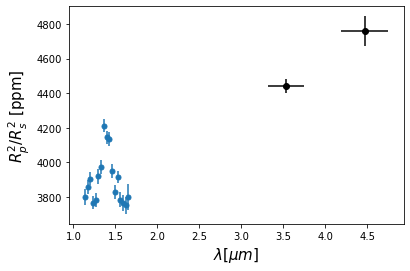

In [4]:
import numpy as np
import matplotlib.pyplot as plt
wave,wave_err,Rad,Rad_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_spectra_emcee_new.txt',skiprows=0,unpack=True)
#wave1,Rad1,Rad_err1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_spectra_lmfit.txt',unpack=True)
print (Rad)
plt.errorbar(wave,(Rad)*1e6,yerr=(Rad_err)*1e6,xerr=wave_err,ls='none',marker='.',ms=10)
#plt.errorbar(wave1,(Rad1)*1e6,yerr=(Rad_err1)*1e6,ls='none',marker='.',ms=10)
plt.xlabel(r'$\lambda [\mu m]$',fontsize=15)
plt.ylabel(r'$R_{p}^{2}/R_{s}^{2}$ [ppm]',fontsize=15)
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_emcee_spectra.pdf',format='pdf',bbox_inches='tight')
w_ch1,weight_ch1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/SpecResponse3.6Spitzer.txt',usecols=(0,1),unpack=True)
print (np.average(w_ch1,weights=weight_ch1),np.sqrt(np.cov(w_ch1, aweights=weight_ch1)))
w_ch2,weight_ch2=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/SpecResponse4.5Spitzer.txt',usecols=(0,1),unpack=True)
print (np.average(w_ch2,weights=weight_ch2),np.sqrt(np.cov(w_ch2, aweights=weight_ch2)))
print (np.mean((2*Rad*Rad_err)*1e6))
#print np.mean((Rad_err1)*1e6)
#print (len(Rad),len(Rad1))
w_spit,w_err_spit,rp_err_spit,rp_spit= np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/spitzer_rprs.txt',usecols=(0,1,2,3),unpack=True)
plt.errorbar(w_spit,(rp_spit**2)*1e6,yerr=(2*rp_spit*rp_err_spit)*1e6,xerr=w_err_spit,ls='none',marker='o',color='black')

print (np.sqrt(np.cov(w_ch2, aweights=np.ones(len(w_ch2)))),np.std(w_ch2))


[0.00379928 0.00385735 0.00390708 0.00376746 0.00378207 0.00391894
 0.00397141 0.00421263 0.00414561 0.00413582 0.00395006 0.00382897
 0.00391558 0.0037846  0.00376684 0.0037516  0.00379966]
dict_keys(['el', 'H', 'He', 'C', 'N', 'O', 'Na', 'K', 'H2', 'N2', 'O2', 'OH', 'HF', 'MgH', 'SiH', 'HCl', 'CO', 'NO', 'SiO', 'TiO', 'VO', 'HCN', 'H2CO', 'CH4', 'OCS', 'CO2', 'C2H2', 'C2H4', 'H2O', 'H2S', 'NH3', 'PH3', 'NO2', 'SO2', 'O3'])


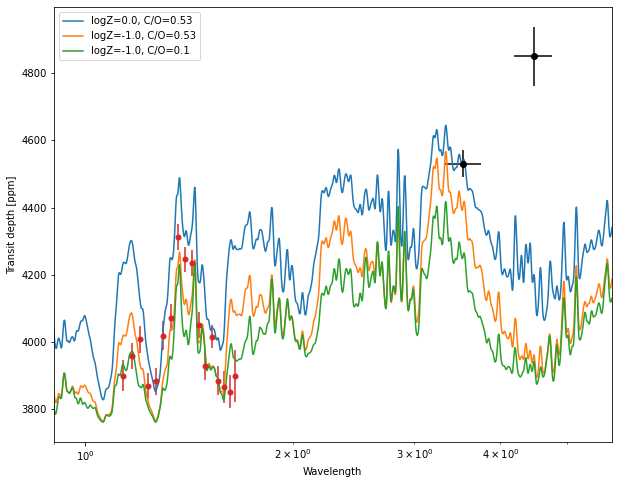

In [37]:
from platon.transit_depth_calculator import TransitDepthCalculator
from platon.constants import M_jup, R_jup, R_sun, M_earth
import matplotlib.pyplot as plt
# All inputs and outputs for PLATON are in SI
import numpy as np
Rs = 1.3 * R_sun
Mp = 26 * M_earth
Rp = 0.76 * R_jup
T = 670

# The initializer loads all data files.  Create a TransitDepthCalculator
# object and hold on to it
calculator = TransitDepthCalculator(method="xsec") #"ktables" for correlated k

# compute_depths is fast once data files are loaded
wavelengths, depths, info_dict = calculator.compute_depths(Rs, Mp, Rp, T, logZ=0.0, CO_ratio=0.53, full_output=True)
from scipy.ndimage import gaussian_filter
fig,ax=plt.subplots(1,1,figsize=(10,8))
plt.plot(wavelengths*1e6,gaussian_filter(depths*1e6,4),label='logZ=0.0, C/O=0.53')

wavelengths, depths, info_dict = calculator.compute_depths(Rs, Mp, Rp, T, logZ=-1.0, CO_ratio=0.53, full_output=True)
from scipy.ndimage import gaussian_filter
#fig,ax=plt.subplots(1,1)
plt.plot(wavelengths*1e6,gaussian_filter(depths*1e6,4),label='logZ=-1.0, C/O=0.53')


wavelengths, depths, info_dict = calculator.compute_depths(Rs, Mp, Rp, T, logZ=-1.0, CO_ratio=0.1, full_output=True)
from scipy.ndimage import gaussian_filter
#fig,ax=plt.subplots(1,1)
plt.plot(wavelengths*1e6,gaussian_filter(depths*1e6,4),label='logZ=-1.0, C/O=0.1')



plt.xlim(0.9,5.8)
wave,wave_err,Rad,Rad_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_spectra_emcee_new.txt',skiprows=0,unpack=True)
#wave1,Rad1,Rad_err1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_spectra_lmfit.txt',unpack=True)
print (Rad)
wfc3_offset=100
plt.errorbar(wave,(Rad)*1e6+wfc3_offset,yerr=(Rad_err)*1e6,xerr=wave_err,ls='none',marker='.',ms=10)
w_spit,w_err_spit,rp_spit,rp_err_spit= np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/spitzer_rprs.txt',usecols=(0,1,2,3),unpack=True)
plt.errorbar(w_spit,(rp_spit**2)*1e6,yerr=(2*rp_spit*rp_err_spit)*1e6,xerr=w_err_spit,ls='none',marker='o',color='black')
ax.set_xscale('log')
#ax.tick_params(which='major',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
#ax.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.legend(loc='upper left')
plt.xlabel('Wavelength')
plt.ylabel('Transit depth [ppm]')

from platon.abundance_getter import AbundanceGetter
getter = AbundanceGetter()
# Solar logZ and C/O ratio. Modify as required.
abundances = getter.get(np.log10(0.13), 0.53)

# Zero out CO.  (Note that if CO is a major component, you should probably
# renormalize the abundances of other species so that they add up to 1.)
#abundances["CO"] *= 0

# Set CH4 abundance to a constant throughout the atmosphere
#abundances["H2O"] *= 0
abundances["CH4"] *= 0
wavelength1,depths1=calculator.compute_depths(Rs,Mp,Rp, T,
logZ=None, CO_ratio=None, custom_abundances=abundances)
#plt.plot(wavelengths*1e6,gaussian_filter(depths1*1e6,5),label='logZ=-1,No CH4')
abundances = getter.get(0.0, 0.53)
abundances["H2O"] *= 0
wavelength1,depths1=calculator.compute_depths(Rs,Mp,Rp, T,
logZ=None, CO_ratio=None, custom_abundances=abundances)
#plt.plot(wavelengths*1e6,gaussian_filter(depths1*1e6,5),label='No H2O')
abundances = getter.get(np.log10(0.13), 0.53)

# Zero out CO.  (Note that if CO is a major component, you should probably
# renormalize the abundances of other species so that they add up to 1.)
#abundances["CO"] *= 0

# Set CH4 abundance to a constant throughout the atmosphere
abundances["H2O"] *= 0
#abundances["CH4"] += 1e-5
#wavelength1,depths1=calculator.compute_depths(Rs,Mp,Rp, T,
#logZ=None, CO_ratio=None, custom_abundances=abundances)
#plt.plot(wavelengths*1e6,gaussian_filter(depths1*1e6,5),label='logZ=-1,No H2O')

plt.legend(loc='upper left')
print (abundances.keys())
#print (abundances["H2O"])
kep_v1298=[0.65,0.25,0.0713,0.0021]

#ax.errorbar(kep_v1298[0],(kep_v1298[2]**2)*1e6,xerr=kep_v1298[1],yerr=2*kep_v1298[2]*kep_v1298[3]*1e6,marker='o',color='red')

21 21 21
22 22 22 22
374.30390123918943
251.1898228546803
775.0349310177178


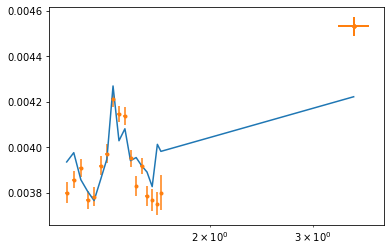

In [35]:
import numpy as np
Rs = 1.3 * R_sun
Mp = 26 * M_earth
Rp = 0.76 * R_jup
T = 670
print (len(wave),len(wave_err),len(Rad_err))
# The initializer loads all data files.  Create a TransitDepthCalculator
# object and hold on to it
calculator = TransitDepthCalculator(method="xsec") #"ktables" for correlated k
bins=[]
wave=np.append(wave,w_spit[0])
wave_err=np.append(wave_err,w_err_spit[0])
Rad_err=np.append(Rad_err,2*rp_spit[0]*rp_err_spit[0])
Rad=np.append(Rad,rp_spit[0]**2)

for i in range(len(wave)):
    bins.append([(wave[i]-wave_err[i])*1e-6,(wave[i]+wave_err[i])*1e-6])
calculator.change_wavelength_bins(bins)
# compute_depths is fast once data files are loaded
wavelengths, depths, info_dict = calculator.compute_depths(Rs, Mp, Rp, T, logZ=-1.0, CO_ratio=0.1, full_output=True)


#model1=np.interp(np.concatenate([wave,w_spit]),wavelengths*1e6,depths)
#plt.plot(np.concatenate([wave,w_spit]),model1)
#model1=np.interp(wave,wavelengths*1e6,depths)
#plt.plot(wave,model1*1e6,ls='none',marker='.')
#print (model1)
#plt.plot(wavelengths*1e6,gaussian_filter(depths1*1e6,3))
#plt.xlim(0.9,1.8)
print (len(wavelengths),len(wave),len(wave_err),len(Rad_err))
plt.semilogx(wavelengths*1e6,depths)
plt.errorbar(wave,Rad,xerr=wave_err,yerr=Rad_err,ls='none',marker='.')


def chi_sq(data,error,model):
    return np.sum(((data-model)/error)**2)

print (chi_sq(Rad,Rad_err,depths))

wavelengths, depths, info_dict = calculator.compute_depths(Rs, Mp, Rp, T, logZ=-1.0, CO_ratio=0.53, full_output=True)
print (chi_sq(Rad,Rad_err,depths))

wavelengths, depths, info_dict = calculator.compute_depths(Rs, Mp, Rp, T, logZ=0.0, CO_ratio=0.53, full_output=True)
print (chi_sq(Rad,Rad_err,depths))



In [17]:
np.concatenate([wave,w_spit])
print (wavelengths)

[3.00000000e-07 3.00299510e-07 3.00599320e-07 ... 2.99401875e-05
 2.99700788e-05 3.00000000e-05]


AttributeError: 'Series' object has no attribute 'to_numpy'

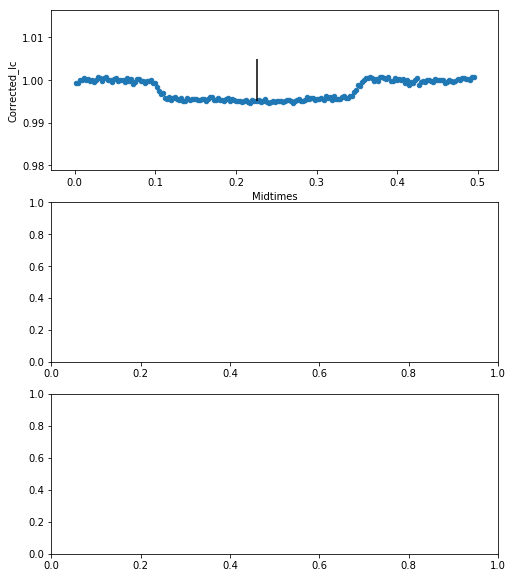

In [17]:
import pandas as pd
df=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/V1298_spitzer/circ_fixaincdavidetal/Lightcurves_V1298_ch2_r69997568_circ_fixaincdavidetal.csv')
#print (df)
df1=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/V1298_spitzer/circ_fixaincdavidetal/Lightcurves_V1298_ch1_r69997568_circ_fixaincdavidetal.csv')
#print (df)
fig,ax=plt.subplots(3,1,figsize=(8,10))
#df.plot(kind='scatter',x='Midtimes',y='Corrected_lc',ax=ax)
t=np.linspace(0.0,0.4516,1000)
#print (bins)
df=df.groupby(df.index // 100).mean()
#print (df)
#df.plot(kind='scatter',x='Midtimes',y='Corrected_lc',ax=ax[0])
#ax[0].set_ylim(0.992,1.0025)

import batman
params = batman.TransitParams()
params.t0 = 0.46                      #time of inferior conjunction
params.per = 24.139                      #orbital period
params.rp = np.sqrt(0.004)                      #planet radius (in units of stellar radii)
params.a = 27.                       #semi-major axis (in units of stellar radii)
params.inc = 89.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.2348]                #limb darkening coefficients [u1, u2]
params.limb_dark = "linear"       #limb darkening model

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve
#ax[0].plot(t,flux,color='black',label='4000 ppm')
params.rp = np.sqrt(0.0049)

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve
#ax[0].plot(t,flux,color='red',label='4900 ppm')
#ax[0].legend()
df1=df1.groupby(df1.index // 500).mean()
df1.plot(kind='scatter',x='Midtimes',y='Corrected_lc',ax=ax[0])
params.u=[0.19]
params.rp=np.sqrt(0.00475)
params.t0=0.2265
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve
#ax[0].plot(t,flux,color='red',label='4900 ppm')
t0=2.2646e-01
ax[0].vlines(t0,0.995,1.005)
df1=df1.loc[df1['Midtimes']<2*t0]
#print (df1)
df2=df1.sort_values(by='Midtimes', ascending=False)
#print (df2)
data1=df1['Corrected_lc'].to_numpy()
data2=df2['Corrected_lc'].to_numpy()
time=df1['Midtimes'].to_numpy()
ax[1].plot(time,(data1-data2)*1e6,ls='none',marker='.')
ax[1].hlines(0.0,0,0.5,color='black')
#ax[2].set_xlim(t0,2.1*t0)
residue=(data1-data2)*1e6
slice1=residue[np.intersect1d(np.where(time>0.32)[0],np.where(time<0.37)[0])]
print (len(slice1))
slice2=residue[np.intersect1d(np.where(time>t0)[0],np.where(time<0.45)[0])]
print (len(slice2))

#ax[3].hist(slice1,bins=10)
ax[2].hist(slice2,bins=10,density=True)
ax[2].hist(slice1,bins=10,density=True)
ax[0].vlines(0.34,0.995,1.005)
ax[0].vlines(0.37,0.995,1.005)
#ax[1].vlines(0.41,0.995,1.005)
ax[1].set_ylabel('Difference')


In [71]:
np.intersect1d(np.where(time>0.3)[0],np.where(time<0.4)[0])
#np.where(time>0.3)[0]

array([119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158])

17
(array([0.00379928, 0.00385735, 0.00390708, 0.00376746, 0.00378207,
       0.00391894, 0.00397141, 0.00421263, 0.00414561, 0.00413582,
       0.00395006, 0.00382897, 0.00391558, 0.0037846 , 0.00376684,
       0.0037516 , 0.00379966]), array([4.70141339e-05, 3.88168214e-05, 3.93704849e-05, 3.86478207e-05,
       4.07122117e-05, 4.22248752e-05, 4.05090578e-05, 3.83149366e-05,
       3.69194876e-05, 3.87352610e-05, 3.85542825e-05, 4.19667931e-05,
       3.52559624e-05, 4.38825169e-05, 4.78127383e-05, 4.90002533e-05,
       7.72975860e-05]))


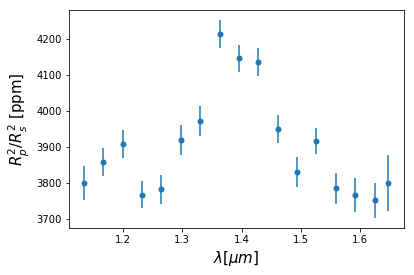

In [25]:
import numpy as np
wave,wave_err,Rad,Rad_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_spectra_emcee_new.txt',skiprows=0,unpack=True)
import matplotlib.pyplot as plt
plt.errorbar(wave,(Rad)*1e6,yerr=(Rad_err)*1e6,ls='none',marker='.',ms=10)
plt.xlabel(r'$\lambda [\mu m]$',fontsize=15)
plt.ylabel(r'$R_{p}^{2}/R_{s}^{2}$ [ppm]',fontsize=15)
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_emcee_spectra.pdf',format='pdf',bbox_inches='tight')

#print np.mean((2*Rad*Rad_err)*1e6)
print (len(wave))
print (Rad,Rad_err)

0.417076250357806


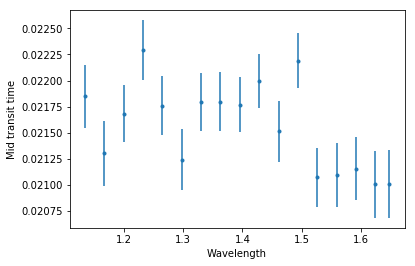

In [27]:
wave,mid_time,time_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_taub_emcee_time_free.txt',usecols=((0,3,4)),unpack=True)


plt.errorbar(wave,mid_time,yerr=time_err,ls='none',marker='.')
plt.ylabel('Mid transit time')
plt.xlabel('Wavelength')
print (np.mean(time_err)*24*60)

(array([-0.10402428,  0.70211963]), array([[ 0.00126048, -0.00174848],
       [-0.00174848,  0.00245433]]))
0.6293026345493746


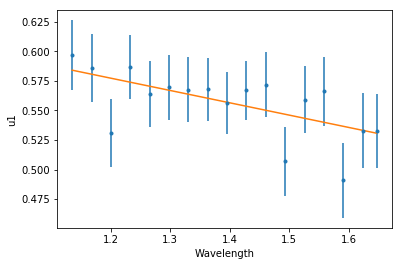

In [6]:
wave,lc,lc_err=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_emcee_limb_darkening.txt',usecols=((0,1,2)),unpack=True)

plt.errorbar(wave,lc,yerr=lc_err,ls='none',marker='.')
plt.ylabel('u1')
plt.xlabel('Wavelength')

def f(x,a,b):
    y=a*x+b
    return y
from scipy.optimize import curve_fit

popt,pcov=curve_fit(f,wave,lc,sigma=lc_err)
print (popt,pcov)

u1=f(0.7,*popt)
print (u1)
plt.plot(wave,f(wave,*popt))


[0.         0.03205707 0.06411414 0.0961712  0.12822827 0.16028534
 0.19234241 0.22439948 0.25645654 0.28851361 0.32057068 0.35262775
 0.38468481 0.41674188 0.44879895 0.48085602 0.51291309 0.54497015
 0.57702722 0.60908429 0.64114136 0.67319843 0.70525549 0.73731256
 0.76936963 0.8014267  0.83348377 0.86554083 0.8975979  0.92965497
 0.96171204 0.9937691  1.02582617 1.05788324 1.08994031 1.12199738
 1.15405444 1.18611151 1.21816858 1.25022565 1.28228272 1.31433978
 1.34639685 1.37845392 1.41051099 1.44256806 1.47462512 1.50668219
 1.53873926 1.57079633]


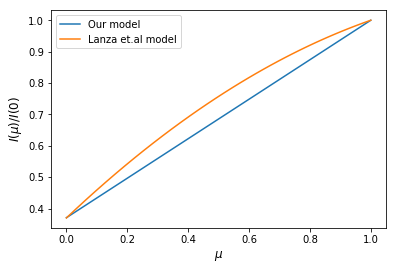

In [28]:
u1=f(0.7,*popt)
theta=np.linspace(0,np.pi/2)
print (theta)
mu=np.cos(theta)
i_lin=1-u1*(1-mu)
a= 0.370
b=0.919 
c= -0.289

i_quad=a+b*mu+c*mu**2

plt.plot (mu,i_lin,label='Our model')
plt.plot(mu,i_quad,label='Lanza et.al model')
plt.ylabel(r'$I(\mu) / I(0)$',fontsize=12)
plt.xlabel(r'$\mu$',fontsize=12)
plt.legend()

In [19]:
from hapi import *
fetch('H2O',1,1,7000,7100)
nu1,coef1 = absorptionCoefficient_Lorentz(SourceTables='H2O', Diluent={'air':1.0},Environment = {'p':1e-2,'T':670})

fetch('H2O',1,1,8900,9000)
nu2,coef2 = absorptionCoefficient_Lorentz(SourceTables='H2O', Diluent={'air':1.0},Environment = {'p':1e-2,'T':670})

n=np.log(np.mean(coef1)/np.mean(coef2))
print (n)
print (np.mean(coef1),np.mean(coef2))

HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to ./H2O.data
  65536 bytes written to ./H2O.data
  65536 bytes written to ./H2O.data
  65536 bytes written to ./H2O.data
  65536 bytes written to ./H2O.data
  65536 bytes written to ./H2O.data
Header written to ./H2O.header
END DOWNLOAD
                     Li

In [26]:
# mass calculation for b
G=6.67e-11
T=670
mu=2.33*1.66e-27
k=1.38e-23
Rs=1.314*696340
Rs_err=0.05*696340
Rad=np.sqrt(Rad)
Rad_err=Rad_err/(2*Rad)

Rp=0.0713*Rs
#n=3.05
Rp_err=0.002*Rs#np.sqrt((Rad_err[8]/Rad[8])**2+(Rs_err/Rs)**2)*Rp
H=(Rad[7]-Rad[0])*Rs/n
print (H)
H_err=np.sqrt(((Rad_err[7]+Rad_err[0])/(Rad[7]-Rad[0]))**2+(Rs_err/Rs)**2)*H
Mj=5.972e24
Mp=1000*(k*T/(mu*G))*Rp**2/H/Mj
Mp_err=np.sqrt((2*Rp_err/Rp)**2+(H_err/H)**2)*Mp
#print (max(Rad)-min(Rad),H)
#print (21.9*5.972e24/Mj)
print (Mp,Mp_err)
Rp=Rp*1e3
#print ((Mp*Mj)/(4*np.pi*Rp**3/3),'kg/m3',Rp)
from  astropy import units
me=units.M_earth
me=me.to(units.kg)
re=units.Rearth
re=re.to(units.m)
rho=Mp*me/(4*np.pi*(Rp)**3/3)*1e-3
err_rho=np.sqrt((Mp_err/Mp)**2+3*(Rp_err*1e3/Rp)**2)*rho
print (rho,err_rho)
#print (Rp/(H*1e3),Rp/1e3,H)
#print (me)
#print (Rad)

1213.1012446458826
(21.0552147455243, 4.5884819990983186)
(0.10811816677610595, 0.02414022258224141)


In [2]:
# mass calculation for c


dt_max=0.018
P=24.14
j=1
x=dt_max*4.5*j/P
y=(1/x - 1)
print (26.88/y,y,x)

(0.09049752691300551, 297.0246913580247, 0.0033554266777133385)


In [44]:
from astropy import units
re=units.Rearth
re=re.to(units.m)
print (58591.33467653572*1e3/re)

9.186330517949816


In [45]:
import pandas as pd
df1=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/test.csv')
#print (list(df.columns))
#print (df['   M_b   '],df['  errup  '])
#print (df['   R_b  '],df['  errup .1'])
#M_b=df[['   M_b   ']].to_numpy()
#M_b_up=df[['  errup  ']].to_numpy()
df=df1.loc[df1['pl_masse']>0.0]
df=df.loc[df['pl_rade']>0.0]

35.94147304798467
['NGTS-9 b' 'TOI-201 b' 'K2-77 b' 'HATS-70 b' 'MASCARA-4 b' 'Kepler-74 b'
 'KELT-24 b' 'WASP-93 b' 'Kepler-289 d' 'Kepler-289 c' 'Kepler-289 b'
 'KELT-17 b' 'WTS-2 b' 'WASP-135 b' 'KELT-20 b' 'HR 2562 b' 'HAT-P-70 b'
 'Qatar-5 b' 'HATS-67 b' 'WASP-59 b' 'WASP-140 b' 'WASP-139 b'
 'WASP-132 b' 'Kepler-462 c' 'Kepler-462 b' 'Kepler-45 b' 'WASP-52 b'
 'HATS-55 b' 'Qatar-3 b' 'HATS-58 A b' 'Kepler-51 d' 'Kepler-51 c'
 'Kepler-51 b' 'KELT-9 b' 'Kepler-411 d' 'Kepler-411 c' 'Kepler-411 b'
 'Kepler-63 b' 'TOI-251 b' 'Qatar-4 b' 'GU Psc b' 'TOI-942 c' 'TOI-942 b'
 '2MASS J02192210-3925225 b' 'HR 8799 e' 'TYC 8998-760-1 c' 'HIP 65426 b'
 'K2-33 b' 'PDS 70 c' 'PDS 70 b' 'CFHTWIR-Oph 98 b' 'CT Cha b']
[9.21707000e+02 1.33488600e+02 4.10000700e+03 9.85273000e+02
 2.00220000e+02 1.64635940e+03 4.67210100e+02 4.00000000e+00
 1.32000000e+02 4.16357300e+02 3.55969600e+02 6.03877000e+02
 1.37302560e+03 4.60853500e+02 2.74276000e+02 7.75505200e+02
 3.71861100e+01 1.30310300e+02 1.60497

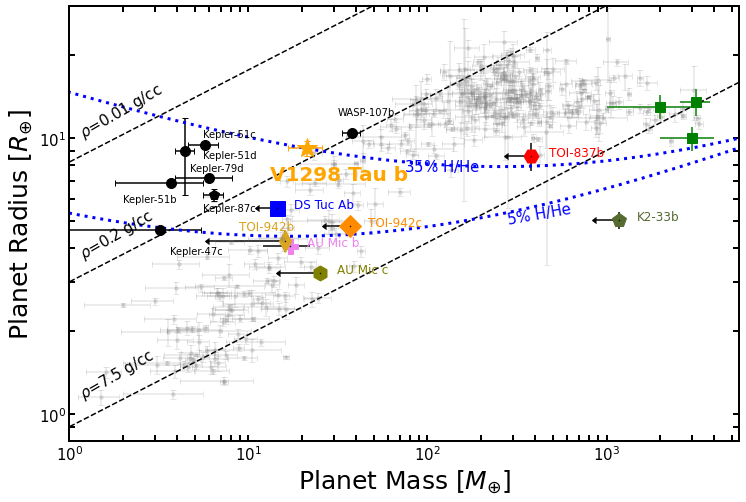

In [49]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
#x=df['   M_b   '].values
#x=x*u.M_jup
factor_m= ((1*u.M_jup).to(u.kg)/(1*u.M_earth).to(u.kg))
factor_r=((1*u.R_jup).to(u.m)/(1*u.R_earth).to(u.m))
df=df.loc[df1['st_age']<15]
df=df.loc[df1['st_age']>1]
#x.to(u.M_earth)
x=df['pl_masse'].values
y=df['pl_rade'].values
xerr=df['pl_masseerr1'].values
yerr=df['pl_radeerr1'].values
fig,ax=plt.subplots(1,1,figsize=(12,8))
#ax.errorbar(x*factor_m,y*factor_r,xerr=x_err*factor_m,yerr=yerr*factor_r,ls='none',marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
#x=x[np.where(x>1.0)[0]].values*factor_m
xerr=xerr[np.where(x>1.0)[0]]
y=y[np.where(x>1.0)[0]]
yerr=yerr[np.where(x>1.0)[0]]
x=x[np.where(x>1.0)[0]]
#print (len(x),len(y))
#x=x[np.where((xerr/x)<0.1)[0]]
y=y[np.where((xerr/x)<0.5)[0]]
#xerr=xerr[np.where((xerr/x)<0.1)[0]]
yerr=yerr[np.where((xerr/x)<0.5)[0]]
temp=xerr
xerr=xerr[np.where((xerr/x)<0.5)[0]]
x=x[np.where((temp/x)<0.5)[0]]
ax.errorbar(x,y,xerr=xerr,yerr=yerr,ls='none',marker='.',color='gray',capsize=3,alpha=0.2,ms=7)
#print (xerr)
ax.set_xlim(1,5500)
ax.set_ylim(0.8,30)
wasp107=[37.8,4.4,10.4,0.3]
ax.errorbar(wasp107[0],wasp107[2],xerr=wasp107[1],yerr=wasp107[3],ls='none',marker='o',ms=10,capsize=3,color='black')
kep_51b=[3.7,1.9,6.89,0.13]
ax.errorbar(kep_51b[0],kep_51b[2],xerr=kep_51b[1],yerr=kep_51b[3],ls='none',marker='o',ms=10,capsize=3,color='black')
kep_51c=[4.42,0.54,9.0,2.8]
ax.errorbar(kep_51c[0],kep_51c[2],xerr=kep_51c[1],yerr=kep_51c[3],ls='none',marker='o',ms=10,capsize=3,color='black')
kep_51d=[5.7,1.1,9.46,0.16]
ax.errorbar(kep_51d[0],kep_51d[2],xerr=kep_51d[1],yerr=kep_51d[3],ls='none',marker='o',ms=10,capsize=3,color='black')

kep_80b=[6.933,1.05,2.67,0.10]
#ax.errorbar(kep_80b[0],kep_80b[2],xerr=kep_80b[1],yerr=kep_80b[3],ls='none',marker='^',ms=10,capsize=3,color='brown')

v1298_b=[21.17,4.58,9.18,0.59]

ax.errorbar(v1298_b[0],v1298_b[2],xerr=v1298_b[1],yerr=v1298_b[3],ls='none',marker='*',ms=20,capsize=3,color='orange')
ax.annotate('Kepler-51b',xy=(0.08,0.55),xycoords='axes fraction',color='black')
ax.annotate('Kepler-51c',xy=(0.2,0.7),xycoords='axes fraction',color='black')
ax.annotate('Kepler-51d',xy=(0.2,0.65),xycoords='axes fraction',color='black')
#ax.annotate('Kepler-80b',xy=(0.35,0.25),xycoords='axes fraction',color='brown')
#ax.annotate('Kepler-80b',xy=(0.35,0.28),xycoords='axes fraction',color='brown')
ax.annotate('WASP-107b',xy=(0.4,0.75),xycoords='axes fraction',color='black')
ax.annotate('V1298 Tau b',xy=(0.3,0.6),xycoords='axes fraction',color='orange',fontsize=20,fontweight='bold')


ax.tick_params(which='major',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
ax.tick_params(which='minor',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
#axs[1].tick_params('both',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.0)
    #axs[1].spines[axis].set_linewidth(2.0)
ax.set_xlabel(r'Planet Mass [$M_{\oplus}$]',fontsize=25)
ax.set_ylabel(r'Planet Radius [$R_{\oplus}$]',fontsize=25)
kep_47c=[3.2,2.2,4.65,0.1]
ax.errorbar(kep_47c[0],kep_47c[2],xerr=kep_47c[1],yerr=kep_47c[3],ls='none',marker='o',ms=10,capsize=3,color='black')
ax.annotate('Kepler-47c',xy=(0.15,0.43),xycoords='axes fraction',color='black')
kep_79d=[6,2.1,7.16,0.13]
ax.errorbar(kep_79d[0],kep_79d[2],xerr=kep_79d[1],yerr=kep_79d[3],ls='none',marker='o',ms=10,capsize=3,color='black')
ax.annotate('Kepler-79d',xy=(0.18,0.62),xycoords='axes fraction',color='black')
kep_87c=[6.39,0.79,6.24,0.3]

ax.errorbar(kep_87c[0],kep_87c[2],xerr=kep_87c[1],yerr=kep_87c[3],ls='none',marker='p',ms=10,capsize=3,color='black')
ax.annotate('Kepler-87c',xy=(0.2,0.53),xycoords='axes fraction',color='black')





m_5,r_5=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/M_R_T_700_f_5.txt',unpack=True)
#ax.plot(m_5,r_5,ls='--')

m_2,r_2=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/M_R_T_700_f_2.txt',unpack=True)
#ax.plot(m_2,r_2,ls='--')






from astropy import units as u
M_e=u.M_earth
M_e=M_e.to(u.g)
R_e=u.Rearth
R_e=R_e.to(u.cm)
r=np.logspace(-1,2,50)*R_e
rho=0.2
m=4*rho*np.pi*r**3/3.0
ax.plot(m/M_e,r/R_e,ls='--',color='black',alpha=1.0)
ax.annotate(r'$\rho$=0.2 g/cc',xy=(0.01,0.42),xycoords='axes fraction',rotation=30,fontsize=15)

r=np.logspace(-1,2,50)*R_e
rho=0.01
m=4*rho*np.pi*r**3/3.0
ax.plot(m/M_e,r/R_e,ls='--',color='black',alpha=1.0)
ax.annotate(r'$\rho$=0.01 g/cc',xy=(0.01,0.7),xycoords='axes fraction',rotation=30,fontsize=15)

r=np.logspace(-1,2,50)*R_e
rho=1.0
m=4*rho*np.pi*r**3/3.0
#ax.plot(m/M_e,r/R_e,ls='--',color='black',alpha=1.0)


r=np.logspace(-1,2,50)*R_e
rho=7.5
m=4*rho*np.pi*r**3/3.0
ax.plot(m/M_e,r/R_e,ls='--',color='black',alpha=1.0)
ax.annotate(r'$\rho$=7.5 g/cc',xy=(0.01,0.1),xycoords='axes fraction',rotation=30,fontsize=15)



#m_core=10
m=np.logspace(-1,4,50)
f=5
m_core=(1-f/100.0)*m

rs=1.345
T=5000.0
a_au=0.168
flux=rs**2*(T/5778)**4/a_au**2
#flux=100
print (flux)
age=0.023
r_env=2.06*(m**(-0.21))*((f/5.0)**0.59)*((flux)**0.044)*((age/5)**(-0.11))
#m_core=10.0
r_core=m_core**0.25
#print (r_env,r_core)
ax.plot(m,r_env+r_core,ls='dotted',color='blue',lw=3)
ax.annotate(r'5$\%$ H/He',xy=(0.65,0.5),xycoords='axes fraction',rotation=10,fontsize=15,color='blue')


f=35
m_core=(1-f/100.0)*m
r_env=2.06*(m**(-0.21))*((f/5.0)**0.59)*((flux)**0.044)*((age/5)**(-0.11))
r_core=m_core**0.25
#print (r_env,r_core)
ax.plot(m,r_env+r_core,ls='dotted',color='blue',lw=3)
ax.annotate(r'35$\%$ H/He',xy=(0.5,0.62),xycoords='axes fraction',rotation=0,fontsize=15,color='blue')


#m=np.logspace(-1,4,50)
f=90
rs=1.345
T=5000.0
a_au=0.168
flux=rs**2*(T/5778)**4/a_au**2
#flux=100
#print (flux)
age=1.0
r_env=2.06*(m**(-0.21))*((f/5.0)**0.59)*((flux)**0.044)*((age/5)**(-0.11))
r_core=m_core**0.25
#print (r_env,r_core)
#ax.plot(m,r_env+r_core,ls='dotted',color='gold',lw=3)
#ax.annotate(r'5$\%$ H/He, 1Gyr',xy=(0.6,0.5),xycoords='axes fraction',rotation=10,fontsize=15,color='gold')

f=95
flux=0.008
r_env=2.06*(m**(-0.21))*((f/5.0)**0.59)*((flux)**0.044)*((age/5)**(-0.11))
#ax.plot(m,r_env+r_core,ls='dotted',color='orange',lw=3)




import pandas as pd
df_new=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/test.csv')
#print (list(df.columns))
#print (df['   M_b   '],df['  errup  '])
#print (df['   R_b  '],df['  errup .1'])
#M_b=df[['   M_b   ']].to_numpy()
#M_b_up=df[['  errup  ']].to_numpy()
df2=df_new.loc[df_new['pl_masse']>0.0]
df2=df2.loc[df2['pl_rade']>0.0]
df2=df2.loc[df2['st_age']<1]
#print (df1)
x=df2['pl_masse'].values
xerr_low=df2['pl_masseerr1'].values
xerr_up=df2['pl_masseerr2'].values
y=df2['pl_rade'].values
yerr_up=df2['pl_radeerr2'].values
yerr_low=df2['pl_radeerr1'].values
y=y[np.where((xerr_low/x)<0.5)[0]]
yerr_low=yerr_low[np.where((xerr_low/x)<0.5)[0]]
temp=xerr_low
xerr_low=xerr[np.where((xerr_low/x)<0.5)[0]]
x=x[np.where((temp/x)<0.5)[0]]
#ax.errorbar(x,y,xerr=xerr_low,yerr=yerr_low,ls='none',marker='o',capsize=3,color='red',alpha=0.2)
print (df2['pl_name'].values)
print (x)
pl_mass_young=[14.4,1176,17,25,381,16,37]
pl_mass_err=[3,300,5,10,100,10,10]
pl_rad_young=[5.6,5.04,4.07,3.24,8.6,4.24,4.79]
pl_rad_err=[0.22,0.34,0.17,0.16,1,0.37,0.4]
pl_young_name=['DS Tuc Ab','K2-33b','AU Mic b','AU Mic c','TOI-837b','TOI-942b','TOI-942c']
color=['blue','darkolivegreen','violet','olive','red','goldenrod','darkorange']
mark=['s','p','P','h',"H",'d','D']
age=np.array([40,10,22,22,35,50,50])
#age=age/350
import matplotlib
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=min(age), vmax=max(age))
#for i in range(len(age)):
#    ax.errorbar(pl_mass_young,pl_rad_young,yerr=pl_rad_err,xerr=pl_mass_err,color=color[i],xuplims=[1,1,0,1,1,1,1],ls='none',marker='o',ms=10)
#scatters = ax.scatter(pl_mass_young, pl_rad_young, c=age, cmap=cmap)
#colorbar(scatters)


pl_mass_dir=[2000,3000,3178]
pl_mass_err_dir=[1000,1000,600]
pl_rad_dir=[13,10,13.5]
pl_rad_err_dir=[1.3,1.0,1.5]
ax.errorbar(pl_mass_dir,pl_rad_dir,xerr=pl_mass_err_dir,yerr=pl_rad_err_dir,ls='none',marker='s',ms=10,color='green')


ax.errorbar(pl_mass_young,pl_rad_young,yerr=pl_rad_err,xerr=pl_mass_err,color='black',xuplims=[1,1,0,1,1,1,1],ls='none',marker='.',ms=1)
for i in range (len(pl_young_name)):
    ax.plot(pl_mass_young[i],pl_rad_young[i],color=color[i],ls='none',marker=mark[i],ms=15)
    if (pl_young_name[i]=='TOI-942b'):
        ax.annotate(pl_young_name[i],xy=(0.55*pl_mass_young[i],1.1*pl_rad_young[i]),xycoords='data',rotation=0,fontsize=12,color=color[i])
    else:  
        ax.annotate(pl_young_name[i],xy=(1.25*pl_mass_young[i],pl_rad_young[i]),xycoords='data',rotation=0,fontsize=12,color=color[i])
        
        
        
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/mass_radius_v1298_b.pdf',format='pdf')        
        

In [50]:
print (m_core)

[6.50000000e-02 8.22155891e-02 1.03990817e-01 1.31533327e-01
 1.66370615e-01 2.10434740e-01 2.66169479e-01 3.36665854e-01
 4.25833562e-01 5.38617802e-01 6.81273537e-01 8.61712388e-01
 1.08994141e+00 1.37861808e+00 1.74375227e+00 2.20559415e+00
 2.78975727e+00 3.52863904e+00 4.46321749e+00 5.64532393e+00
 7.14051742e+00 9.03172071e+00 1.14238191e+01 1.44494771e+01
 1.82764965e+01 2.31171220e+01 2.92398123e+01 3.69841292e+01
 4.67795687e+01 5.91693816e+01 7.48407010e+01 9.46626510e+01
 1.19734548e+02 1.51446868e+02 1.91558361e+02 2.42293592e+02
 3.06466314e+02 3.87635516e+02 4.90302804e+02 6.20162060e+02
 7.84415216e+02 9.92171679e+02 1.25495352e+03 1.58733451e+03
 2.00774834e+03 2.53951096e+03 3.21211368e+03 4.06285875e+03
 5.13892809e+03 6.50000000e+03]


In [15]:
import fitting_fns_template as fit_fns
t_bmjd=58852.99909 #± 0.00028
t_bjd=t_bmjd+2400000.5+69.185/(24*3600.0)
print (t_bjd)
reload(fit_fns)
Planet_LC = fit_fns.Planet('V1298b')
t0 = Planet_LC.sp_params.t0
print (t0,0.00015*24*3600)
per=24.13861
per_err=0.00102
n=int(round((t_bjd-t0)/per))

#print (n,((t_bjd-t0)/per-n*per)
ttv= (t_bjd-t0-n*per)
print (t_bjd-t0-n*per,np.sqrt((0.00028)**2+(n*per_err)**2))
#print (0.19*24)
print (24*74/365.0)

2458853.49989
(2457067.049293, 12.959999999999999)
(74, 0.1934577528169774)
(0.19345775281703936, 0.07548051934108563)
4.86575342466


In [36]:
t_bjd=2459119.0620403406
t_bmjd=58852.99909 #± 0.00028
t_bjd0=t_bmjd+2400000.5+69.185/(24*3600.0)
Planet_LC = fit_fns.Planet('V1298b')
#t0 = Planet_LC.sp_params.t0
t0=t_bjd0
n=int(round((t_bjd-t0)/per))
count=0
per=24.13889
per_err=0.00043
while (t0<t_bjd):
    t0=t0+per
    count=count+1
t0=t0-per
print (count,t_bjd-t0,(count-1)*per_err)

(12, 0.034359587356448174, 0.00473)


In [37]:
dt_min=0.00343
P=24.138
j=1
x=dt_min*4.5*j/P
y=(1/x - 1)
print (26.88/y,y,x)

(0.01719936499290187, 1562.848396501458, 0.0006394481730052199)


(45, array([ 794.575  ,  826.358  ,        nan,        nan, 4417.837  ,
       4327.36   , 3178.3    , 4290.5    , 4131.79   , 2860.47   ,
              nan,        nan,        nan,        nan,        nan,
        635.66   , 1906.98   , 4449.62   ,        nan,        nan,
       2002.31896, 2860.47   , 1589.     , 3496.     , 6515.515  ,
       1175.971  , 5085.     , 1589.15   , 5085.28   , 4767.45   ,
        635.66   ,  953.49   , 7300.     ,        nan, 4258.7    ,
       3000.     ,  794.575  , 3686.828  , 2479.06157,  222.481  ,
       5403.     , 3994.486  , 5085.28   , 3496.     , 2383.6    ]))
['TOI-942 c' 'TOI-942 b' 'DS Tuc A b' 'TOI-837 b'
 '2MASS J02192210-3925225 b' 'kap And b' 'HR 8799 e' 'AB Pic b'
 '2MASS J01033563-5515561 AB b' 'bet Pic c' 'V1298 Tau e' 'V1298 Tau d'
 'V1298 Tau c' 'V1298 Tau b' 'AU Mic b' '51 Eri b' 'TYC 8998-760-1 c'
 'TYC 8998-760-1 b' 'TAP 26 b' 'HIP 67522 b' 'YSES 2 b' 'HIP 65426 b'
 'HD 95086 b' 'HD 106906 b' 'HIP 79098 AB b' 'K2-33 b' 'ROXs 12 

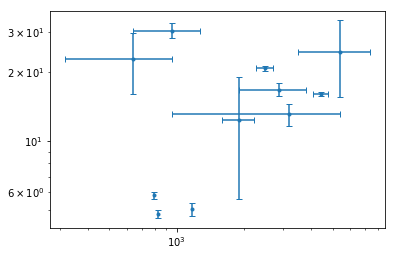

In [11]:
import pandas as pd
df1=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/test.csv')
#print (list(df1.columns))
df1=df1.loc[df1['st_age']<0.1]
#print (df1)
x=df1['pl_masse'].values
xerr_low=df1['pl_masseerr1'].values
xerr_up=df1['pl_masseerr2'].values
y=df1['pl_rade'].values
yerr_up=df1['pl_radeerr2'].values
yerr_low=df1['pl_radeerr1'].values
fig,ax=plt.subplots(1,1)
ax.errorbar(x,y,xerr=xerr_low,yerr=yerr_low,ls='none',marker='.',capsize=3)
ax.set_xscale('log')
ax.set_yscale('log')
print (len(x),x)
print (df1['pl_name'].values)
df1=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/test.csv')
df1=df1.loc[df1['st_age']<15]
df1=df1.loc[df1['st_age']>1]
#print (df1)
x=df1['pl_masse'].values
xerr_low=df1['pl_masseerr1'].values
xerr_up=df1['pl_masseerr2'].values
y=df1['pl_rade'].values
yerr_up=df1['pl_radeerr2'].values
yerr_low=df1['pl_radeerr1'].values
#ax.errorbar(x,y,xerr=np.array([xerr_low ,xerr_up]),yerr=np.array([yerr_low ,yerr_up]),ls='none',marker='.',capsize=3)

In [42]:
df_new=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/test.csv')
#print (list(df.columns))
#print (df['   M_b   '],df['  errup  '])
#print (df['   R_b  '],df['  errup .1'])
#M_b=df[['   M_b   ']].to_numpy()
#M_b_up=df[['  errup  ']].to_numpy()
#df2=df_new.loc[df_new['pl_masse']>0.0]
#df2=df2.loc[df2['pl_rade']>0.0]
df2=df_new.loc[df_new['st_age']<0.1]
#print (np.sort(df2['pl_name'].values))

print ((1.49**2)*(7229/5778)**4/(16)**2)

0.008672265625


In [33]:
M_e=u.Mearth
M_e.to(u.kg)
R_e=u.Rearth
R_e.to(u.cm)
r=np.logspace(0.1,100,50)*R_e
rho=0.1
m=4*rho*np.pi*r**3/3.0
print (m/M_e,M_e,R_e)

(<Quantity [8.35773524e-001, 1.09248414e+006, 1.42804427e+012,
           1.86667281e+018, 2.44002756e+024, 3.18949013e+030,
           4.16915261e+036, 5.44972168e+042, 7.12362180e+048,
           9.31166589e+054, 1.21717750e+061, 1.59103761e+067,
           2.07973010e+073, 2.71852610e+079, 3.55353042e+085,
           4.64500909e+091, 6.07173906e+097, 7.93669388e+103,
           1.03744758e+110, 1.35610304e+116, 1.77263460e+122,
           2.31710520e+128, 3.02881176e+134, 3.95912135e+140,
           5.17517862e+146, 6.76475192e+152, 8.84256794e+158,
           1.15585920e+165, 1.51088520e+171, 1.97495860e+177,
           2.58157370e+183, 3.37451263e+189, 4.41100539e+195,
           5.76586035e+201, 7.53686350e+207, 9.85183616e+213,
           1.28778604e+220, 1.68333379e+226, 2.20037536e+232,
           2.87622796e+238, 3.75967092e+244, 4.91446633e+250,
           6.42396099e+256, 8.39710194e+262, 1.09762997e+269,
           1.43477066e+275, 1.87546523e+281, 2.45152061e+287,
       

In [106]:
xerr=df['  errup  ']
#xerr=xerr[np.where(x>0.0)[0]].values*factor_m
print xerr.values*factor_m,factor_m

[3.81394088e-01 6.99222495e-01 1.36666215e+03 4.76742610e+00
 1.11239942e+01 3.17828407e+01 4.76742610e+01 2.23433370e+02
 2.25658169e+01 1.68449055e+01 1.08061658e+02 1.11239942e+00
 1.08061658e+01 1.58914203e+01 4.44959769e+01 1.23953079e+02
 2.57441009e+01 3.05115270e+01 1.55735919e+02 1.73216482e+03
 2.70154146e+01 8.26353857e+01 6.03873973e+01 2.95580418e+01
 1.14418226e+02 1.04883374e+02 1.01705090e+02 1.11239942e+01
 1.27131363e+01 1.58914203e+01 1.74805624e+02 2.76510714e+01
 6.35656813e+01 6.99222495e+01 1.08061658e+02 3.17828407e+01
 5.72091132e+02 5.40308291e+02 6.35656813e+00 7.31005335e+01
 5.72091132e+01 3.11471838e+00 1.39844499e+01 8.26353857e+02
 2.54262725e+00 2.54262725e+00 5.08525451e+02 3.81394088e+00
 4.13176929e+01 6.35656813e+00 1.20774795e+00 2.28836453e+00
 9.85268060e+01 1.08061658e+00 1.84340476e+00 2.44727873e+00
 8.58136698e+00 1.49379351e+01 2.86045566e-01 3.17828407e-01
 2.09766748e+00 1.27131363e-01 2.22479885e-01 5.72091132e-01
 8.58136698e-01 1.620924

In [45]:
m=units.M_earth
print (m.to(units.kg))
re=units.Rearth
re=re.to(units.m)
print (Rp/re)

5.97236473042e+24
9.186330517949816


In [59]:
#vars(Planet_LC)
print (vars(Planet_LC.sp_params))
#Planet_LC.sp_params.per
#print (Planet_LC.Forward)
#print (len(sorted_times),len(forward))
#print(sorted_times[Excl_first] + min(Times_org))
#print (vars.PLanet_)

print (((0.0665)**2)*1e6,2*0.0665*0.0004*1e6)

print ((0.0713**2)*1e6,2*0.0713*0.002*1e6)

{'nearest': None, 'xi': 0.3, 't_secondary': 2459107.3576108124, 'limb_dark': 'linear', 'n_layers': 5, 'thermal': False, 'T_s': 9600.0, 'T_n': 2556.0, 'inc': 89.517, 'a_abs': 0.1688, 'rp': 0.06285502841517596, 'per': 24.141106, 'u': [0.5550895669083666], 'fp': None, 'ecc': 0.087, 'grid': [[], [], [[]]], 'Hmag': 8.191, 'a': 27.40110336501817, 'delta_T': 2010.0, 'eclipse': True, 't0': 2459094.9021970145, 'brightness_type': 9, 'filter': False, 'stellar_model': 'blackbody', 'w': 85.0, 'Teq': 677.0, 'p_u1': 0, 'p_u2': 0}
(4422.250000000001, 53.2)
(5083.6900000000005, 285.2)


In [13]:
def f(x,a,b):
    f=a*x**b
    return f

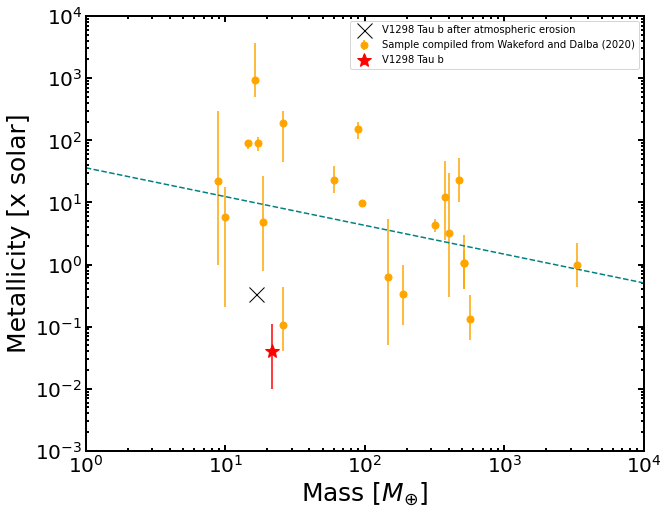

In [29]:
import pandas as pd
#df = pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD//hst_data_analysis/v1298_taub/Mass_Metallicity_table.txt',sep=' ')
#print (df)
import numpy as np
mass,met,met_up,met_low=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD//hst_data_analysis/v1298_taub/Mass_Metallicity_table.txt',usecols=(1,2,6,4),unpack=True)

from scipy.optimize import curve_fit
popt,pcov=curve_fit(f,mass,met)

from platon.constants import R_sun,R_jup,M_jup,AU,M_earth
import matplotlib.pyplot as plt
mass=mass*M_jup/M_earth
fig,axs=plt.subplots(1,1,figsize=(10,8))
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylim(1e-3,1e4)
axs.set_xlim(1e0,1e4)
m_dummy=np.logspace(0,4,50)
axs.plot(m_dummy,f(m_dummy,*popt),ls='--',color='teal')
axs.errorbar(mass,met,yerr=(met_low,met_up),ls='none',marker='o',color='orange',ms=7,label='Sample compiled from Wakeford and Dalba (2020)')
v1298=[21.45,np.log10(0.04),np.log10(0.01),np.log10(0.11)]
v1298_evolved=[16.5,np.log10(0.34),np.log10(0.01),np.log10(0.11)]
axs.errorbar(v1298[0],10**v1298[1],yerr=(np.array([10**(v1298[1])-10**(v1298[2])]),np.array([10**(v1298[3])-10**(v1298[1])])),ls='none',marker='*',ms=15,color='red',label='V1298 Tau b')
axs.plot(v1298_evolved[0],10**v1298_evolved[1],ls='none',marker='x',ms=15,color='black',label='V1298 Tau b after atmospheric erosion')
axs.set_ylabel('Metallicity [x solar]',fontsize=25)
axs.set_xlabel(r'Mass [$M_{\oplus}$]',fontsize=25)

axs.tick_params(which='major',direction='in',labelsize=20,length=6,width=2,top=True,right=True)
axs.tick_params(which='minor',direction='in',labelsize=15,length=3,width=2,top=True,right=True)
#axs[1].tick_params('both',direction='in',labelsize=15,length=6,width=2,top=True,right=True)
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2.0)
#ax.set_ylabel(r'$(R_{p}/R_{*})^{2}$ [ppm]',fontsize=25)
#ax.set_xlabel(r'Wavelength [$\mu$m]',fontsize=2
plt.legend()
plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/V1298_mass_metallicity.pdf',format='pdf')


In [43]:
from astropy import units as u
Mc=10*u.M_earth
M_env=11*u.M_earth
Rp=0.901*u.R_jup
from astropy.constants import sigma_sb,G
T=600*u.K
tau=G*Mc.to(u.kg)*M_env.to(u.kg)/((T**4)*sigma_sb*(Rp.to(u.m))**3)
print (tau.to(u.year)*1e-6)

4.224691526005875 yr


# points to discuss
Reason for C/O cut off related to CO2 and CH4 chemistry

Temperature higher than Teq by 250K. Internal heat or a result of dredging up of internal CO2/CO due to vertical mixing

Masses from different methods match, but which one should be more precise?


What can we learn from the metallicity measurement and the mass-metallicity plot above?


How to know if emcee has converged? Can see some tail like structures in the corner plots

# Tidal heating luminosity calculation

In [52]:
import numpy as np
from astropy import units as u
from astropy.constants import R_sun,M_sun, R_earth,G,au,L_sun,sigma_sb
Q=1e3
P=24.14*24*3600*u.s
n=np.pi/P
M_star=1.1*M_sun
Rp=10.27*R_earth.to(u.m)
#print (M_star,P,Rp)
a=0.168*au#print (a)
K=(9*n/Q/4)*(G*M_star**2/Rp)*(Rp/a)**6
print (K)

e=0.22
Na=(1+31*e**2/2 + 255*e**4/8 + 185*e**6/16 + 25*e**8/64)/(1-e**2)**7.5
Ne=(1+15*e**2/2 + 45*e**4/8 + 5*e**6/16)/(1-e**2)**6
omega=(1+ 3*e**2 + 3*e**4/8)/(1-e**2)**4.5
eps=0.0
L=2*K*(Na-Ne**2/omega*1.0)
print (L)
#print (L.to(u.erg/second))
L_int=L.value*1e7*u.erg/u.s
#print (L_int*u.erg/u.s)
L_star=10**(-0.04)*L_sun*(Rp**2/(2*a**2))
print ('Percentage of L_star',100*L.value*u.W/L_star)


L=L.value*u.W
Tint=(L/(sigma_sb*np.pi*Rp**2))**0.25
print (Tint)


5.178273361844536e+18 kg m2 / s3
2.608666755618713e+18 kg m2 / s3
Percentage of L_star 0.21999991971699118
241.70373678073983 K


In [53]:
T_star=5000
R_star=1.3*R_sun
print ((T_star/373.0)**2*R_star.to(u.au))

1.0863312895318022 AU


# Density multiplicity relation

['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_denslim', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_logglim', 'st_age', 'st_ageerr1', 'st_ageerr2', 'st_agelim', 'sy_refname', 'sy_dist', 'sy_disterr1', 'sy_disterr2', 'sy_gaiamag', 'sy_gaiamagerr1', 'sy_gaiamagerr2']
(174, 64)
(147, 64)
(27, 64)


Text(0, 0.5, 'Frequency density')

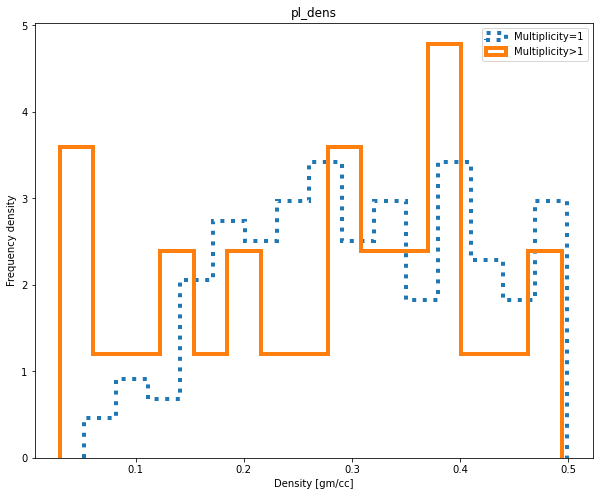

In [94]:
import pandas as pd
df1=pd.read_csv('/Users/s.baratuva.nl/Desktop/PhD/density_multiplicity.csv')
#print (df1.shape)
print (list(df1.columns))
#print (df['   M_b   '],df['  errup  '])
#print (df['   R_b  '],df['  errup .1'])
#M_b=df[['   M_b   ']].to_numpy()
#M_b_up=df[['  errup  ']].to_numpy()
df=df1.loc[df1['pl_dens']>0.0]
df=df.loc[df['pl_dens']<0.5]
print (df.shape)
fig,ax=plt.subplots(1,1,figsize=(10,8))
df_temp=df.loc[df['sy_pnum']==1]
df_temp.hist('pl_dens',ax=ax,density=True,histtype='step',ls=':',lw=4,label='Multiplicity=1',bins=15)
print (df_temp.shape)
df_temp=df.loc[df['sy_pnum']>1]
df_temp.hist('pl_dens',ax=ax,density=True,histtype='step',linestyle='-',lw=4,label='Multiplicity>1',grid=False,bins=15)
print (df_temp.shape)
#df_temp=df.loc[df['sy_pnum']==3]
#df_temp.hist('pl_dens',ax=ax,density=True,grid=False,histtype='step',ls='-.',lw=4)
#df=df.loc[df['pl_rade']>0.0]
#print (df_temp.shape)
ax.legend()
ax.set_xlabel('Density [gm/cc]')
ax.set_ylabel('Frequency density')

## Spectrum 

And with RECTE, too, you can make a spectrum. It is important to remember that RECTE was designed for use with single columns. So, it will perform better the smaller your bins are. However, the smaller your bins, the more difficult it is to fit them.

In [42]:
deltat = opt[2]
aRs = opt[5]
incl=opt[3]
e_os=opt[13]
e_of=opt[14]
del_es=opt[15]
del_ef=opt[16]
#e_os=0.0
#e_of=0.0
#del_es=0.0
#del_ef=0.0
print (incl,e_os)
u11=opt[6]
u22=opt[7]
cx=opt[-1]

(89.35, 1176.7499223679854)


In [43]:
Nr_pixels = 7
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

cm = plt.cm.get_cmap('RdYlGn')
colors = cm(np.arange(N_bins)  * cm.N / N_bins)

Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.8834e-05
    reduced chi-square = 1.3263e-07
    Akaike info crit   = -2412.27452
    Bayesian info crit = -2378.93971
[[Variables]]
    depth_F:                  0.00401518 +/- 1.7455e-04 (4.35%) (init = 0.0015)
    depth_R:                  0.00425750 +/- 1.7496e-04 (4.11%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.50858451 +/- 0.04694619 (9.23%) (init = 0.46)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                    -5.8126e-05 +/- 0.00371096 (6384.32%) (init = -0.003)
    V2_R:                     0.00491415 +/- 0.00362405 (73.75%) (init = -0.003)
    Stellar_fl

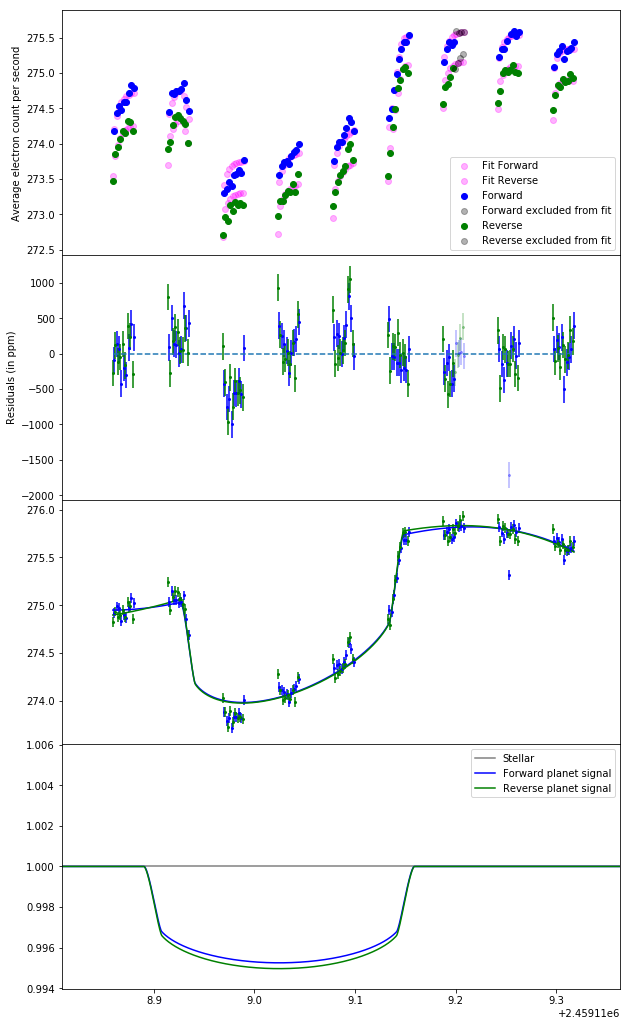

-2378.9397051083024
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.3321e-05
    reduced chi-square = 9.3812e-08
    Akaike info crit   = -2465.25725
    Bayesian info crit = -2431.92243
[[Variables]]
    depth_F:                  0.00407475 +/- 1.4750e-04 (3.62%) (init = 0.0015)
    depth_R:                  0.00420018 +/- 1.4704e-04 (3.50%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.49921323 +/- 0.03967895 (7.95%) (init = 0.5085845)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                    -5.0613e-04 +/- 0.00312380 (617.20%) (init = -0.003)
    V2_R:                     0.00493053 +/- 0.00304784 (61.82%) (init 

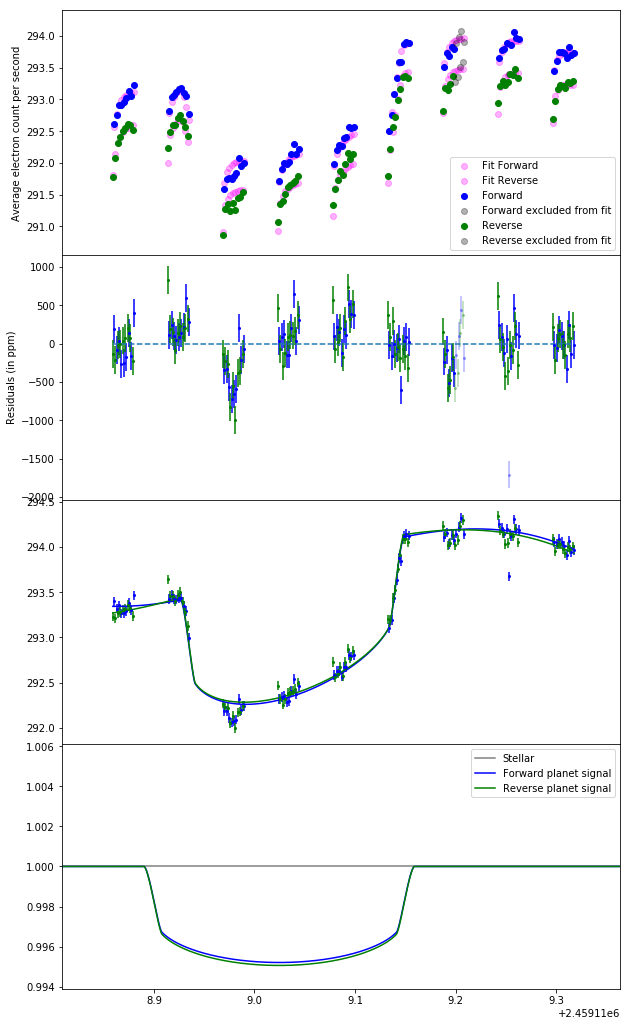

-2431.922430673373
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.6251e-05
    reduced chi-square = 1.1444e-07
    Akaike info crit   = -2434.84326
    Bayesian info crit = -2401.50844
[[Variables]]
    depth_F:                  0.00397904 +/- 1.6346e-04 (4.11%) (init = 0.0015)
    depth_R:                  0.00420361 +/- 1.6357e-04 (3.89%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.46238773 +/- 0.04507722 (9.75%) (init = 0.4992132)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                    -0.00133099 +/- 0.00345000 (259.21%) (init = -0.003)
    V2_R:                     0.00234199 +/- 0.00336792 (143.81%) (init 

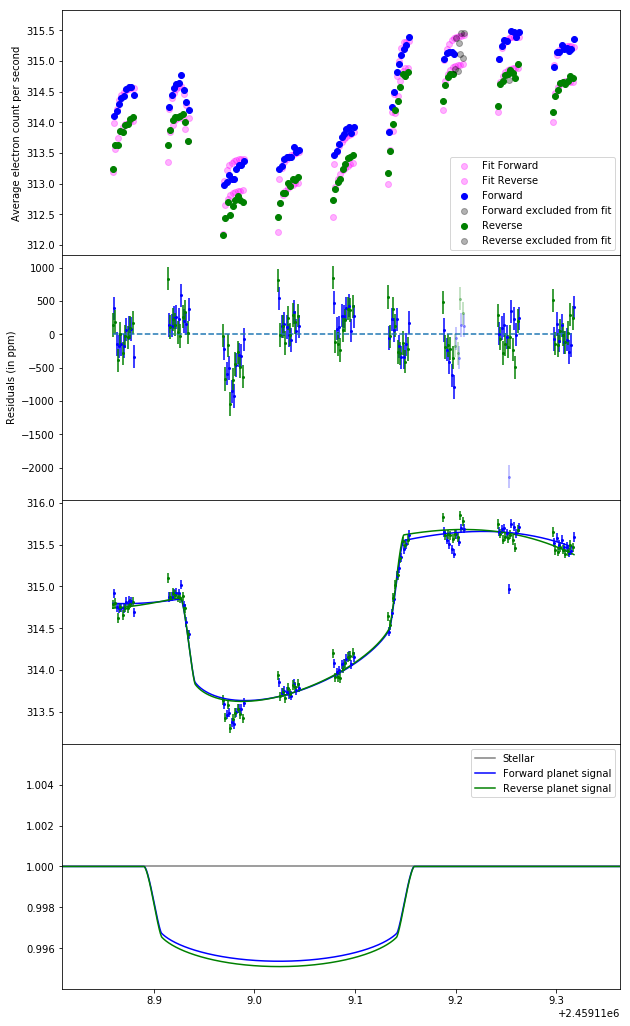

-2401.508443691006
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.6103e-05
    reduced chi-square = 1.1340e-07
    Akaike info crit   = -2436.24647
    Bayesian info crit = -2402.91165
[[Variables]]
    depth_F:                  0.00392815 +/- 1.6045e-04 (4.08%) (init = 0.0015)
    depth_R:                  0.00406239 +/- 1.6014e-04 (3.94%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.53803712 +/- 0.04414926 (8.21%) (init = 0.4623877)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     4.4633e-04 +/- 0.00342295 (766.91%) (init = -0.003)
    V2_R:                     0.00345385 +/- 0.00334127 (96.74%) (init =

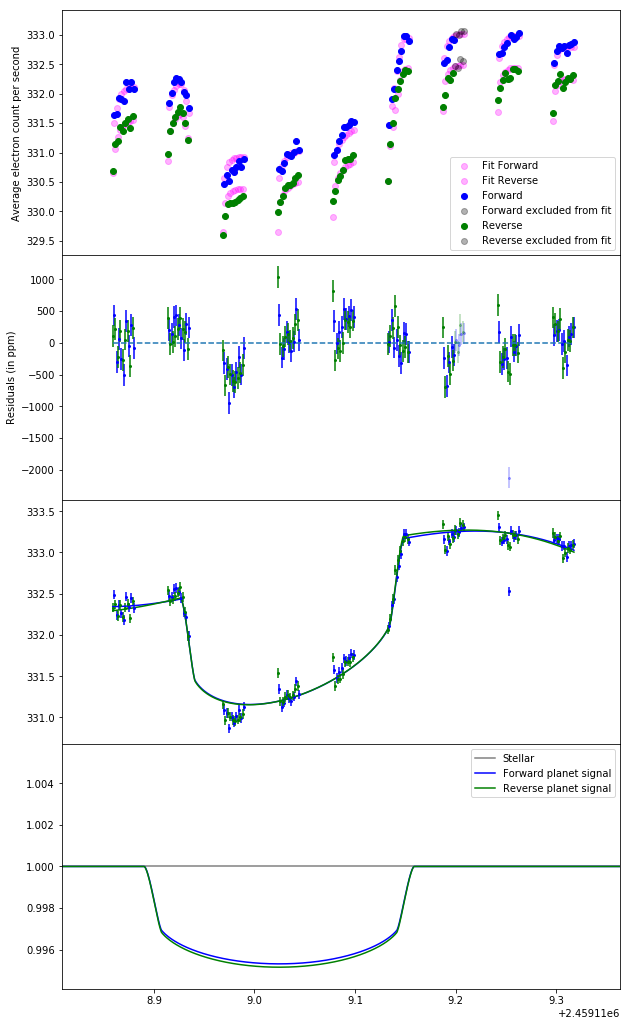

-2402.9116548753236
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.5517e-05
    reduced chi-square = 1.0927e-07
    Akaike info crit   = -2441.91806
    Bayesian info crit = -2408.58324
[[Variables]]
    depth_F:                  0.00390499 +/- 1.5865e-04 (4.06%) (init = 0.0015)
    depth_R:                  0.00399953 +/- 1.5800e-04 (3.95%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.50259316 +/- 0.04457131 (8.87%) (init = 0.5380371)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                    -0.00331434 +/- 0.00336405 (101.50%) (init = -0.003)
    V2_R:                     0.00468395 +/- 0.00328375 (70.11%) (init 

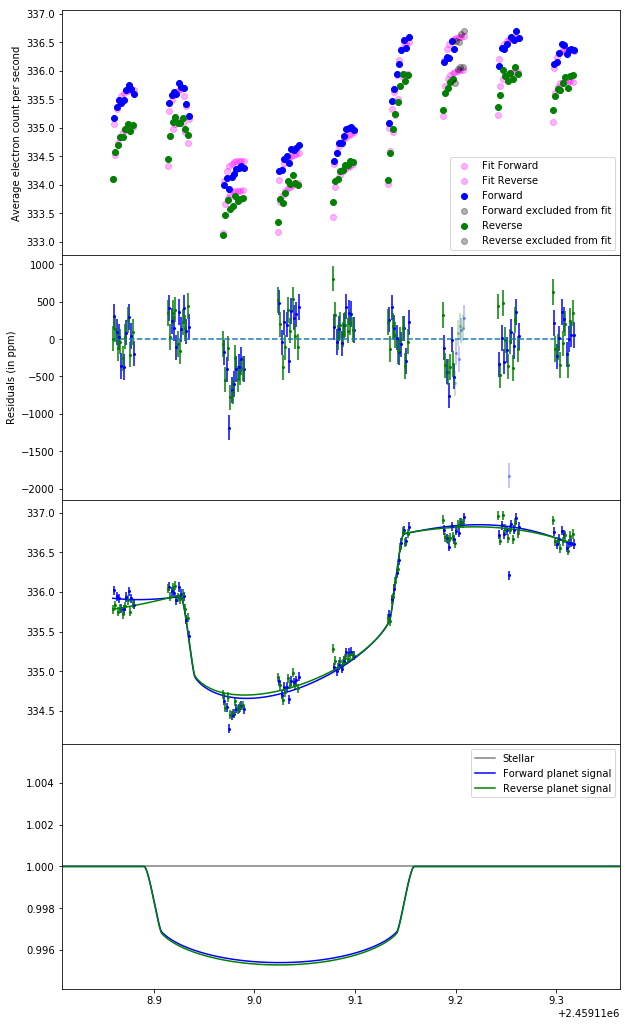

-2408.583242914766
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.7361e-05
    reduced chi-square = 1.2226e-07
    Akaike info crit   = -2424.73319
    Bayesian info crit = -2391.39837
[[Variables]]
    depth_F:                  0.00401412 +/- 1.6829e-04 (4.19%) (init = 0.0015)
    depth_R:                  0.00390441 +/- 1.6591e-04 (4.25%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.51466576 +/- 0.04677188 (9.09%) (init = 0.5025932)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     7.3454e-04 +/- 0.00356098 (484.79%) (init = -0.003)
    V2_R:                    -5.6904e-04 +/- 0.00346713 (609.30%) (init 

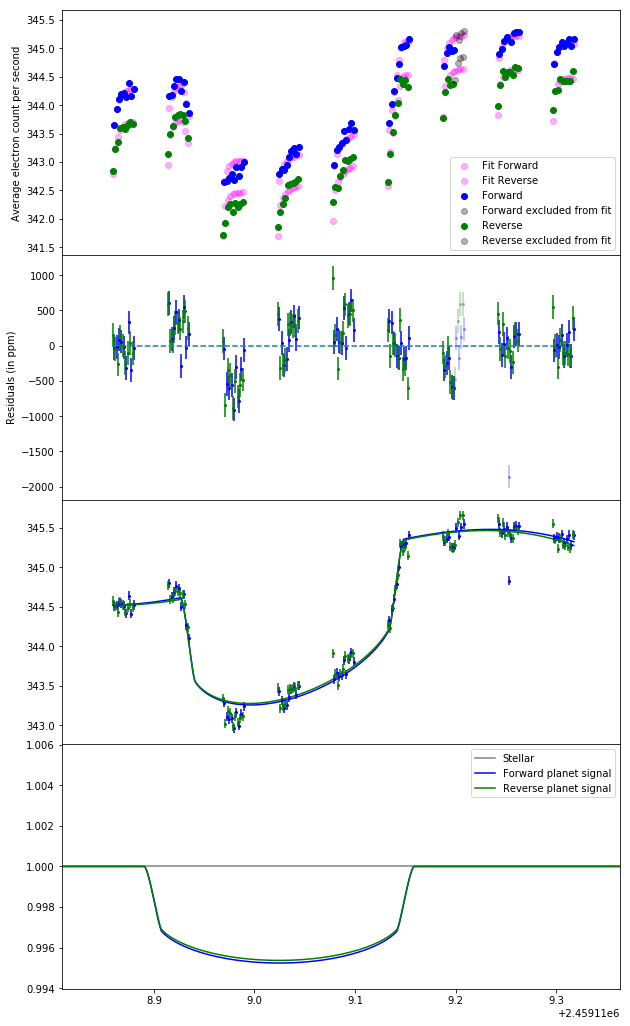

-2391.398370584525
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.5269e-05
    reduced chi-square = 1.0753e-07
    Akaike info crit   = -2444.37454
    Bayesian info crit = -2411.03972
[[Variables]]
    depth_F:                  0.00418465 +/- 1.5865e-04 (3.79%) (init = 0.0015)
    depth_R:                  0.00394054 +/- 1.5548e-04 (3.95%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.51312997 +/- 0.04287424 (8.36%) (init = 0.5146658)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     8.4657e-04 +/- 0.00334479 (395.10%) (init = -0.003)
    V2_R:                    -0.00256637 +/- 0.00325244 (126.73%) (init 

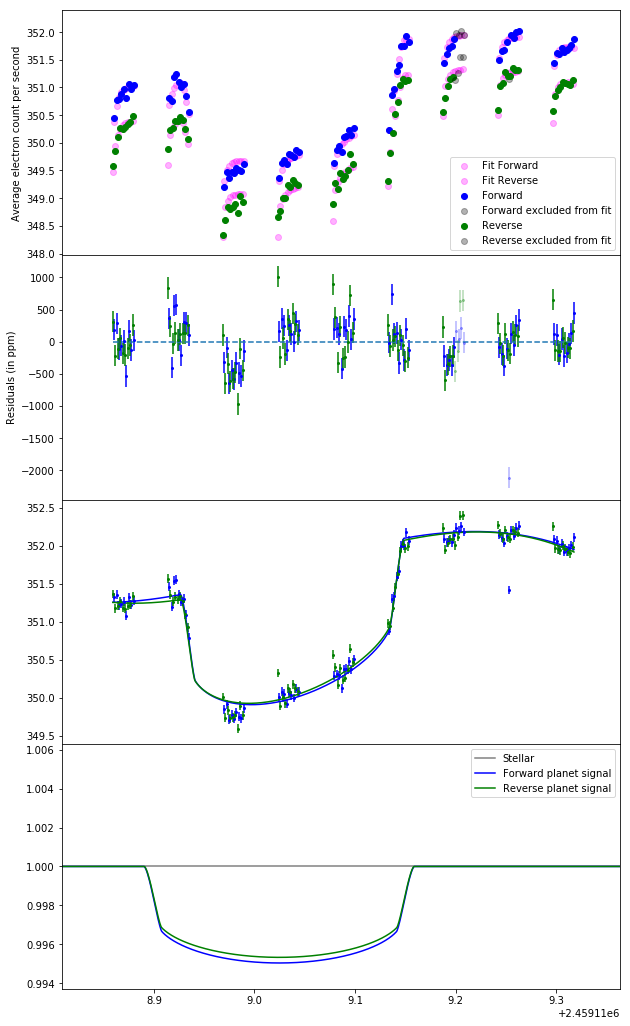

-2411.0397180490613
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 153
    # variables        = 11
    chi-square         = 1.6041e-05
    reduced chi-square = 1.1297e-07
    Akaike info crit   = -2436.82940
    Bayesian info crit = -2403.49458
[[Variables]]
    depth_F:                  0.00439103 +/- 1.6423e-04 (3.74%) (init = 0.0015)
    depth_R:                  0.00439139 +/- 1.6233e-04 (3.70%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.46998768 +/- 0.04185361 (8.91%) (init = 0.51313)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                    -2.9025e-04 +/- 0.00344328 (1186.30%) (init = -0.003)
    V2_R:                     8.8042e-04 +/- 0.00334922 (380.41%) (init 

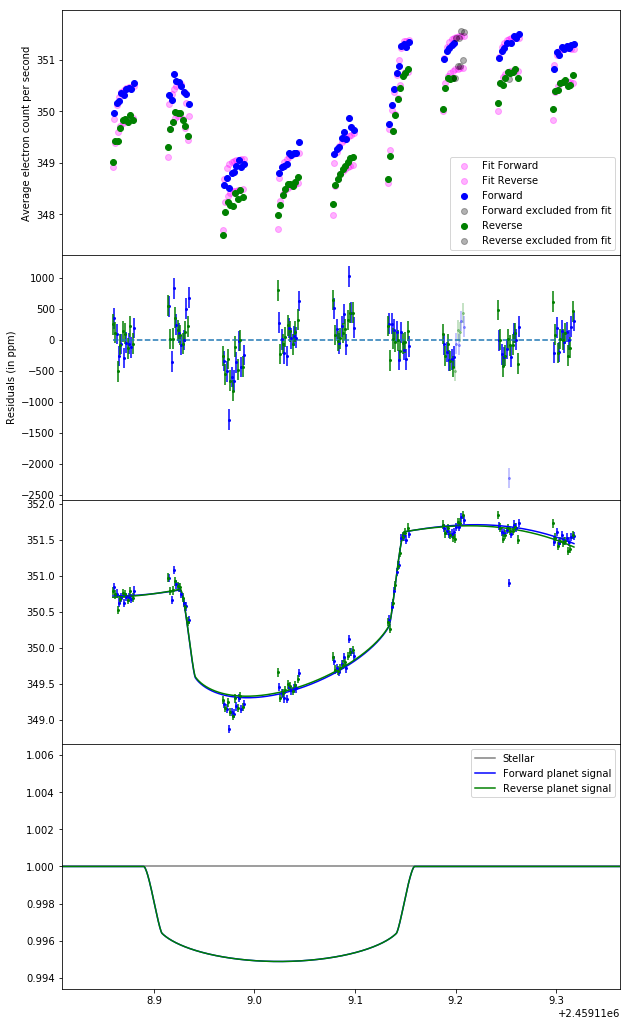

-2403.4945779660807
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.2734e-05
    reduced chi-square = 8.9675e-08
    Akaike info crit   = -2472.15729
    Bayesian info crit = -2438.82247
[[Variables]]
    depth_F:                  0.00436770 +/- 1.4562e-04 (3.33%) (init = 0.0015)
    depth_R:                  0.00438690 +/- 1.4416e-04 (3.29%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.49072647 +/- 0.03701434 (7.54%) (init = 0.4699877)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                    -6.1993e-04 +/- 0.00306415 (494.28%) (init = -0.003)
    V2_R:                     0.00318923 +/- 0.00298283 (93.53%) (init 

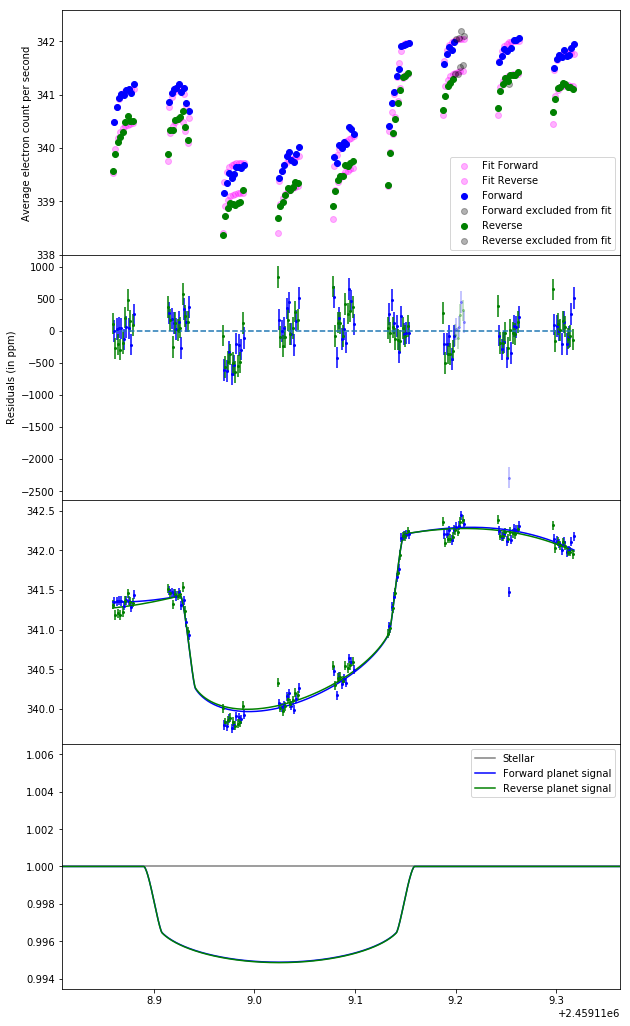

-2438.822468801323
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.4041e-05
    reduced chi-square = 9.8880e-08
    Akaike info crit   = -2457.20722
    Bayesian info crit = -2423.87240
[[Variables]]
    depth_F:                  0.00432637 +/- 1.5199e-04 (3.51%) (init = 0.0015)
    depth_R:                  0.00448550 +/- 1.5153e-04 (3.38%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.50149286 +/- 0.03841052 (7.66%) (init = 0.4907265)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     6.8346e-04 +/- 0.00321324 (470.14%) (init = -0.003)
    V2_R:                     0.00278380 +/- 0.00313228 (112.52%) (init 

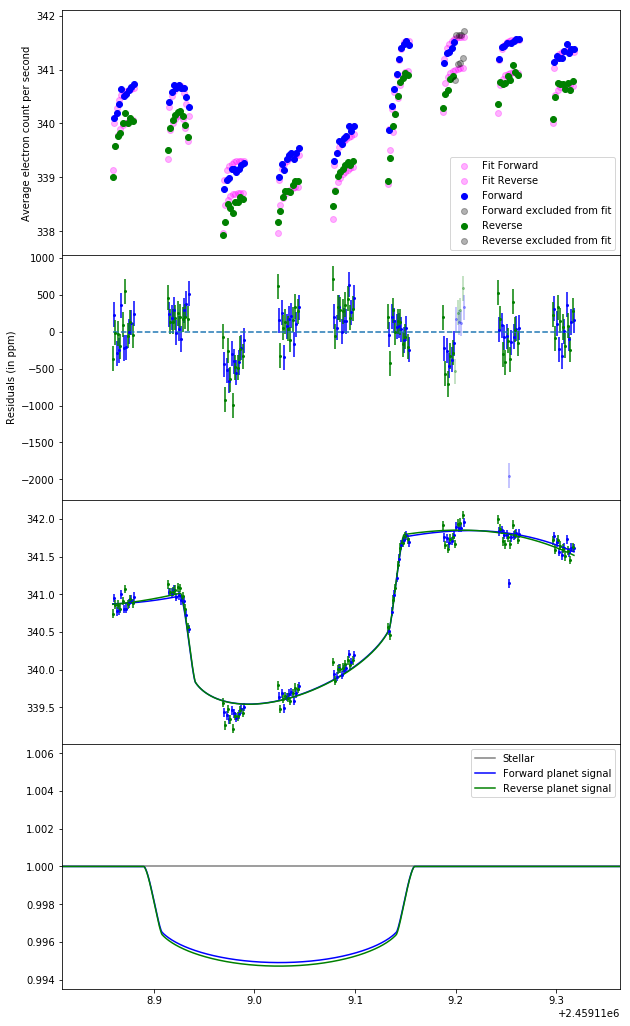

-2423.8723993611243
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.3452e-05
    reduced chi-square = 9.4729e-08
    Akaike info crit   = -2463.76829
    Bayesian info crit = -2430.43347
[[Variables]]
    depth_F:                  0.00417715 +/- 1.4846e-04 (3.55%) (init = 0.0015)
    depth_R:                  0.00414102 +/- 1.4691e-04 (3.55%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.50931153 +/- 0.03946347 (7.75%) (init = 0.5014929)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00413488 +/- 0.00313970 (75.93%) (init = -0.003)
    V2_R:                     7.1768e-04 +/- 0.00305745 (426.02%) (init 

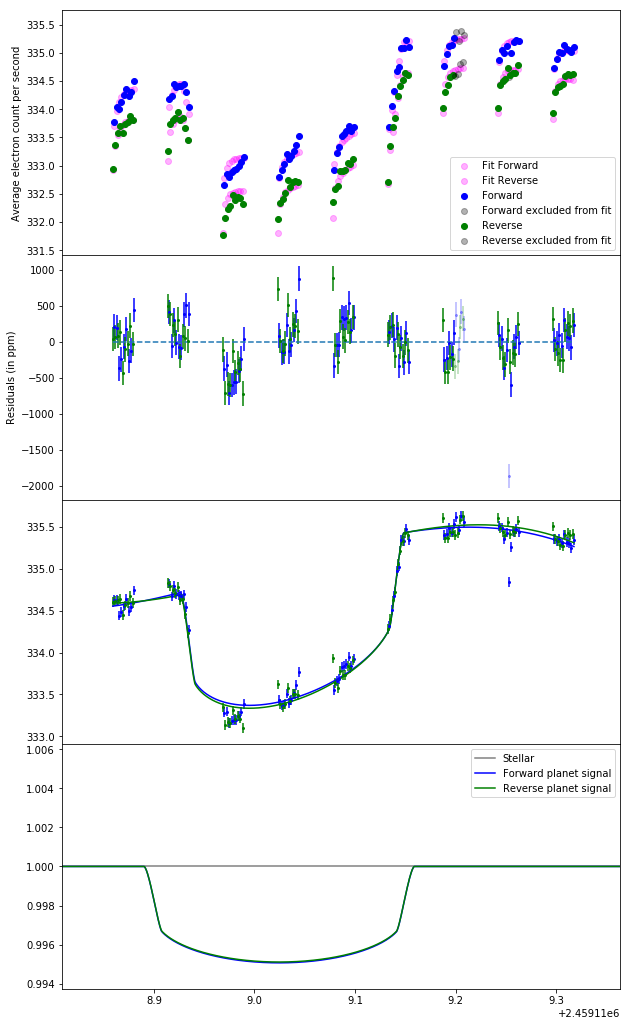

-2430.433474029033
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.3469e-05
    reduced chi-square = 9.4855e-08
    Akaike info crit   = -2463.56599
    Bayesian info crit = -2430.23117
[[Variables]]
    depth_F:                  0.00405523 +/- 1.4981e-04 (3.69%) (init = 0.0015)
    depth_R:                  0.00423601 +/- 1.4954e-04 (3.53%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.43332736 +/- 0.04113602 (9.49%) (init = 0.5093115)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     4.6391e-04 +/- 0.00314562 (678.06%) (init = -0.003)
    V2_R:                     0.00301231 +/- 0.00306843 (101.86%) (init 

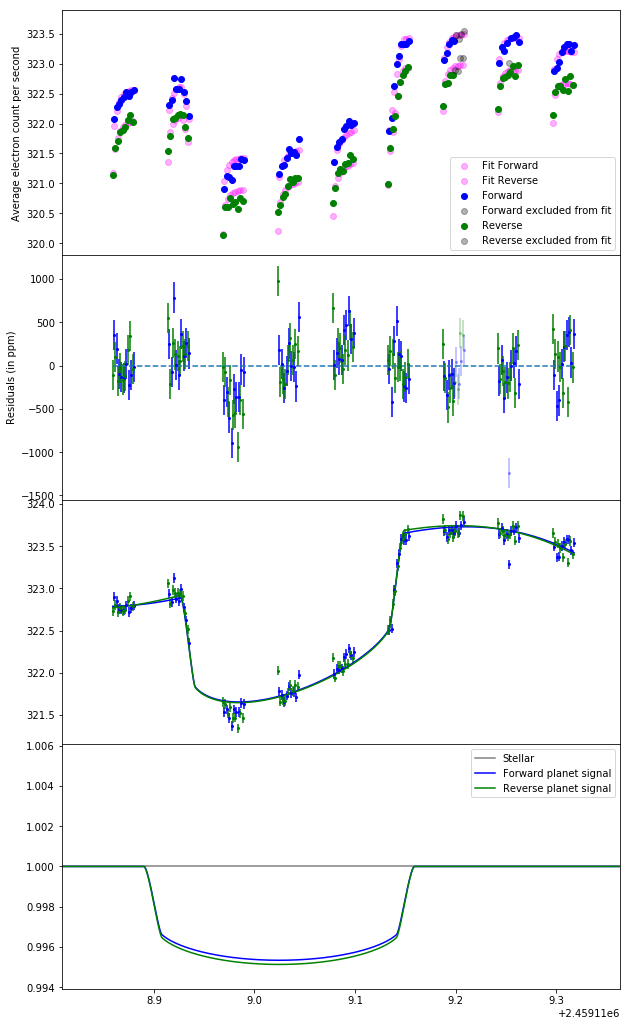

-2430.2311697770488
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.0815e-05
    reduced chi-square = 7.6160e-08
    Akaike info crit   = -2497.15204
    Bayesian info crit = -2463.81723
[[Variables]]
    depth_F:                  0.00409649 +/- 1.3296e-04 (3.25%) (init = 0.0015)
    depth_R:                  0.00428275 +/- 1.3288e-04 (3.10%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.48958977 +/- 0.03548907 (7.25%) (init = 0.4333274)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00246690 +/- 0.00281362 (114.05%) (init = -0.003)
    V2_R:                     0.00493566 +/- 0.00274571 (55.63%) (init 

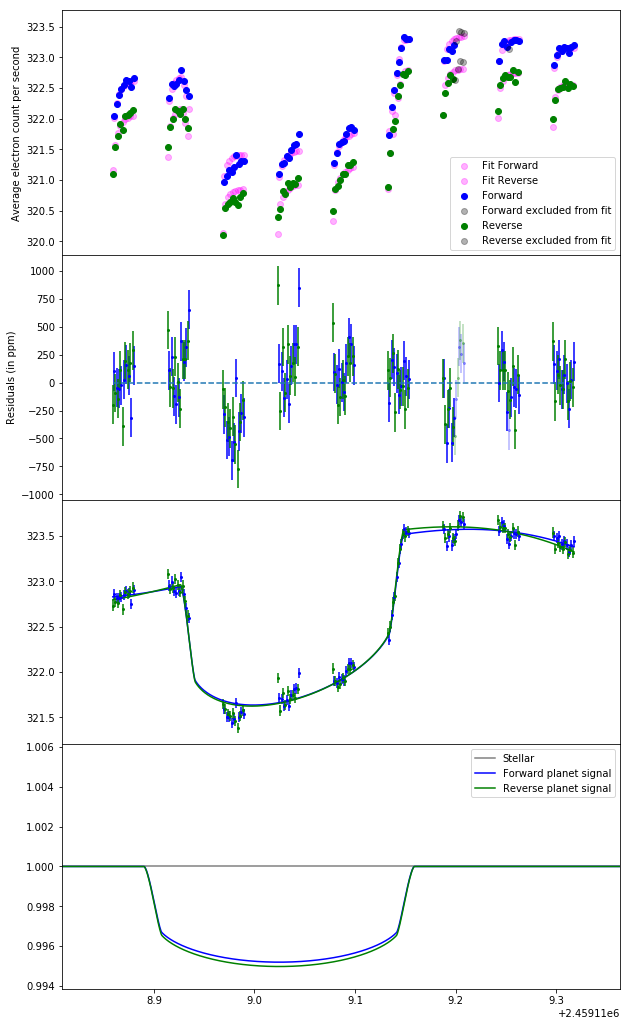

-2463.817225067993
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.1477e-05
    reduced chi-square = 8.0825e-08
    Akaike info crit   = -2488.05573
    Bayesian info crit = -2454.72091
[[Variables]]
    depth_F:                  0.00396016 +/- 1.3642e-04 (3.44%) (init = 0.0015)
    depth_R:                  0.00414258 +/- 1.3640e-04 (3.29%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.49914338 +/- 0.03752058 (7.52%) (init = 0.4895898)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00155427 +/- 0.00289415 (186.21%) (init = -0.003)
    V2_R:                     0.00572401 +/- 0.00282583 (49.37%) (init =

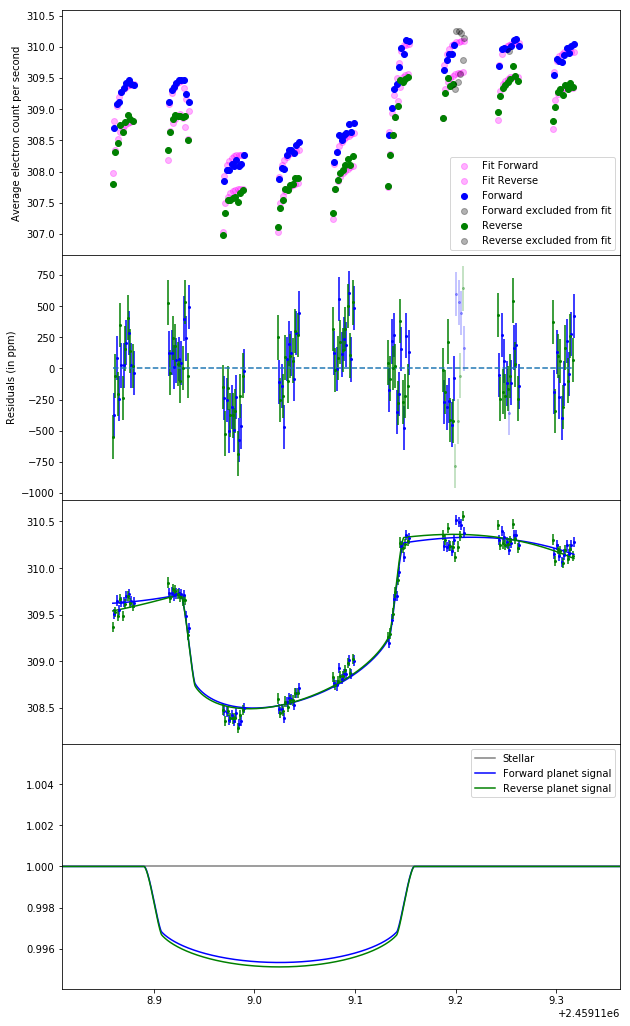

-2454.7209096338474
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.3329e-05
    reduced chi-square = 9.3863e-08
    Akaike info crit   = -2465.17442
    Bayesian info crit = -2431.83960
[[Variables]]
    depth_F:                  0.00411484 +/- 1.4963e-04 (3.64%) (init = 0.0015)
    depth_R:                  0.00411863 +/- 1.4824e-04 (3.60%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.42708488 +/- 0.04130516 (9.67%) (init = 0.4991434)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00328265 +/- 0.00312986 (95.35%) (init = -0.003)
    V2_R:                     0.00822715 +/- 0.00304913 (37.06%) (init =

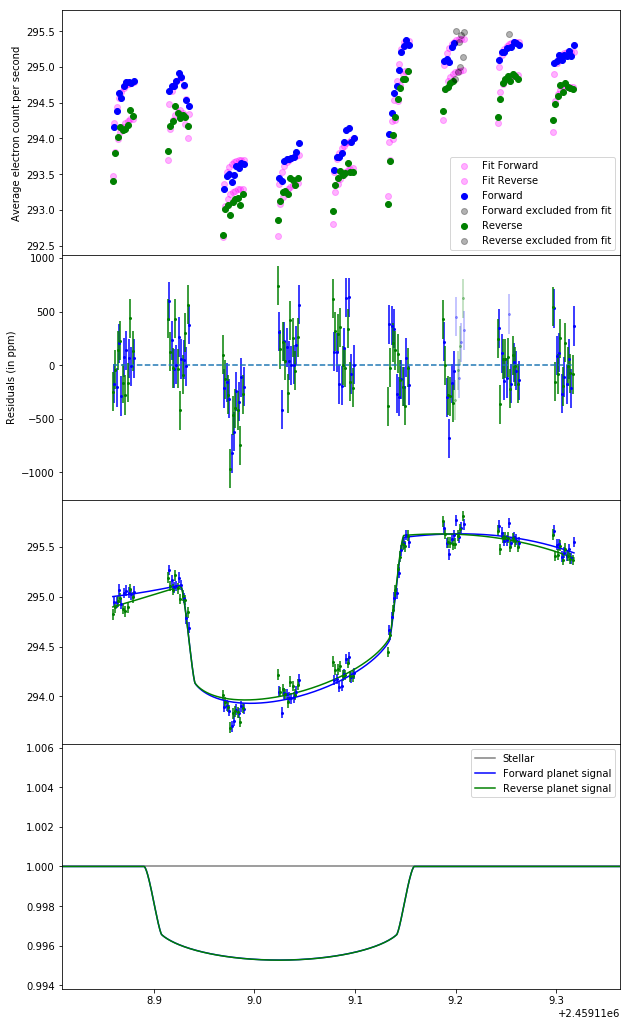

-2431.839602754205
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.0360e-05
    reduced chi-square = 7.2960e-08
    Akaike info crit   = -2503.71850
    Bayesian info crit = -2470.38369
[[Variables]]
    depth_F:                  0.00403978 +/- 1.3050e-04 (3.23%) (init = 0.0015)
    depth_R:                  0.00434793 +/- 1.3098e-04 (3.01%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.45967587 +/- 0.03520680 (7.66%) (init = 0.4270849)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00324184 +/- 0.00275524 (84.99%) (init = -0.003)
    V2_R:                     0.01124450 +/- 0.00269117 (23.93%) (init = 

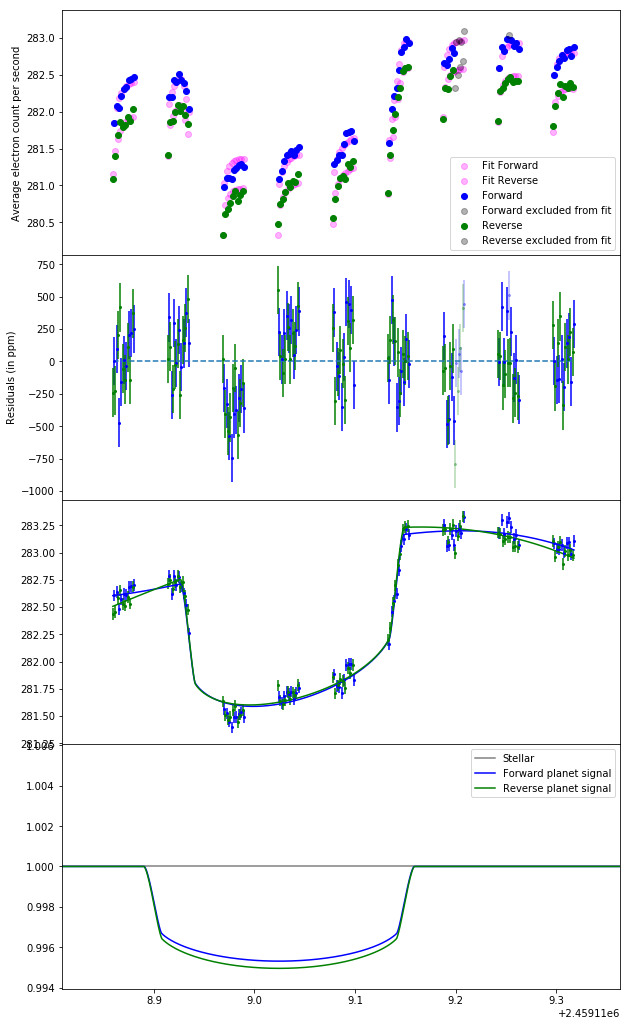

-2470.383687402621
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 153
    # variables        = 11
    chi-square         = 1.8992e-05
    reduced chi-square = 1.3375e-07
    Akaike info crit   = -2410.99211
    Bayesian info crit = -2377.65729
[[Variables]]
    depth_F:                  0.00416235 +/- 1.7758e-04 (4.27%) (init = 0.0015)
    depth_R:                  0.00431630 +/- 1.7707e-04 (4.10%) (init = 0.0015)
    Mid_transit_time_offset:  0.01873727 (fixed)
    Inclination:              89.35 (fixed)
    Eccentricity:             0.112 (fixed)
    aRs:                      26.37388 (fixed)
    u1:                       0.45631867 +/- 0.04731495 (10.37%) (init = 0.4596759)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00644778 +/- 0.00373630 (57.95%) (init = -0.003)
    V2_R:                     0.01490309 +/- 0.00364503 (24.46%) (init =

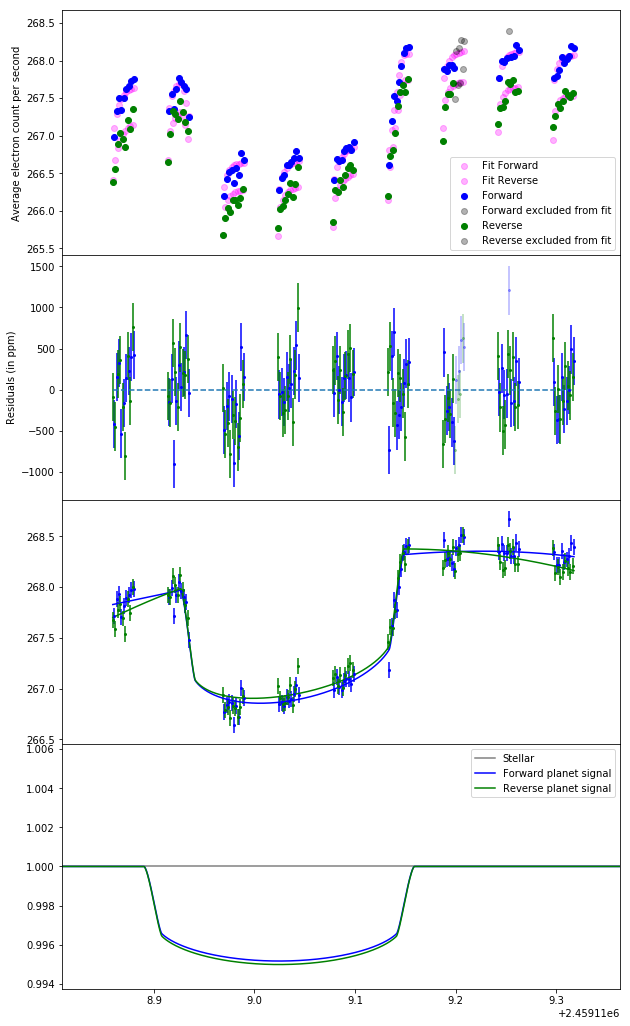

-2377.657291057534


In [44]:
reload(fit_fns)
Planet_LC_multi = fit_fns.Planet('V1298b')
t0 = Planet_LC_multi.sp_params.t0
while t0 < min(Times_org) + Planet_LC_multi.sp_params.per:
    t0 += Planet_LC_multi.sp_params.per
t0 -= 2 * Planet_LC_multi.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
#Excl_first[Sec]=False
#n0=len(Thi)-1
#print (Thi[n0-3:])
#Excl_first[Thi[n0-3:]]=False
exc_indices=[]
#exc_indices.extend(Fir)
#exc_indices.extend(Sec)
#exc_indices.extend(For)
#exc_indices.extend(Fif)
#exc_indices.extend(Six)
#exc_indices.extend(Thi)
lis1=[118,119,120,121,122,123,124,125,135]
exc_indices.extend(lis1)
RpRs2 = []
RpRs2_err = []
opt_cs = []
err_cs = []
noise = []
photonnoise = []

bic=[]
x_shift=[]
x_shift_err=[]
cov=[]
limb=[]
limb_err=[]
Residuals=[]
Errors=[]
for i,wave_bin in enumerate(bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
    Binned_LC = Binned_LC / imagesize
    Binned_LC_err = Binned_LC_err / imagesize
    Binned_LC_full, Binned_LC_full_err = Binned_LC.copy(), Binned_LC_err.copy()
    Binned_LC_err /= np.max(Binned_LC)
    Binned_LC /= np.max(Binned_LC)
    opt_c, err_c, chi2_c, bic_c,out,ec_lc,Residue,errs,x = Planet_LC_multi.Fit_with_recte_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           Binned_LC_full[Excl_first], Binned_LC_full_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first],data_xshift[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear',u1=u11, u2=u22,
                                                           fix_inclination=True,
                                                           fix_eccentricity=True, 
                                                           nosat=True,
                                                           deltat=deltat, a=aRs, fix_aRs=True,
                                                           t0=t0, exptime = exptime, exc_indices=exc_indices,
                                                           verbose=True,polynomial=True,vary_cxshift=False,
                                                           Transit=True,vary_recte=False,E0_s=e_os,E0_f=e_of,Delta_Es=del_es,Delta_Ef=del_ef,c_xshift=0.0)
    RpRs2.append(opt_c[1])
    RpRs2_err.append(err_c[1])
    opt_cs.append(opt_c)
    err_cs.append(err_c)
 #   print (opt_c[0],err_c[0])
    fit_opt = opt_c[:-3]
#    print (opt_c[-1],err_c[-1])
    print (bic_c)
    x_shift.append(opt_c[-1])
    x_shift_err.append(err_c[-1])
    bic.append(bic_c)
#    cov.append(out.covar[11][0])
    limb.append(opt_c[6])
    limb_err.append(err_c[6])
    Residuals.append(Residue)
    Errors.append(errs)
'''

    LC_new = Planet_LC_multi.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          exptime=exptime,
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]


    noise.append(np.sqrt(np.sum((Binned_LC_full[Excl_first] - LC_new)**2./ Binned_LC_full[Excl_first]**2.) / len(Binned_LC_full[Excl_first])) *1.e6)
    photonnoise.append(1. / np.sqrt(np.mean(Binned_LC_full[Excl_first] * len(wave_bin) * imagesize * exptime)) * 1.e6)



'''
RpRs2 = np.array(RpRs2)
RpRs2_err = np.array(RpRs2_err)



#print (RpRs2_err)
#print (err_c,opt_c[0])



<ErrorbarContainer object of 3 artists>

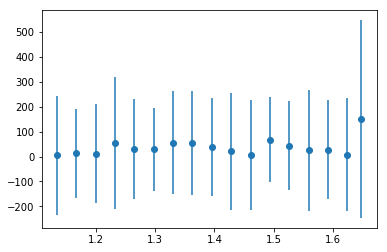

In [51]:
res=np.array([])
std=np.array([])
for i in range (len(Residuals)):
    res=np.append(res,np.median(Residuals[i][Fir]))
    std=np.append(std,np.std(Residuals[i][Fir]))
plt.errorbar(bins_avg_wave,abs(res)*1e6,yerr=std*1e6,ls='none',marker='o')

<ErrorbarContainer object of 3 artists>

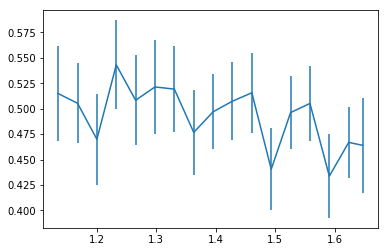

In [36]:
plt.errorbar(bins_avg_wave,limb,yerr=limb_err)

<ErrorbarContainer object of 3 artists>

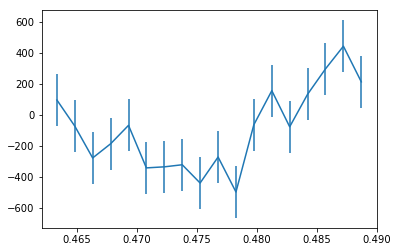

In [25]:
#for i in range(len(Residuals)):
i=7
plt.errorbar(sorted_times[Excl_first][Sev],Residuals[i][Sev]*1e6,yerr=Errors[i][Sev]*1e6)

Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.70532331
    reduced chi-square = 0.00568809
    Akaike info crit   = -687.340457
    Bayesian info crit = -655.382435
[[Variables]]
    depth_F:                  0.00373095 +/- 1.3081e-04 (3.51%) (init = 0.0015)
    depth_R:                  0.00397730 +/- 1.3194e-04 (3.32%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.58707365 +/- 0.03662920 (6.24%) (init = 0.46)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00376307 +/- 0.00281782 (74.88%) (init = -0.003)
    V2_R:                     0.00860445 +/- 0.00275439 (32.01%) (init = -0.003)
    Stellar_flu

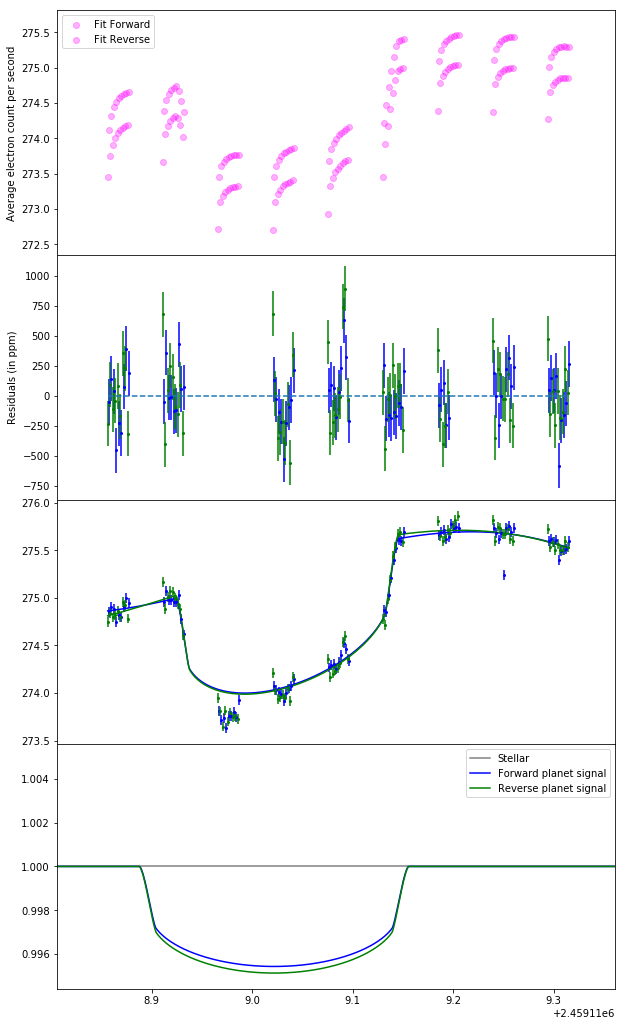

-655.3824346185074
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.59535806
    reduced chi-square = 0.00480127
    Akaike info crit   = -710.222052
    Bayesian info crit = -678.264029
[[Variables]]
    depth_F:                  0.00384766 +/- 1.1378e-04 (2.96%) (init = 0.0015)
    depth_R:                  0.00395872 +/- 1.1376e-04 (2.87%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.56533002 +/- 0.03151484 (5.57%) (init = 0.5870736)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00211182 +/- 0.00243054 (115.09%) (init = -0.003)
    V2_R:                     0.00825370 +/- 0.00237261 (28.75%) (init 

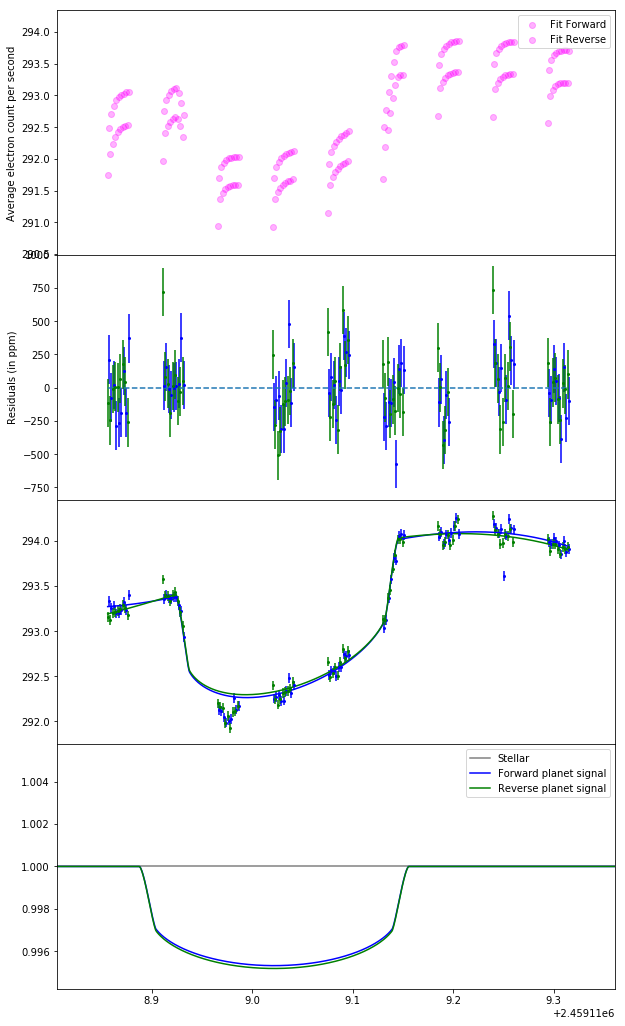

-678.2640293010123
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.77003884
    reduced chi-square = 0.00620999
    Akaike info crit   = -675.489529
    Bayesian info crit = -643.531507
[[Variables]]
    depth_F:                  0.00371041 +/- 1.2060e-04 (3.25%) (init = 0.0015)
    depth_R:                  0.00392183 +/- 1.2126e-04 (3.09%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.54023117 +/- 0.03447706 (6.38%) (init = 0.56533)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00193208 +/- 0.00257359 (133.20%) (init = -0.003)
    V2_R:                     0.00589794 +/- 0.00251431 (42.63%) (init = 

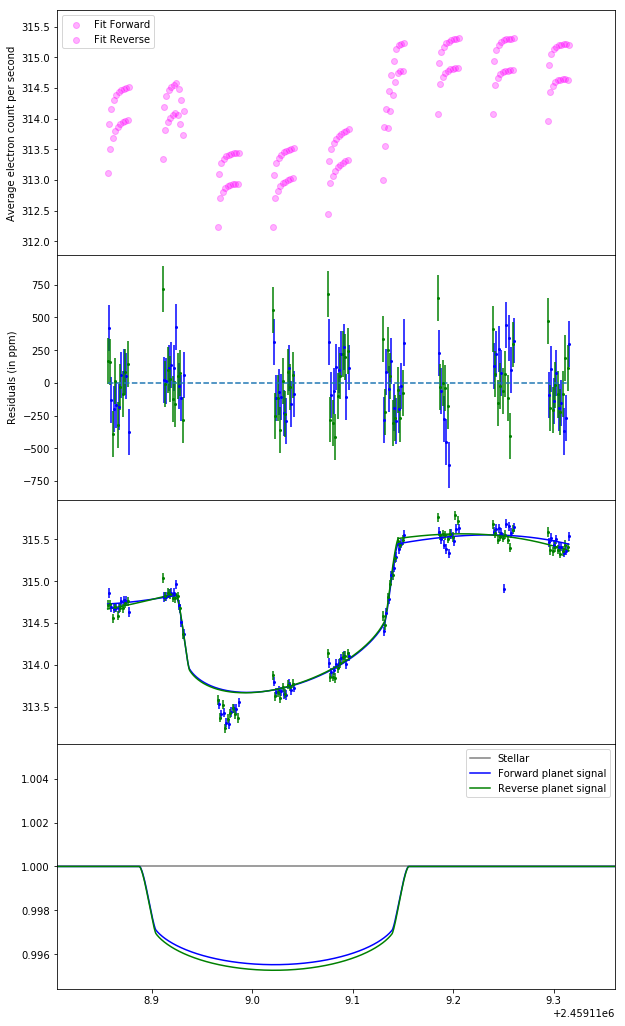

-643.531506748701
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.96263640
    reduced chi-square = 0.00776320
    Akaike info crit   = -645.352829
    Bayesian info crit = -613.394806
[[Variables]]
    depth_F:                  0.00365959 +/- 1.2578e-04 (3.44%) (init = 0.0015)
    depth_R:                  0.00379101 +/- 1.2602e-04 (3.32%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.61388709 +/- 0.03604386 (5.87%) (init = 0.5402312)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00356553 +/- 0.00271763 (76.22%) (init = -0.003)
    V2_R:                     0.00682849 +/- 0.00265521 (38.88%) (init = 

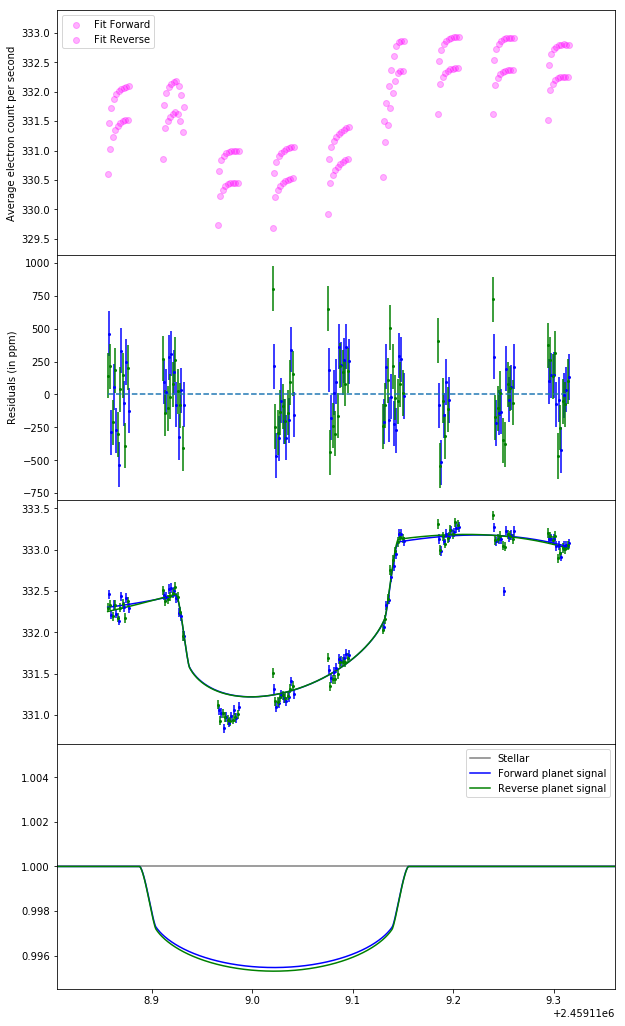

-613.3948061395841
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.87847634
    reduced chi-square = 0.00708449
    Akaike info crit   = -657.703546
    Bayesian info crit = -625.745523
[[Variables]]
    depth_F:                  0.00363538 +/- 1.1984e-04 (3.30%) (init = 0.0015)
    depth_R:                  0.00374708 +/- 1.1988e-04 (3.20%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.57520116 +/- 0.03497636 (6.08%) (init = 0.6138871)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     1.3699e-04 +/- 0.00257032 (1876.29%) (init = -0.003)
    V2_R:                     0.00763325 +/- 0.00251150 (32.90%) (init

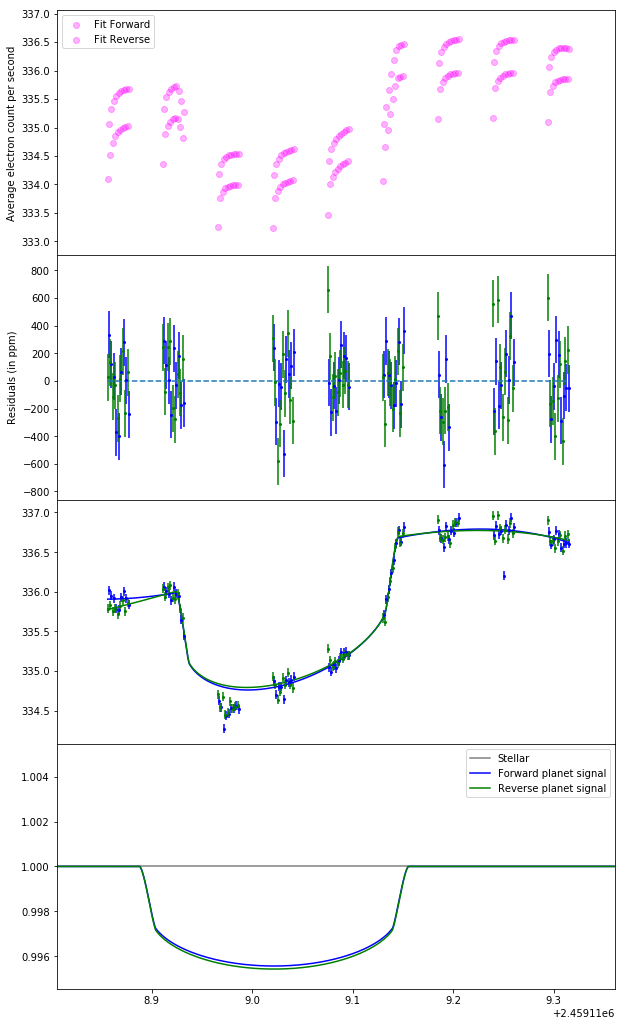

-625.7455232796992
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 1.02152128
    reduced chi-square = 0.00823807
    Akaike info crit   = -637.337545
    Bayesian info crit = -605.379522
[[Variables]]
    depth_F:                  0.00374533 +/- 1.2658e-04 (3.38%) (init = 0.0015)
    depth_R:                  0.00362889 +/- 1.2467e-04 (3.44%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.58968840 +/- 0.03654972 (6.20%) (init = 0.5752012)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00381867 +/- 0.00270532 (70.84%) (init = -0.003)
    V2_R:                     0.00320391 +/- 0.00263584 (82.27%) (init =

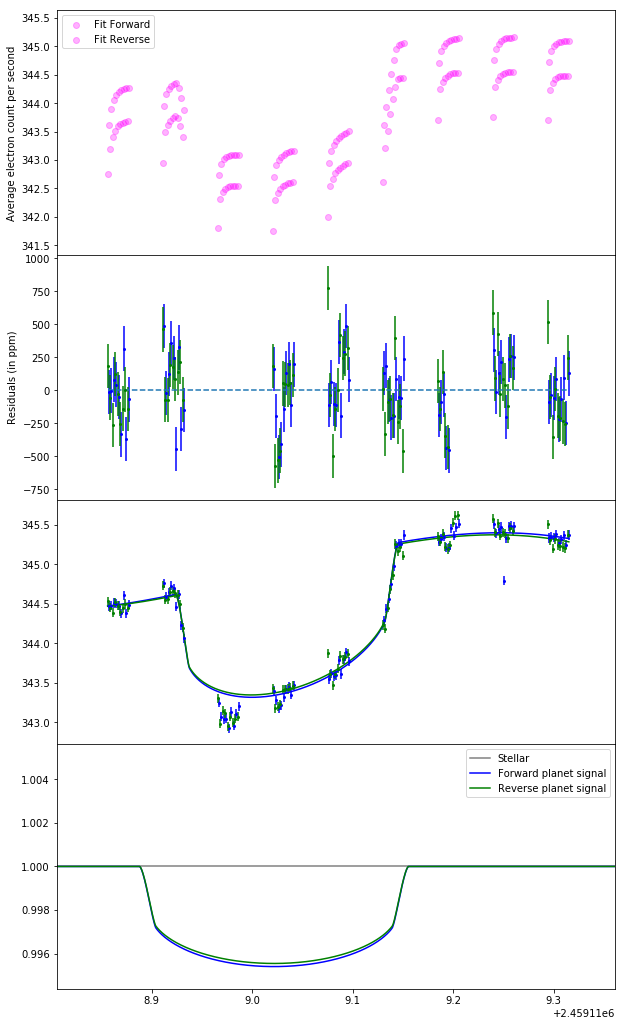

-605.3795220651778
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 1.07056064
    reduced chi-square = 0.00863355
    Akaike info crit   = -631.007461
    Bayesian info crit = -599.049439
[[Variables]]
    depth_F:                  0.00394382 +/- 1.2830e-04 (3.25%) (init = 0.0015)
    depth_R:                  0.00368887 +/- 1.2536e-04 (3.40%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.57762198 +/- 0.03577432 (6.19%) (init = 0.5896884)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00355585 +/- 0.00272252 (76.56%) (init = -0.003)
    V2_R:                     5.2854e-04 +/- 0.00264845 (501.09%) (init 

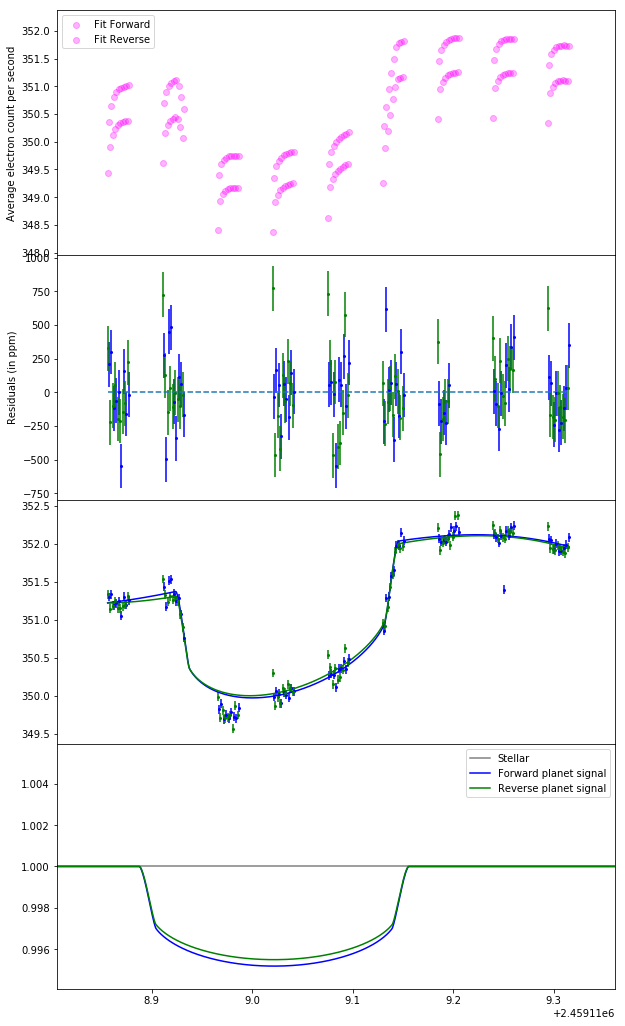

-599.0494386096397
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.99892703
    reduced chi-square = 0.00805586
    Akaike info crit   = -640.357024
    Bayesian info crit = -608.399002
[[Variables]]
    depth_F:                  0.00410696 +/- 1.2460e-04 (3.03%) (init = 0.0015)
    depth_R:                  0.00412491 +/- 1.2391e-04 (3.00%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.54361903 +/- 0.03287547 (6.05%) (init = 0.577622)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00305731 +/- 0.00263968 (86.34%) (init = -0.003)
    V2_R:                     0.00345320 +/- 0.00257261 (74.50%) (init = 

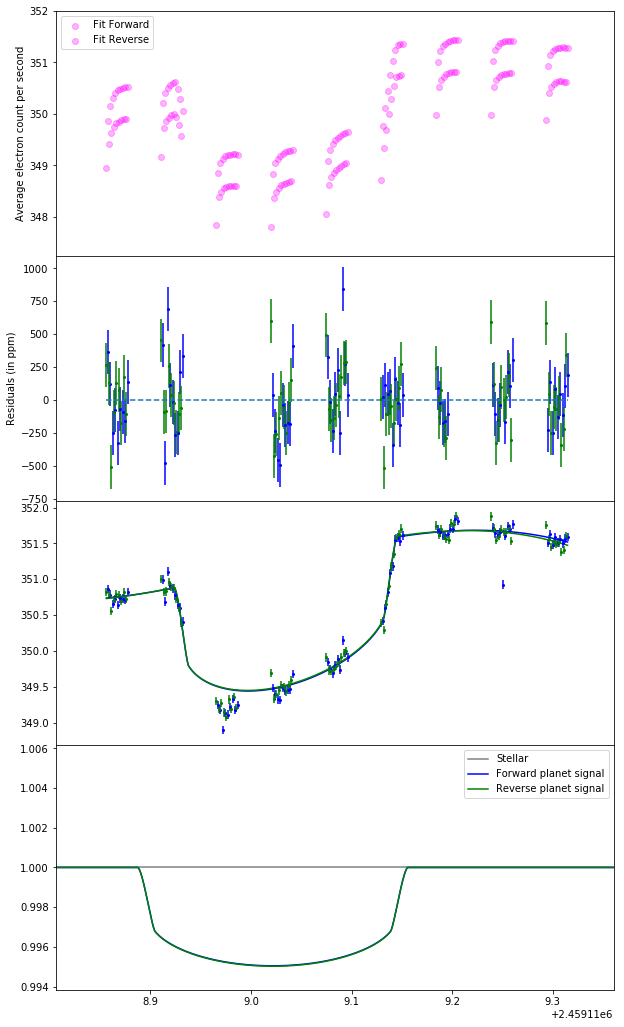

-608.3990015759997
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.82304892
    reduced chi-square = 0.00663749
    Akaike info crit   = -666.501946
    Bayesian info crit = -634.543924
[[Variables]]
    depth_F:                  0.00411828 +/- 1.1595e-04 (2.82%) (init = 0.0015)
    depth_R:                  0.00413444 +/- 1.1532e-04 (2.79%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.55654443 +/- 0.03041404 (5.46%) (init = 0.543619)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00199689 +/- 0.00246126 (123.25%) (init = -0.003)
    V2_R:                     0.00572635 +/- 0.00239959 (41.90%) (init =

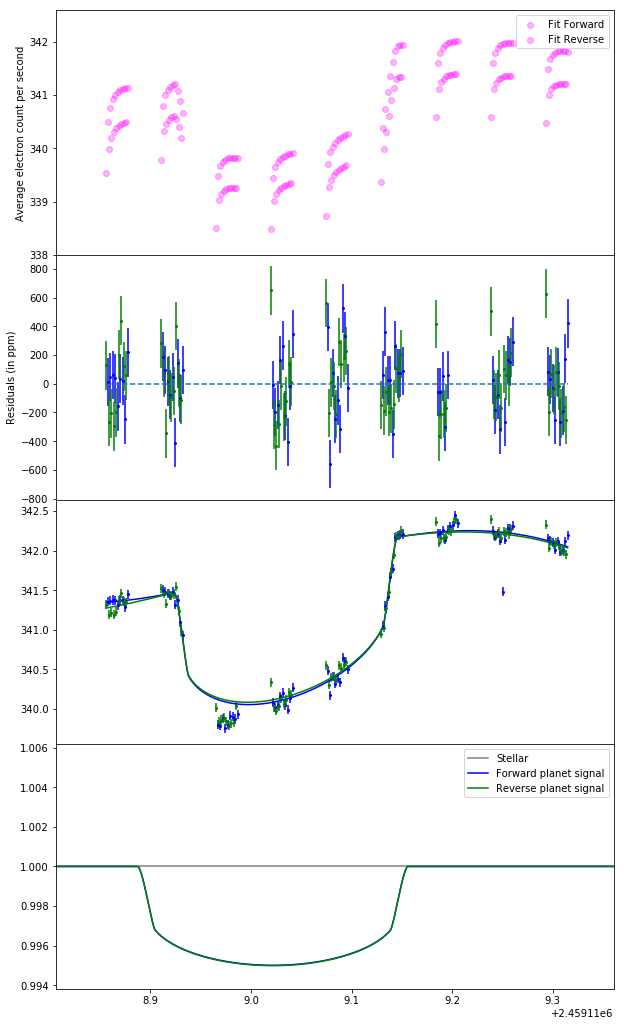

-634.5439237201116
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.78624546
    reduced chi-square = 0.00634069
    Akaike info crit   = -672.677738
    Bayesian info crit = -640.719715
[[Variables]]
    depth_F:                  0.00406809 +/- 1.1275e-04 (2.77%) (init = 0.0015)
    depth_R:                  0.00419316 +/- 1.1282e-04 (2.69%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.57312989 +/- 0.02950658 (5.15%) (init = 0.5565444)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00331886 +/- 0.00240672 (72.52%) (init = -0.003)
    V2_R:                     0.00599833 +/- 0.00234812 (39.15%) (init =

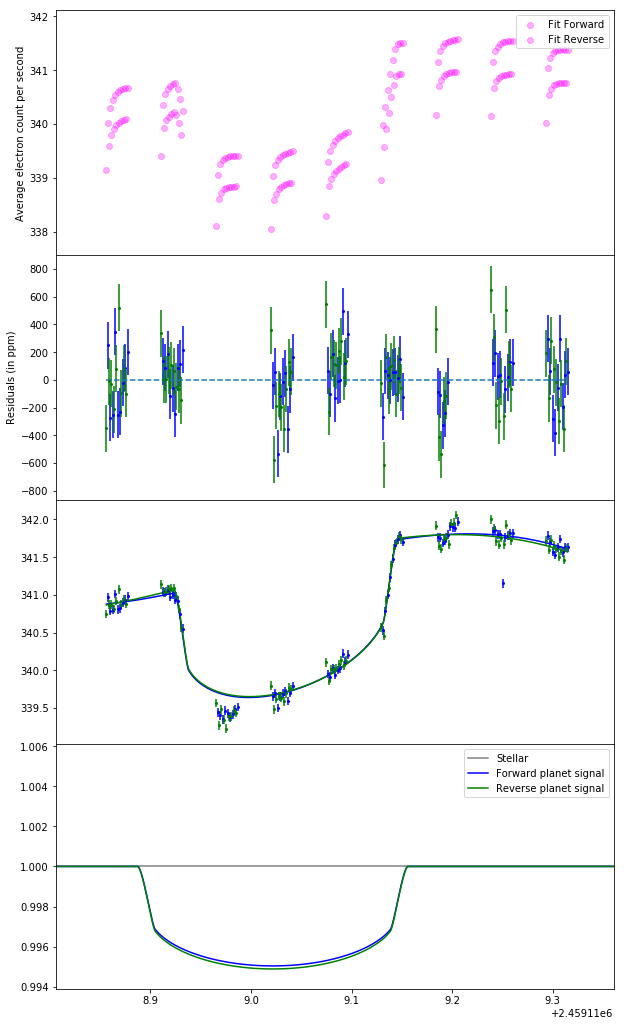

-640.7197149600786
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.78401033
    reduced chi-square = 0.00632266
    Akaike info crit   = -673.062060
    Bayesian info crit = -641.104038
[[Variables]]
    depth_F:                  0.00392725 +/- 1.1466e-04 (2.92%) (init = 0.0015)
    depth_R:                  0.00387494 +/- 1.1350e-04 (2.93%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.57897900 +/- 0.03150211 (5.44%) (init = 0.5731299)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00689458 +/- 0.00244560 (35.47%) (init = -0.003)
    V2_R:                     0.00349654 +/- 0.00238263 (68.14%) (init =

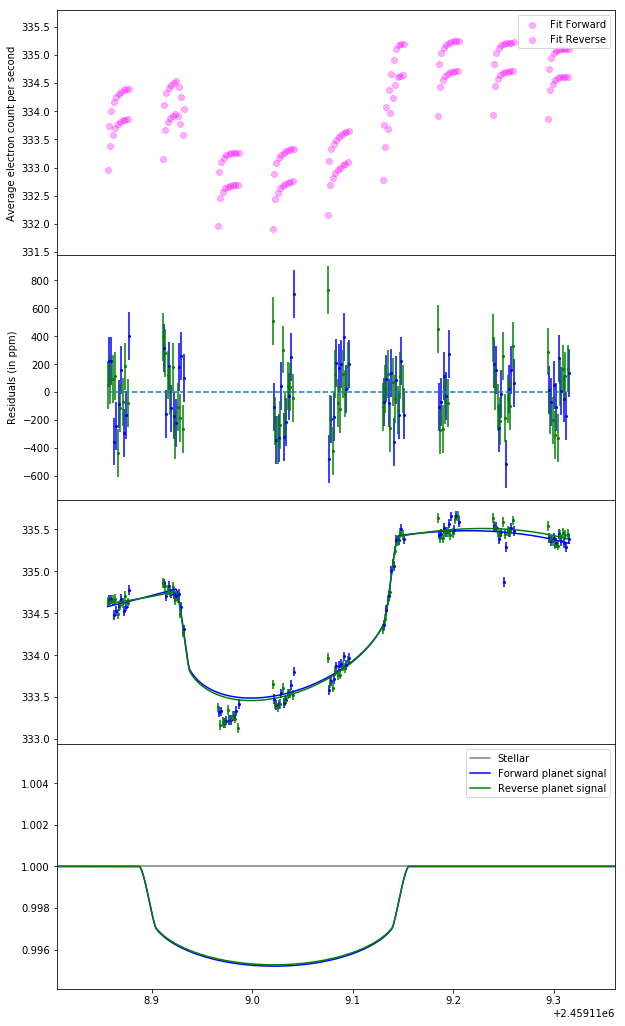

-641.1040378697107
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.79205866
    reduced chi-square = 0.00638757
    Akaike info crit   = -671.683271
    Bayesian info crit = -639.725249
[[Variables]]
    depth_F:                  0.00386567 +/- 1.2090e-04 (3.13%) (init = 0.0015)
    depth_R:                  0.00401935 +/- 1.2104e-04 (3.01%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.49184113 +/- 0.03386354 (6.89%) (init = 0.578979)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00369511 +/- 0.00255212 (69.07%) (init = -0.003)
    V2_R:                     0.00635289 +/- 0.00248984 (39.19%) (init = 

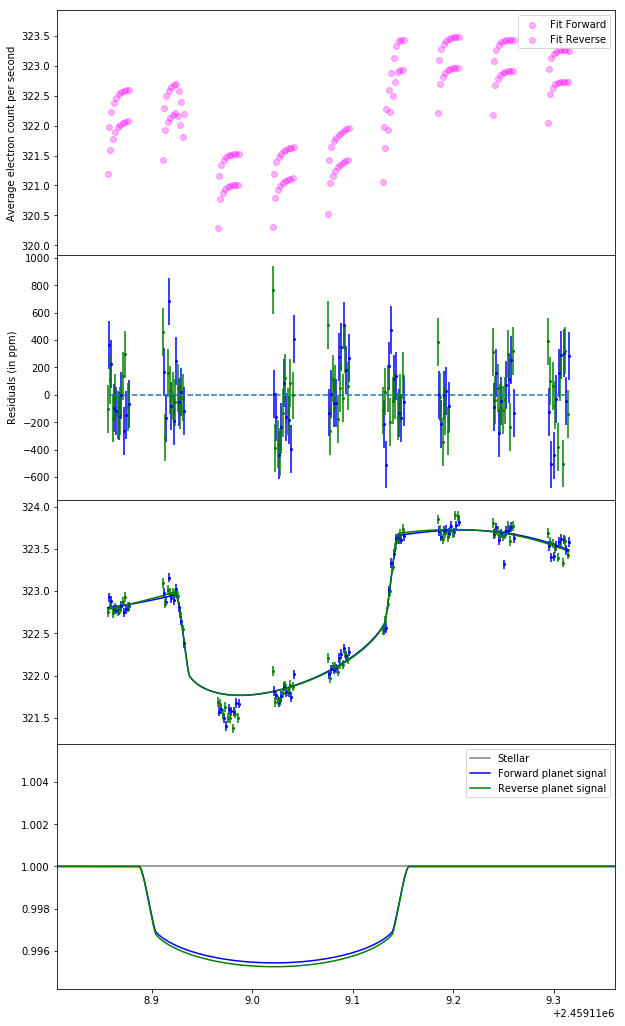

-639.7252485461937
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 135
    # variables        = 11
    chi-square         = 0.61711371
    reduced chi-square = 0.00497672
    Akaike info crit   = -705.376863
    Bayesian info crit = -673.418840
[[Variables]]
    depth_F:                  0.00384955 +/- 1.0547e-04 (2.74%) (init = 0.0015)
    depth_R:                  0.00403614 +/- 1.0591e-04 (2.62%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.54797541 +/- 0.02912582 (5.32%) (init = 0.4918411)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00429220 +/- 0.00224901 (52.40%) (init = -0.003)
    V2_R:                     0.00652829 +/- 0.00219590 (33.64%) (init =

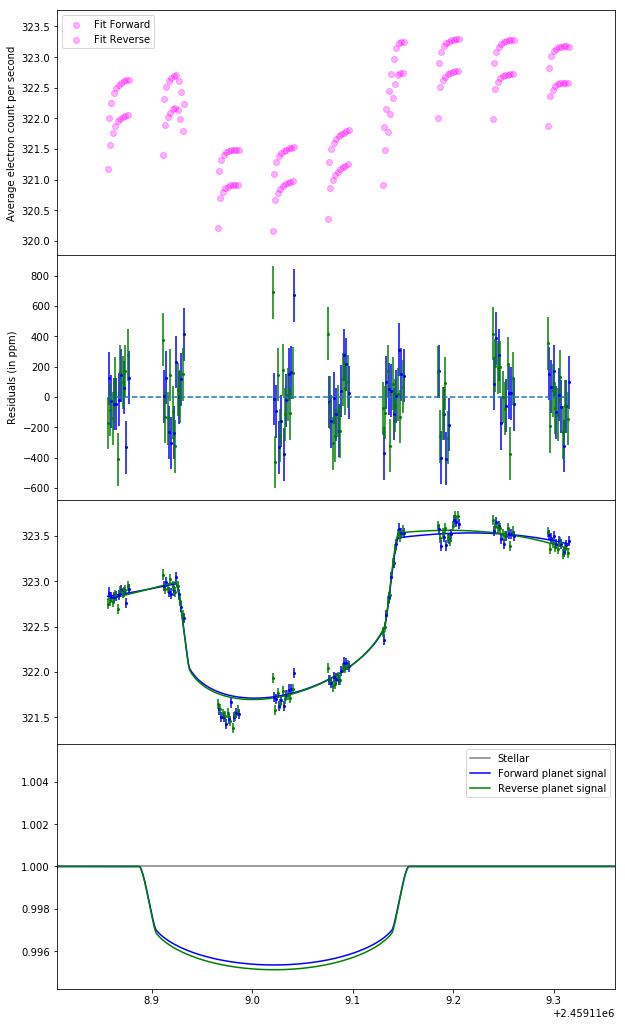

-673.4188404531465
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.72103209
    reduced chi-square = 0.00581477
    Akaike info crit   = -684.366765
    Bayesian info crit = -652.408742
[[Variables]]
    depth_F:                  0.00375536 +/- 1.1851e-04 (3.16%) (init = 0.0015)
    depth_R:                  0.00393441 +/- 1.1898e-04 (3.02%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.55312776 +/- 0.03349113 (6.05%) (init = 0.5479754)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00372065 +/- 0.00253159 (68.04%) (init = -0.003)
    V2_R:                     0.00757083 +/- 0.00247296 (32.66%) (init =

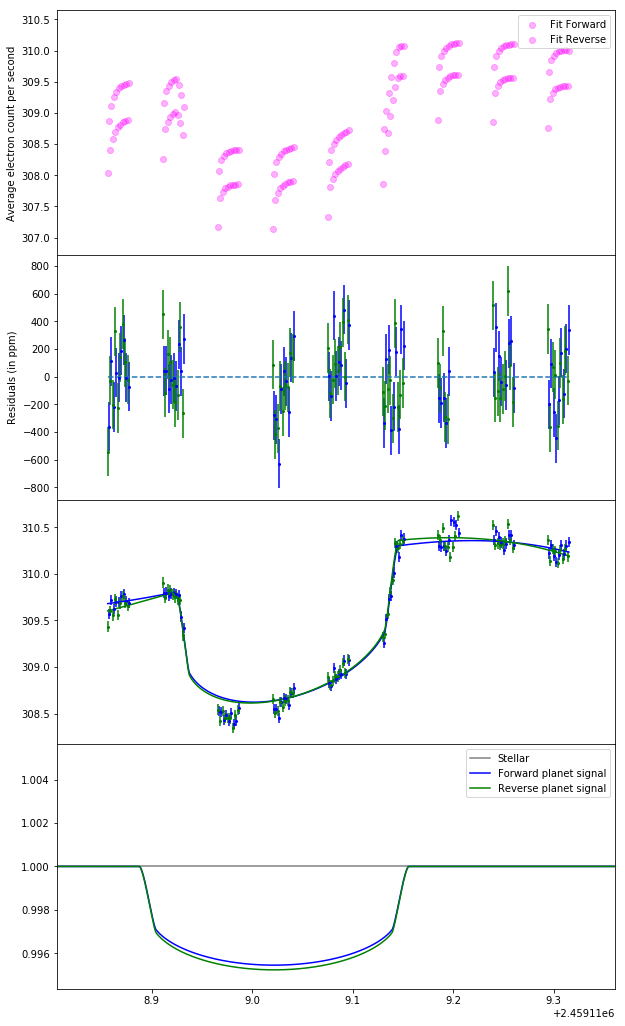

-652.4087424215152
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.69403769
    reduced chi-square = 0.00559708
    Akaike info crit   = -689.518012
    Bayesian info crit = -657.559990
[[Variables]]
    depth_F:                  0.00390623 +/- 1.2460e-04 (3.19%) (init = 0.0015)
    depth_R:                  0.00388521 +/- 1.2352e-04 (3.18%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.48328821 +/- 0.03522102 (7.29%) (init = 0.5531278)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00551431 +/- 0.00261638 (47.45%) (init = -0.003)
    V2_R:                     0.01076262 +/- 0.00254918 (23.69%) (init =

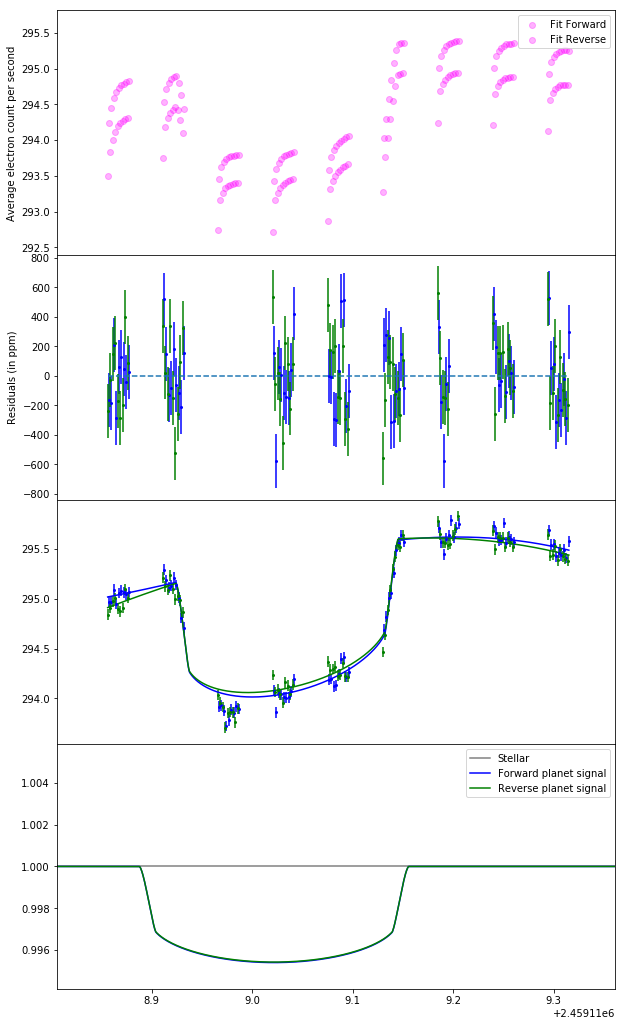

-657.55998951535
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 0.48789860
    reduced chi-square = 0.00393467
    Akaike info crit   = -737.094532
    Bayesian info crit = -705.136510
[[Variables]]
    depth_F:                  0.00381064 +/- 1.0748e-04 (2.82%) (init = 0.0015)
    depth_R:                  0.00413812 +/- 1.0867e-04 (2.63%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.51558869 +/- 0.02980696 (5.78%) (init = 0.4832882)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00563338 +/- 0.00228565 (40.57%) (init = -0.003)
    V2_R:                     0.01291983 +/- 0.00223381 (17.29%) (init = -

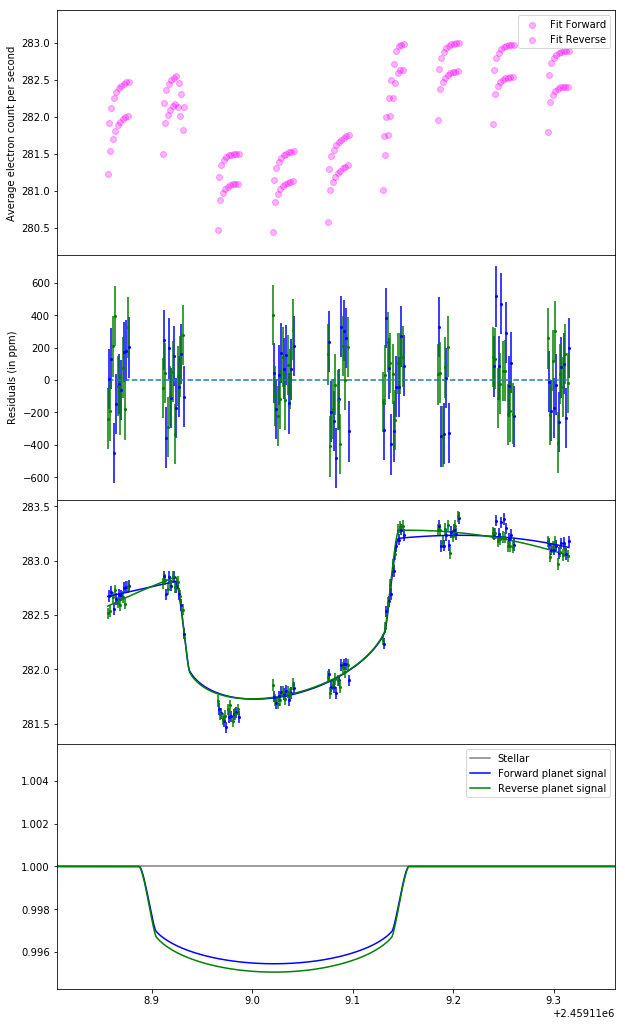

-705.1365097774092
Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 135
    # variables        = 11
    chi-square         = 1.02379768
    reduced chi-square = 0.00825643
    Akaike info crit   = -637.037039
    Bayesian info crit = -605.079017
[[Variables]]
    depth_F:                  0.00398202 +/- 1.6567e-04 (4.16%) (init = 0.0015)
    depth_R:                  0.00409127 +/- 1.6548e-04 (4.04%) (init = 0.0015)
    Mid_transit_time_offset:  0.02158045 (fixed)
    Inclination:              89.517 (fixed)
    Eccentricity:             0.087 (fixed)
    aRs:                      27.40165 (fixed)
    u1:                       0.51159866 +/- 0.04504135 (8.80%) (init = 0.5155887)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                     0.00735004 +/- 0.00350060 (47.63%) (init = -0.003)
    V2_R:                     0.01707785 +/- 0.00341512 (20.00%) (init =

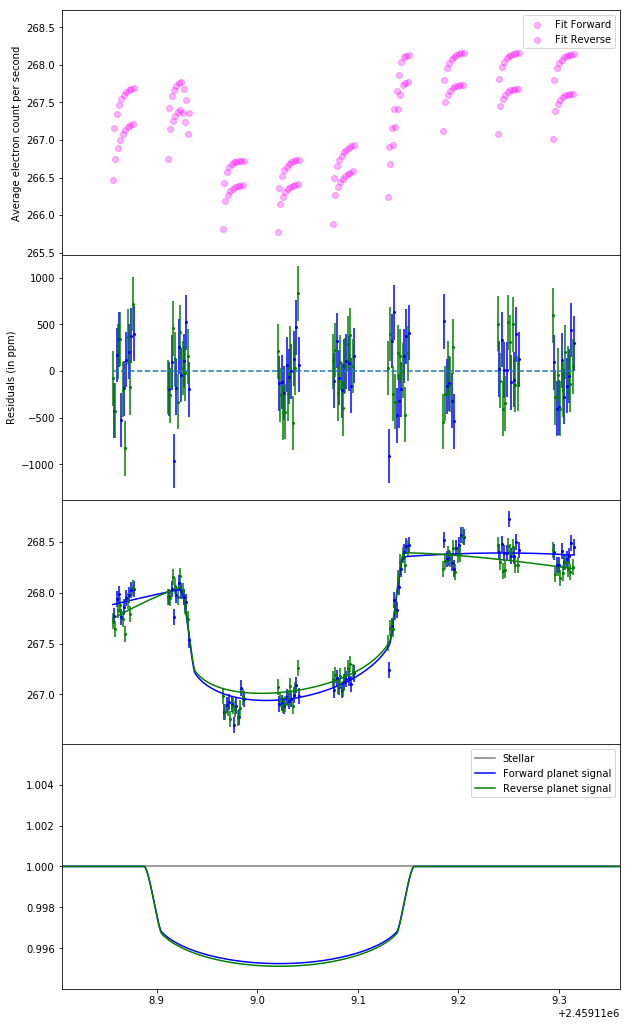

-605.0790169304087


In [136]:
reload(fit_fns)
Planet_LC_multi = fit_fns.Planet('V1298b')
t0 = Planet_LC_multi.sp_params.t0
while t0 < min(Times_org) + Planet_LC_multi.sp_params.per:
    t0 += Planet_LC_multi.sp_params.per
t0 -= 2 * Planet_LC_multi.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
#Excl_first[Sec]=False
#n0=len(Thi)-1
#print (Thi[n0-3:])
#Excl_first[Thi[n0-3:]]=False
exc_indices=[]
#exc_indices.extend(Fir)
#exc_indices.extend(Sec)
#exc_indices.extend(For)
#exc_indices.extend(Fif)
#exc_indices.extend(Six)
exc_indices.extend(Thi)
lis1=[118,119,120,121,122,123,124,125,135]
exc_indices.extend(lis1)
RpRs2 = []
RpRs2_err = []
opt_cs = []
err_cs = []
noise = []
photonnoise = []

bic0=[]
x_shift0=[]
x_shift0_err=[]
for i,wave_bin in enumerate(bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
    Binned_LC = Binned_LC / imagesize
    Binned_LC_err = Binned_LC_err / imagesize
    Binned_LC_full, Binned_LC_full_err = Binned_LC.copy(), Binned_LC_err.copy()
    Binned_LC_err /= np.max(Binned_LC)
    Binned_LC /= np.max(Binned_LC)
    opt_c, err_c, chi2_c, bic_c,out,ec_lc = Planet_LC_multi.Fit_with_recte_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           Binned_LC_full[Excl_first], Binned_LC_full_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first],data_xshift[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear',u1=u11,u2=u22, 
                                                           fix_inclination=True,
                                                           fix_eccentricity=True, 
                                                           nosat=True,
                                                           deltat=deltat, a=aRs, fix_aRs=True,
                                                           t0=t0, exptime = exptime, exc_indices=exc_indices,
                                                           verbose=True,polynomial=True,vary_cxshift=False,
                                                           Transit=True,vary_recte=False,E0_s=e_os,E0_f=e_of,Delta_Es=del_es,Delta_Ef=del_ef,c_xshift=0.0)
    RpRs2.append(opt_c[0])
    RpRs2_err.append(err_c[0])
    opt_cs.append(opt_c)
    err_cs.append(err_c)
 #   print (opt_c[0],err_c[0])
    fit_opt = opt_c[:-3]
#    print (opt_c[-1],err_c[-1])
    print (bic_c)
    x_shift0.append(opt_c[-1])
    x_shift0_err.append(err_c[-1])
    bic0.append(bic_c)
'''

    LC_new = Planet_LC_multi.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          exptime=exptime,
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]


    noise.append(np.sqrt(np.sum((Binned_LC_full[Excl_first] - LC_new)**2./ Binned_LC_full[Excl_first]**2.) / len(Binned_LC_full[Excl_first])) *1.e6)
    photonnoise.append(1. / np.sqrt(np.mean(Binned_LC_full[Excl_first] * len(wave_bin) * imagesize * exptime)) * 1.e6)



'''
RpRs2 = np.array(RpRs2)
RpRs2_err = np.array(RpRs2_err)



#print (RpRs2_err)
#print (err_c,opt_c[0])

Text(0.5,0,'Wavelength (microns)')

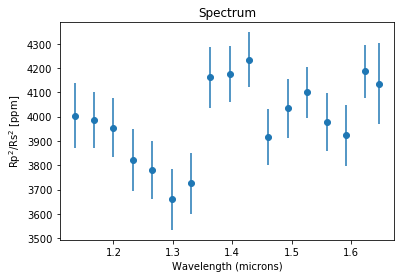

In [63]:
#You can load in a previous spectrum:
#base_wave, base, base_err = np.genfromtxt('KELT-9b_spectrum.txt').T
#if you have Forward and reverse scanned data you can do:
#eds_total, eds_total_err = fit_fns.arithmic_mean(np.array([RpRs_c_F, RpRs_c_R]), 
#                                                 np.array([RpRs_c_F_err, RpRs_c_R_err]), 
#                                                 axis=0, weighted=True)


#plt.errorbar(bins_avg_wave, eds_total, eds_total_err, fmt='o')
#plt.errorbar(base_wave, base, base_err, fmt='o', color='k', alpha=0.3)

#But now we only do a forward scanned spectrum:
plt.errorbar(bins_avg_wave, RpRs2*1e6, RpRs2_err*1e6, fmt='o')
#print (np.mean)
plt.title('Spectrum')
plt.ylabel('Rp$^2$/Rs$^2$ [ppm]')
plt.xlabel('Wavelength (microns)')
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/V1298_transmission_spectra.pdf',format='pdf')
#x,y,z=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/deming_ascii.txt',skiprows=5,usecols=(0,1,2),unpack=True)
#plt.errorbar(x,y*1e-6,z*1e-6,ls='none',marker='.')

[-1.3576721974553278e-08, -1.021735343739578e-08, -1.0982697066938093e-08, -1.2841443272790079e-08, -1.1510156976372377e-08, -1.2862640478843677e-08, -1.2679930929687983e-08, -1.229596410071372e-08, -9.996169725929083e-09, -1.042513846706587e-08, -1.0649822037713056e-08, -1.0892694540768624e-08, -8.544745613028819e-09, -1.2241977137423698e-08, -1.1967933501185494e-08, -9.26428440341015e-09, -2.0155803842309394e-08]


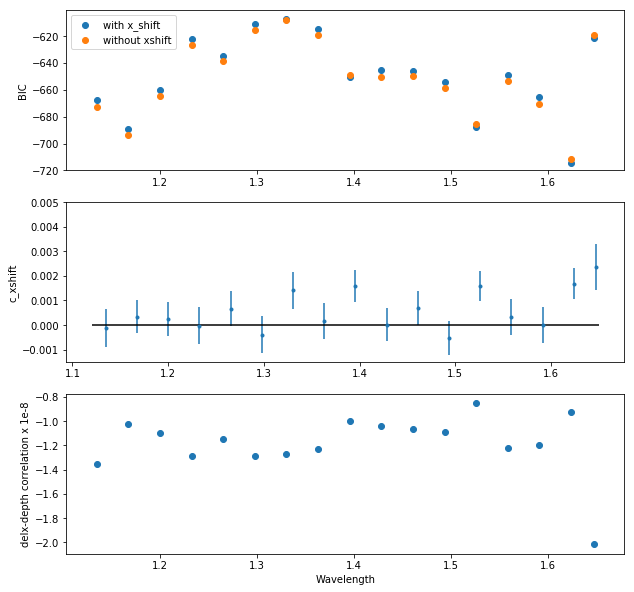

In [30]:
#plt.scatter(bins_avg_wave,x_shift)
fig, axs = plt.subplots(3, 1,figsize=(10,10))
axs[0].scatter(bins_avg_wave,bic,label='with x_shift')
axs[0].scatter(bins_avg_wave,bic0,label='without xshift')
axs[0].legend()
axs[1].errorbar(bins_avg_wave,x_shift,yerr=x_shift_err,ls='none',marker='.')
axs[1].hlines(0,1.12,1.65)
axs[1].set_ylim(-0.15e-2,0.5e-2)
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('c_xshift')
axs[2].set_xlabel('Wavelength')
axs[2].scatter(bins_avg_wave,np.array(cov)*1e8)
print cov
axs[2].set_ylabel('delx-depth correlation x 1e-8')
plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/bic_xshift_wavelength.pdf',format='pdf')

In [65]:
print(out.covar[0,0])
out.covar.shape
#out.covar
#out.params.keys()
#vars(out)
out.covar[11]

2.649807393560647e-08


array([-2.01410211e-08, -1.73517662e-08, -5.55990765e-06,  1.58734494e-06,
        1.53185374e-06, -9.24369217e-06, -6.95984900e-06, -3.37611868e-06,
       -3.15923135e-06,  2.50513798e-06,  2.26813013e-06,  8.68278172e-07])

<ErrorbarContainer object of 3 artists>

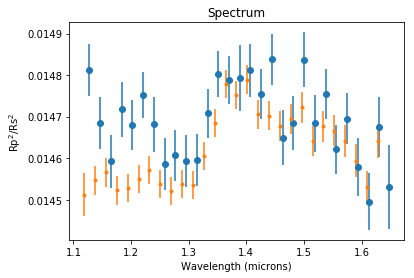

In [94]:
plt.errorbar(bins_avg_wave, RpRs2, RpRs2_err, fmt='o')

plt.title('Spectrum')
plt.ylabel('Rp$^2$/Rs$^2$')
plt.xlabel('Wavelength (microns)')
x,y,z=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/deming_ascii.txt',skiprows=5,usecols=(0,1,2),unpack=True)
plt.errorbar(x,y*1e-6,z*1e-6,ls='none',marker='.')

In [15]:
filelist=['ie9301bhq','ie93g1g3q']
x,y=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+filelist[0]+'_spec.txt',usecols=(0,1),skiprows=2,unpack=True)
x1,y1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+filelist[1]+'_spec.txt',usecols=(0,1),skiprows=2,unpack=True)

(1.5, 1.53)

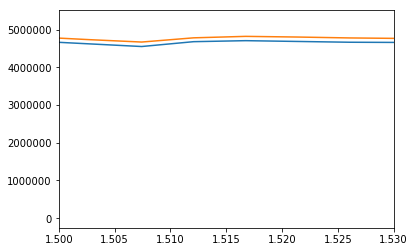

In [18]:
plt.plot(x,y)
plt.plot(x1,y1)
plt.xlim(1.5,1.53)

In [17]:
w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93g1g3q_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w1,f1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93g1g5q_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w_ref,f_ref=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93g1g1q_spec.txt',skiprows=2,usecols=(0,1),unpack=True)

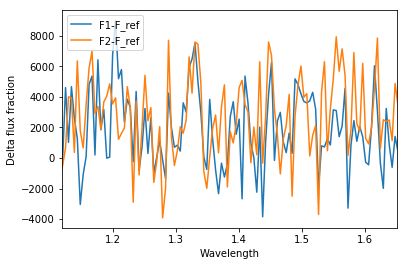

In [18]:
#plt.plot(w0,f0)
#plt.plot(w1,f1)
#plt.plot(w_ref,f_ref)
plt.plot(w_ref,(f0-f_ref),label='F1-F_ref')
plt.plot(w_ref,(f1-f_ref),label='F2-F_ref')
plt.legend()
plt.ylabel('Delta flux fraction')
plt.xlabel('Wavelength')
plt.xlim(1.12,1.65)
plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/flux_dif.pdf',format='pdf')

In [16]:
w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1cgq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w1,f1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1ciq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w_ref,f_ref=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1ckq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)





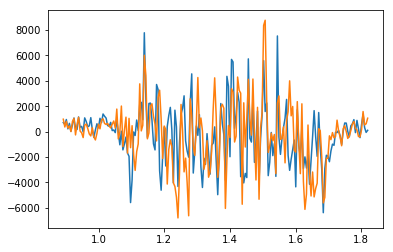

In [29]:
plt.plot(w_ref,f0-f_ref)
plt.plot(w_ref,f1-f_ref)

In [13]:
import os
import numpy as np
filelist=[]

for file in os.listdir("/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output"):
    if (file.startswith("ie93") and file.endswith(".txt") and not file.endswith("subs_spec.txt")):
        #print(os.path.join("/mydir", file))
        filelist.append(file)
print (filelist)

['ie9301btq_spec.txt', 'ie93a1c5q_spec.txt', 'ie93h1goq_spec.txt', 'ie93f1fbq_spec.txt', 'ie93c1dfq_spec.txt', 'ie93a1ciq_spec.txt', 'ie93d1ebq_spec.txt', 'ie93g1fqq_spec.txt', 'ie93b1crq_spec.txt', 'ie93d1e3q_spec.txt', 'ie9301byq_spec.txt', 'ie93i1h4q_spec.txt', 'ie93a1c8q_spec.txt', 'ie93b1d1q_spec.txt', 'ie93h1gbq_spec.txt', 'ie93e1f0q_spec.txt', 'ie9301blq_spec.txt', 'ie93f1f3q_spec.txt', 'ie93a1cdq_spec.txt', 'ie93g1g1q_spec.txt', 'ie93f1f8q_spec.txt', 'ie93i1gzq_spec.txt', 'ie93d1edq_spec.txt', 'ie9301brq_spec.txt', 'ie93d1e8q_spec.txt', 'ie93b1cyq_spec.txt', 'ie93f1fdq_spec.txt', 'ie93h1giq_spec.txt', 'ie93e1ewq_spec.txt', 'ie93a1c3q_spec.txt', 'ie93a1cbq_spec.txt', 'ie9301bjq_spec.txt', 'ie93c1dmq_spec.txt', 'ie93h1g8q_spec.txt', 'ie93f1f5q_spec.txt', 'ie93e1eoq_spec.txt', 'ie93i1gwq_spec.txt', 'ie93g1fzq_spec.txt', 'ie93d1e5q_spec.txt', 'ie93i1h2q_spec.txt', 'ie93d1dxq_spec.txt', 'ie93b1ctq_spec.txt', 'ie93e1ezq_spec.txt', 'ie93b1d7q_spec.txt', 'ie93f1fiq_spec.txt', 'ie93h1gd

In [14]:
from scipy.integrate import simps
import linecache
#w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1clq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
I=np.array([])
I1=np.array([])
time=np.array([])
#print (sorted(filelist))
#I=simps(f0,w0)
flux_tot=np.array([])
for file in sorted(filelist):
    w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+file,skiprows=2,usecols=(0,1),unpack=True)
#    w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+file,skiprows=2,usecols=(0,1),unpack=True)
    t0=linecache.getline('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+file,2)
    t0=t0.split()
 #   print (t0)
    t=np.float64(t0[1])
 #   print (t0)
    time=np.append(time,t)
    f_temp=f0[np.where(w0>1.35)[0]]
    w_temp=w0[np.where(w0>1.35)[0]]
    f_temp=f_temp[np.where(w_temp<1.45)[0]]
    w_temp=w_temp[np.where(w_temp<1.45)[0]]
    I00=simps(f_temp,w_temp)
    #print (len(w_temp))
    f_temp=f0[np.where(w0>1.18)[0]]
    w_temp=w0[np.where(w0>1.18)[0]]
    f_temp=f_temp[np.where(w_temp<1.28)[0]]
    w_temp=w_temp[np.where(w_temp<1.28)[0]]
    I11=simps(f_temp,w_temp)
    f_temp=f0[np.where(w0>1.45)[0]]
    w_temp=w0[np.where(w0>1.45)[0]]
    f_temp=f_temp[np.where(w_temp<1.55)[0]]
    w_temp=w_temp[np.where(w_temp<1.55)[0]]
    I01=simps(f_temp,w_temp)
    I=np.append(I,I00/I01)
    I1=np.append(I1,I11/I01)
    f_temp=f0[np.where(w0>1.15)[0]]
    w_temp=w0[np.where(w0>1.15)[0]]
    f_temp=f_temp[np.where(w_temp<1.65)[0]]
    w_temp=w_temp[np.where(w_temp<1.65)[0]]
    flux_tot=np.append(flux_tot,simps(f_temp,w_temp))
time=sorted(time)
time=time-time[0]
#print (I00/I01)
#print (sorted(filelist),len(sorted_times))



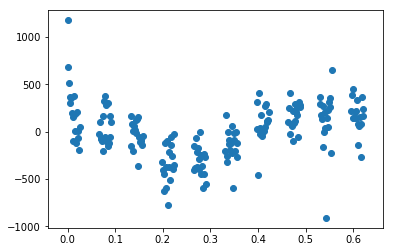

In [15]:
#plt.scatter(time[10:],(I[10:]-np.mean(I[10:]))*1e6)
#plt.ylim(-1500,1500)
#plt.scatter(flux_tot[10:],(I[10:]-np.mean(I[10:]))*1e6)
plt.scatter(sorted_times,(I-np.mean(I))*1e6)

(array(['ie93i1h5q_spec.txt'], dtype='|S18'), array(['ie93h1gpq_spec.txt'], dtype='|S18'))


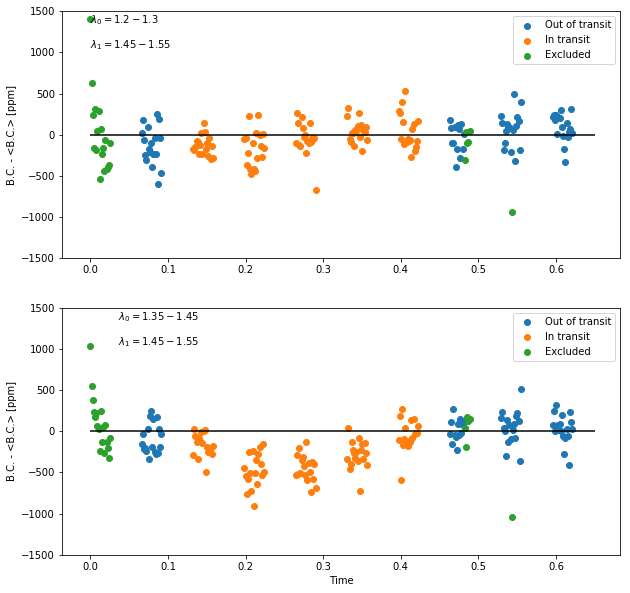

In [16]:
#plt.scatter(sorted_times,(I-np.median(I))*1e6)
Exclude_first=np.ones(len(time),dtype=bool)
Exclude_first[Fir]=False
Exclude_first[153]=False
#Exclude_first[For]=False
lis1=[139,140,141,142,143]
#lis1=lis1+18
Exclude_first[lis1]=False
#Exclude_first[Sev]=False
#Exclude_first[Sec]=False
#Exclude_first[Sec]=False
excl_lis=[]
#excl_lis.extend(Fir)
excl_lis.extend(For)
excl_lis.extend(Fif)
excl_lis.extend(Six)
excl_lis.extend(Sev)
excl_lis.extend(Thi)
#excl_lis.extend(Sec)
#excl_lis.append(153)
filelist_temp=np.array(sorted(filelist))
#print (np.array(filelist2)[inc],filelist[inc])
#filelist2=sorted(filelist[inc])
#print (filelist2[inc])

inc=np.ones(len(sorted_times),dtype=bool)
inc[excl_lis]=False

fig, axs = plt.subplots(2, 1,figsize=(10,10))

filelist2=filelist_temp[inc*Exclude_first]
axs[0].scatter(time[inc*Exclude_first],(I1[inc*Exclude_first]-np.mean(I1[inc*Exclude_first]))*1e6,label='Out of transit')
axs[1].scatter(time[inc*Exclude_first],(I[inc*Exclude_first]-np.mean(I[inc*Exclude_first]))*1e6,label='Out of transit')
#print (I[inc]-np.mean(I[inc]))*1e6
print (filelist2[np.where(I[inc*Exclude_first]==min(I[inc*Exclude_first]))[0]],filelist2[np.where(I[inc*Exclude_first]==max(I[inc*Exclude_first]))[0]])
axs[0].scatter(time[~inc*Exclude_first],(I1[~inc*Exclude_first]-np.mean(I1[inc*Exclude_first]))*1e6,label='In transit')
axs[1].scatter(time[~inc*Exclude_first],(I[~inc*Exclude_first]-np.mean(I[inc*Exclude_first]))*1e6,label='In transit')
#axs[0].set_xlim(0.0,0.65)
#axs[1].set_xlim(0,0,0.65)
axs[0].set_ylabel('B.C. - <B.C.> [ppm]')
axs[1].set_ylabel('B.C. - <B.C.> [ppm]')
plt.xlabel('Time')
axs[0].set_ylim(-1500,1500)
axs[1].set_ylim(-1500,1500)
#plt.ylim(min(I),max(I))
axs[0].hlines(0.0,0.0,0.65)
axs[1].hlines(0.0,0.0,0.65)
#print (np.mean(I[inc]))


axs[0].annotate(r'${\lambda}_{0}=1.2-1.3$', xy=(0.05, 0.95), xycoords='axes fraction')
axs[0].annotate(r'${\lambda}_{1}=1.45-1.55$', xy=(0.05, 0.85), xycoords='axes fraction')
axs[1].annotate(r'${\lambda}_{0}=1.35-1.45$', xy=(0.1, 0.95), xycoords='axes fraction')
axs[1].annotate(r'${\lambda}_{1}=1.45-1.55$', xy=(0.1, 0.85), xycoords='axes fraction')
axs[1].scatter(time[~Exclude_first],(I[~Exclude_first]-np.mean(I[inc*Exclude_first]))*1e6,label='Excluded')
axs[0].scatter(time[~Exclude_first],(I1[~Exclude_first]-np.mean(I1[inc*Exclude_first]))*1e6,label='Excluded')
axs[0].legend()
axs[1].legend()
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/Blueness_color_v1298_exclude_second.pdf',format='pdf')

In [22]:
from scipy.integrate import simps
import linecache
#w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1clq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
I=np.array([])
I1=np.array([])
time=np.array([])
#print (sorted(filelist))
#I=simps(f0,w0)
flux_tot=np.array([])
for file in sorted(filelist):
    w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+file,skiprows=2,usecols=(0,1),unpack=True)
#    w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+file,skiprows=2,usecols=(0,1),unpack=True)
    t0=linecache.getline('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+file,2)
    t0=t0.split()
 #   print (t0)
    t=np.float64(t0[1])
 #   print (t0)
    time=np.append(time,t)
    f_temp=f0[np.where(w0>1.4)[0]]
    w_temp=w0[np.where(w0>1.4)[0]]
    f_temp=f_temp[np.where(w_temp<1.5)[0]]
    w_temp=w_temp[np.where(w_temp<1.5)[0]]
    I00=simps(f_temp,w_temp)
    #print (len(w_temp))
    f_temp=f0[np.where(w0>1.3)[0]]
    w_temp=w0[np.where(w0>1.3)[0]]
    f_temp=f_temp[np.where(w_temp<1.4)[0]]
    w_temp=w_temp[np.where(w_temp<1.4)[0]]
    I11=simps(f_temp,w_temp)
    I1=np.append(I1,I00/I11)

180
180


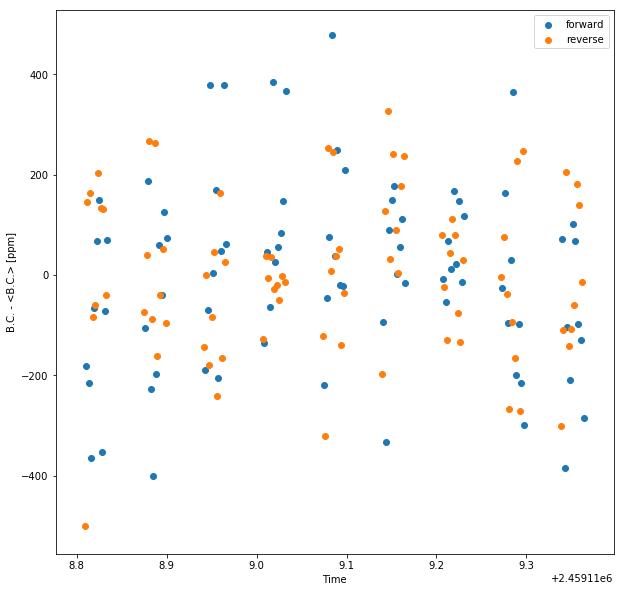

In [23]:
Exclude_first=np.ones(len(time),dtype=bool)
print (len(time))
Exclude_first[Fir]=False
#Exclude_first[153]=False
#Exclude_first[For]=False
#lis1=[139,140,141,142,143]
#lis1=lis1+18
#Exclude_first[lis1]=False
#Exclude_first[Sev]=False
#Exclude_first[Sec]=False
#Exclude_first[Sec]=False
excl_lis=[]
#excl_lis.extend(Fir)
#excl_lis.extend(Sec)
#excl_lis.extend(Thi)
#excl_lis.extend(For)
#excl_lis.extend(Sev)
#excl_lis.extend(Thi)
#excl_lis.extend(Sec)
#excl_lis.append(153)
filelist_temp=np.array(sorted(filelist))
#print (np.array(filelist2)[inc],filelist[inc])
#filelist2=sorted(filelist[inc])
#print (filelist2[inc])

inc=np.ones(len(time),dtype=bool)
print (len(sorted_times))
inc[excl_lis]=False

fig, axs = plt.subplots(1, 1,figsize=(10,10))

filelist2=filelist_temp[inc*Exclude_first]
axs.scatter(time[inc*Exclude_first*Forwardscanned],(I1[inc*Exclude_first*Forwardscanned]-np.mean(I1[inc*Exclude_first*Forwardscanned]))*1e6,label='forward')
#axs[1].scatter(time[inc*Exclude_first],(I[inc*Exclude_first]-np.mean(I[inc*Exclude_first]))*1e6,label='Out of transit')
#print (I[inc]-np.mean(I[inc]))*1e6
#print (filelist2[np.where(I[inc*Exclude_first]==min(I[inc*Exclude_first]))[0]],filelist2[np.where(I[inc*Exclude_first]==max(I[inc*Exclude_first]))[0]])
axs.scatter(time[inc*Exclude_first*~Forwardscanned],(I1[inc*Exclude_first*~Forwardscanned]-np.mean(I1[inc*Exclude_first*~Forwardscanned]))*1e6,label='reverse')
#axs[1].scatter(time[~inc*Exclude_first],(I[~inc*Exclude_first]-np.mean(I[inc*Exclude_first]))*1e6,label='In transit')
#axs[0].set_xlim(0.0,0.65)
#axs[1].set_xlim(0,0,0.65)
axs.set_ylabel('B.C. - <B.C.> [ppm]')
#axs[1].set_ylabel('B.C. - <B.C.> [ppm]')
plt.xlabel('Time')
#axs.set_ylim(-2500,1500)
#axs[1].set_ylim(-1500,1500)
#plt.ylim(min(I),max(I))
#axs[0].hlines(0.0,0.0,0.65)
#axs[1].hlines(0.0,0.0,0.65)
#print (np.mean(I[inc]))
plt.legend()

Text(0,0.5,'Flux ')

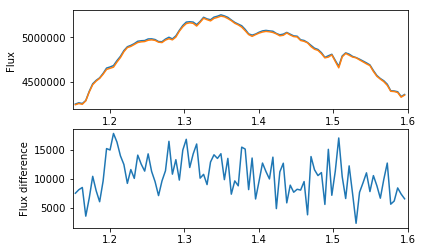

In [66]:
exp_list=['ie93a1clq']
fig, axs = plt.subplots(2, 1)
from scipy.integrate import simps
for i in range(0,len(exp_list)):
    w1,f1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+exp_list[i]+'_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
    w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93i1h8q_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
#from scipy.integrate import simps
#c1=simps(f0,w0)
#c2=simps(f1,w1)
#    c1=1.0
#    c2=1.0
    f_temp=f0[np.where(w0>1.15)[0]]
    w_temp=w0[np.where(w0>1.15)[0]]
    f_temp=f_temp[np.where(w_temp<1.6)[0]]
    w_temp=w_temp[np.where(w_temp<1.6)[0]]
    c1=simps(f_temp,w_temp)
    f_temp1=f1[np.where(w1>1.15)[0]]
    w_temp1=w1[np.where(w1>1.15)[0]]
    f_temp1=f_temp1[np.where(w_temp1<1.6)[0]]
    w_temp1=w_temp1[np.where(w_temp1<1.6)[0]]
    c2=simps(f_temp1,w_temp1)
#    c1=1.0
#    c2=1.0
#w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93h1gnq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
#fig, axs = plt.subplots(2, 1)
    axs[0].plot(w_temp,f_temp/c1)
    axs[0].plot(w_temp1,f_temp1/c2)
#figure()
    axs[1].plot(w_temp,f_temp/c1-f_temp1/c2)
    axs[0].set_xlim(1.15,1.6)
axs[1].set_xlim(1.15,1.6)
#axs[0].set_ylim(3.5e6,5.5e6)
#axs[0].set_ylim(1.0,2.5)
axs[1].set_ylabel('Flux difference')
axs[0].set_ylabel('Flux ')
#axs[1].hlines(0,1.1,1.65)
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/stel_spectra_difference.pdf',format='pdf')

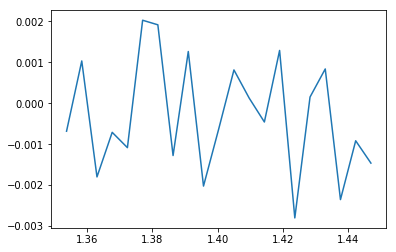

In [71]:
w1,f1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+'ie93a1clq'+'_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93i1h8q_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
   
f_temp=f0[np.where(w0>1.15)[0]]
w_temp=w0[np.where(w0>1.15)[0]]
f_temp=f_temp[np.where(w_temp<1.6)[0]]
w_temp=w_temp[np.where(w_temp<1.6)[0]]
c1=simps(f_temp,w_temp)
f_temp1=f1[np.where(w1>1.15)[0]]
w_temp1=w1[np.where(w1>1.15)[0]]
f_temp1=f_temp1[np.where(w_temp1<1.6)[0]]
w_temp1=w_temp1[np.where(w_temp1<1.6)[0]]
c2=simps(f_temp1,w_temp1) 

x=np.where(w1>1.35)[0].tolist()
y=np.where(w1<1.45)[0].tolist()
indices1=np.intersect1d(x,y)
#print (indices)

x=np.where(w0>1.35)[0].tolist()
y=np.where(w0<1.45)[0].tolist()
indices2=np.intersect1d(x,y)
f0=f0/c1
f1=f1/c2

#print (len(indices1),len(indices2))
 
plt.plot(w0[indices1],f0[indices1]-f1[indices1])

Text(0.5,0,'Time')

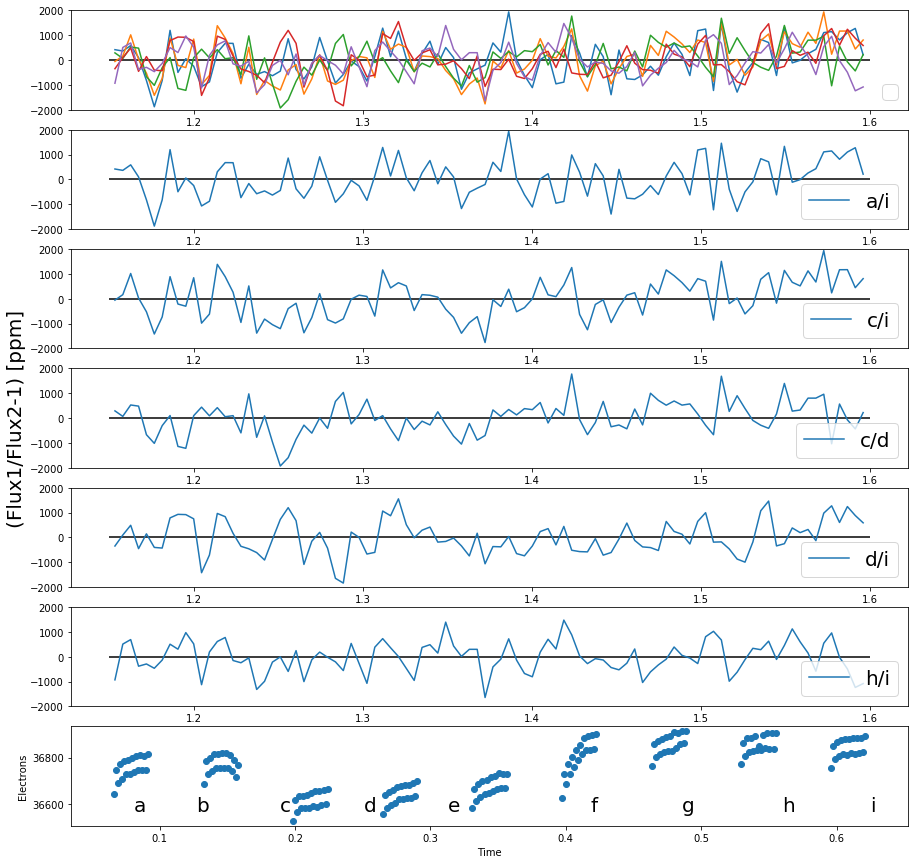

In [70]:
#. Spectrum ratio. looking for bright spot

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1c8q_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w1,f1=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93c1dfq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w2,f2=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93d1e0q_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w3,f3=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93h1gdq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
w4,f4=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93i1gwq_spec.txt',skiprows=2,usecols=(0,1),unpack=True)

f_temp=f0[np.where(w0>1.15)[0]]
w_temp=w0[np.where(w0>1.15)[0]]
f_temp=f_temp[np.where(w_temp<1.6)[0]]
w_temp=w_temp[np.where(w_temp<1.6)[0]]
c1=simps(f_temp,w_temp)
f_temp4=f4[np.where(w4>1.15)[0]]
w_temp4=w4[np.where(w4>1.15)[0]]
f_temp4=f_temp4[np.where(w_temp4<1.6)[0]]
w_temp4=w_temp4[np.where(w_temp4<1.6)[0]]
c2=simps(f_temp4,w_temp4)
f_temp4=f_temp4/c2
fig, axs = plt.subplots(7, 1,figsize=(15,15))
f_temp=f_temp/c1
axs[0].plot(w_temp,(f_temp/f_temp4-1)*1e6)
axs[1].plot(w_temp,(f_temp/f_temp4-1)*1e6,label='a/i')

f_temp=f1[np.where(w1>1.15)[0]]
w_temp=w1[np.where(w1>1.15)[0]]
f_temp=f_temp[np.where(w_temp<1.6)[0]]
w_temp=w_temp[np.where(w_temp<1.6)[0]]
c1=simps(f_temp,w_temp)
f_temp=f_temp/c1
f_temp1=f_temp
axs[0].plot(w_temp,(f_temp/f_temp4-1)*1e6)
axs[2].plot(w_temp,(f_temp/f_temp4-1)*1e6,label='c/i')

f_temp=f2[np.where(w2>1.15)[0]]
w_temp=w2[np.where(w2>1.15)[0]]
f_temp=f_temp[np.where(w_temp<1.6)[0]]
w_temp=w_temp[np.where(w_temp<1.6)[0]]
c1=simps(f_temp,w_temp)
f_temp=f_temp/c1


#f_temp1=f1[np.where(w1>1.15)[0]]
#w_temp1=w1[np.where(w1>1.15)[0]]
#f_temp1=f_temp1[np.where(w_temp1<1.6)[0]]
#w_temp1=w_temp1[np.where(w_temp1<1.6)[0]]
#c3=simps(w_temp1,f_temp1)
#f_temp1=f_temp1/c3
#print (c1,c3)
axs[0].plot(w_temp,(f_temp1/(f_temp)-1)*1e6)
axs[3].plot(w_temp,(f_temp1/(f_temp)-1)*1e6,label='c/d')

axs[0].plot(w_temp,(f_temp/f_temp4-1)*1e6)
axs[4].plot(w_temp,(f_temp/f_temp4-1)*1e6,label='d/i')

f_temp=f3[np.where(w3>1.15)[0]]
w_temp=w3[np.where(w3>1.15)[0]]
f_temp=f_temp[np.where(w_temp<1.6)[0]]
w_temp=w_temp[np.where(w_temp<1.6)[0]]

c1=simps(f_temp,w_temp)
f_temp=f_temp/c1

axs[0].plot(w_temp,(f_temp/f_temp4-1)*1e6)
axs[5].plot(w_temp,(f_temp/f_temp4-1)*1e6,label='h/i')


axs[0].set_ylim(-2000,2000)
#axs[1].set_ylim(-2000,2000)
#axs[2].set_ylim(-2000,2000)
#axs[3].set_ylim(-2000,2000)
#axs[4].set_ylim(-2000,2000)
axs[6].scatter(sorted_times[Excl_first], Whitelight_LC[Excl_first])
axs[6].annotate('a', xy=(0.075, 0.15), xycoords='axes fraction',fontsize=20)
axs[6].annotate('b', xy=(0.15, 0.15), xycoords='axes fraction',fontsize=20)
axs[6].annotate('c', xy=(0.250, 0.15), xycoords='axes fraction',fontsize=20)
axs[6].annotate('d', xy=(0.350, 0.15), xycoords='axes fraction',fontsize=20)
axs[6].annotate('e', xy=(0.450, 0.15), xycoords='axes fraction',fontsize=20)
axs[6].annotate('f', xy=(0.620, 0.15), xycoords='axes fraction',fontsize=20)
axs[6].annotate('g', xy=(0.730, 0.15), xycoords='axes fraction',fontsize=20)
axs[6].annotate('h', xy=(0.850, 0.15), xycoords='axes fraction',fontsize=20)
axs[6].annotate('i', xy=(0.955, 0.15), xycoords='axes fraction',fontsize=20)
for i in range(len(axs)):
    if (i!=6):
        axs[i].legend(loc='lower right',fontsize=20)
        axs[i].hlines(0.0,1.15,1.6)
        axs[i].set_ylim(-2000,2000)
axs[5].set_xlabel('Wavelength')
axs[3].set_ylabel('(Flux1/Flux2-1) [ppm]',fontsize=20)
axs[6].set_ylabel('Electrons')
axs[6].set_xlabel('Time')




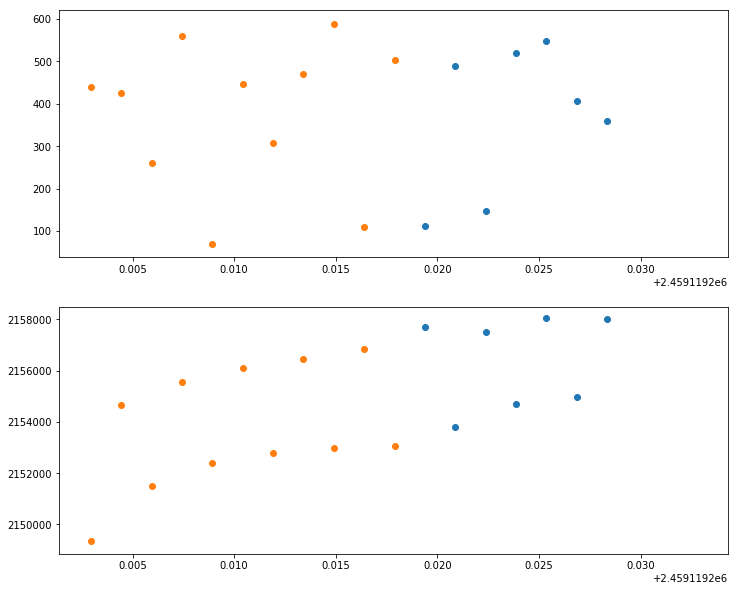

In [93]:
dir1='/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'
spec_lis=['ie93g1g0q','ie93g1g1q','ie93g1g2q','ie93g1g3q','ie93g1g4q','ie93g1g5q','ie93g1g6q']
spec_lis2=['ie93g1fnq','ie93g1fuq','ie93g1fpq','ie93g1fqq','ie93g1frq','ie93g1fsq','ie93g1ftq','ie93g1fvq','ie93g1fxq','ie93g1fyq','ie93g1fzq']
time=np.array([])
I=np.array([])
flux_tot1=[]
flux_tot2=[]
import linecache
for i in range(len(spec_lis)):
    w0,f0=np.loadtxt(dir1+spec_lis[i]+'_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
    t0=linecache.getline(dir1+spec_lis[i]+'_spec.txt',2)
    t0=t0.split()
    t0=float(t0[1])
 #   print (t0)
    time=np.append(time,t0)
    f_temp=f0[np.where(w0>1.1)[0]]
    w_temp=w0[np.where(w0>1.1)[0]]
    f_temp=f_temp[np.where(w_temp<1.2)[0]]
    w_temp=w_temp[np.where(w_temp<1.2)[0]]
    I00=simps(f_temp,w_temp)
    f_temp=f0[np.where(w0>1.15)[0]]
    w_temp=w0[np.where(w0>1.15)[0]]
    f_temp=f_temp[np.where(w_temp<1.6)[0]]
    w_temp=w_temp[np.where(w_temp<1.6)[0]]
    flux_tot1.append(simps(f_temp,w_temp))
    #print (len(w_temp))
 #   f_temp=f0[np.where(w0>1.1)[0]]
  #  w_temp=w0[np.where(w0>1.1)[0]]
  #  f_temp=f_temp[np.where(w_temp<1.2)[0]]
  #  w_temp=w_temp[np.where(w_temp<1.2)[0]]
  #  I11=simps(f_temp,w_temp)
    f_temp=f0[np.where(w0>1.5)[0]]
    w_temp=w0[np.where(w0>1.5)[0]]
    f_temp=f_temp[np.where(w_temp<1.6)[0]]
    w_temp=w_temp[np.where(w_temp<1.6)[0]]
    I01=simps(f_temp,w_temp)
    I=np.append(I,I00/I01)
fig,axs=plt.subplots(2,1,figsize=(12,10))
axs[0].scatter(time,(I-0.8925)*1e6)


I1=np.array([])
time1=np.array([])
import linecache
for i in range(len(spec_lis2)):
    w0,f0=np.loadtxt(dir1+spec_lis2[i]+'_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
    t0=linecache.getline(dir1+spec_lis2[i]+'_spec.txt',2)
    t0=t0.split()
    t0=float(t0[1])
 #   print (t0)
    time1=np.append(time1,t0)
    f_temp=f0[np.where(w0>1.1)[0]]
    w_temp=w0[np.where(w0>1.1)[0]]
    f_temp=f_temp[np.where(w_temp<1.2)[0]]
    w_temp=w_temp[np.where(w_temp<1.2)[0]]
    I00=simps(f_temp,w_temp)
    f_temp=f0[np.where(w0>1.15)[0]]
    w_temp=w0[np.where(w0>1.15)[0]]
    f_temp=f_temp[np.where(w_temp<1.6)[0]]
    w_temp=w_temp[np.where(w_temp<1.6)[0]]
    flux_tot2.append(simps(f_temp,w_temp))
    #print (len(w_temp))
 #   f_temp=f0[np.where(w0>1.1)[0]]
  #  w_temp=w0[np.where(w0>1.1)[0]]
  #  f_temp=f_temp[np.where(w_temp<1.2)[0]]
  #  w_temp=w_temp[np.where(w_temp<1.2)[0]]
  #  I11=simps(f_temp,w_temp)
    f_temp=f0[np.where(w0>1.5)[0]]
    w_temp=w0[np.where(w0>1.5)[0]]
    f_temp=f_temp[np.where(w_temp<1.6)[0]]
    w_temp=w_temp[np.where(w_temp<1.6)[0]]
    I01=simps(f_temp,w_temp)
    I1=np.append(I1,I00/I01)

axs[0].scatter(time1,(I1-0.8925)*1e6)
axs[1].scatter(time,flux_tot1)
axs[1].scatter(time1,flux_tot2)

#plt.hlines(0,min(time),max(time))
    
    

(array(['ie93g1fnq', 'ie93g1fpq', 'ie93g1fqq', 'ie93g1frq', 'ie93g1fsq',
       'ie93g1ftq', 'ie93g1fuq', 'ie93g1fvq', 'ie93g1fxq', 'ie93g1fyq',
       'ie93g1fzq', 'ie93g1g0q', 'ie93g1g1q', 'ie93g1g2q', 'ie93g1g3q',
       'ie93g1g4q', 'ie93g1g5q', 'ie93g1g6q'], dtype='|S9'), array(['reverse', 'forward', 'reverse', 'forward', 'reverse', 'forward',
       'reverse', 'forward', 'reverse', 'forward', 'reverse', 'forward',
       'reverse', 'forward', 'reverse', 'forward', 'reverse', 'forward'],
      dtype='|S9'))
[False  True False  True False  True False  True False  True False  True
 False  True False  True False  True]
[44584.72328805 44934.34818233 44953.52786953 45144.75394748
 45113.91581999 45241.89489691 45202.64368309 45320.65176503
 45246.63285664 45353.76752081 45281.72847691 45387.57465107
 45310.7421363  45399.29712446 45336.65952795 45415.95545114
 45331.23938673 45434.21953492 45386.72627416 45510.61984591
 45444.86890105 45540.99533084 45464.86586726 45567.82564468
 4549

<ErrorbarContainer object of 3 artists>

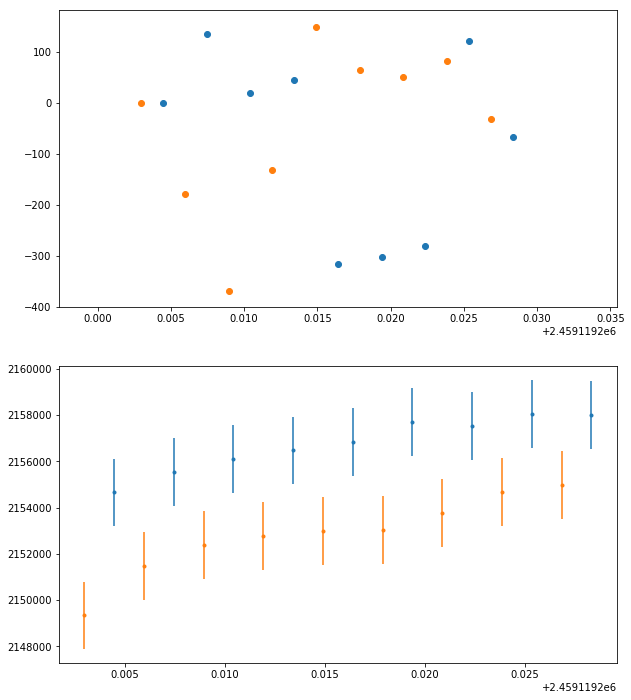

In [139]:
Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
#Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
#Binned_LC = Binned_LC / imagesize
#Binned_LC_err = Binned_LC_err / imagesize
forward[np.where(direction=='reverse')[0]]=False
print (forward)
flux_tot=np.array([])
I=np.array([])
time=np.array([])
for i in range (len(name)):
    w0,f0=np.loadtxt(dir1+name[i]+'_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
    t0=linecache.getline(dir1+name[i]+'_spec.txt',2)
    t0=t0.split()
    t0=float(t0[1])
 #   print (t0)
    time=np.append(time,t0)
    f_temp=f0[np.where(w0>1.1)[0]]
    w_temp=w0[np.where(w0>1.1)[0]]
    f_temp=f_temp[np.where(w_temp<1.2)[0]]
    w_temp=w_temp[np.where(w_temp<1.2)[0]]
#    LC, LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, w_temp, average=True, weighted=False)
#    print (LC)
    
    I00=simps(f_temp,w_temp)
    f_temp=f0[np.where(w0>1.15)[0]]
    w_temp=w0[np.where(w0>1.15)[0]]
    f_temp=f_temp[np.where(w_temp<1.6)[0]]
    w_temp=w_temp[np.where(w_temp<1.6)[0]]
    flux_tot=np.append(flux_tot,simps(f_temp,w_temp))
    #print (len(w_temp))
 #   f_temp=f0[np.where(w0>1.1)[0]]
  #  w_temp=w0[np.where(w0>1.1)[0]]
  #  f_temp=f_temp[np.where(w_temp<1.2)[0]]
  #  w_temp=w_temp[np.where(w_temp<1.2)[0]]
  #  I11=simps(f_temp,w_temp)
    f_temp=f0[np.where(w0>1.5)[0]]
    w_temp=w0[np.where(w0>1.5)[0]]
    f_temp=f_temp[np.where(w_temp<1.6)[0]]
    w_temp=w_temp[np.where(w_temp<1.6)[0]]
    I01=simps(f_temp,w_temp)
    I=np.append(I,I00/I01)
fig, axs= plt.subplots(2,1,figsize=(10,12))
axs[0].scatter(time[forward],(I[forward]-np.median(I[forward]))*1e6)
axs[0].scatter(time[~forward],(I[~forward]-np.median(I[~forward]))*1e6)
axs[1].errorbar(time[forward],flux_tot[forward],yerr=np.sqrt(flux_tot[forward]),ls='none',marker='.')
axs[1].errorbar(time[~forward],flux_tot[~forward],yerr=np.sqrt(flux_tot[~forward]),ls='none',marker='.')

In [101]:
x=np.genfromtxt(file1,usecols=(2),unpack=True)
print (x)

[2459119.20160931 2459119.20295839 2459119.20445135 2459119.20594431
 2459119.20743765 2459119.20893061 2459119.21042357 2459119.21191653
 2459119.21340987 2459119.21490283 2459119.21639579 2459119.21788876
 2459119.21938209 2459119.22087505 2459119.22236802 2459119.22386098
 2459119.22535431 2459119.22684728 2459119.22834024]


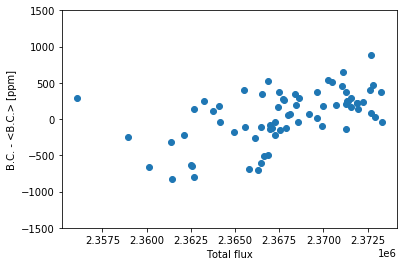

In [53]:
#np.ones(100,dtype=bool)
plt.scatter(flux_tot[inc],(I[inc]-np.mean(I[inc]))*1e6)
plt.ylim(-1500,1500)
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.ylabel('B.C. - <B.C.> [ppm]')
plt.xlabel('Total flux')
#plt.hlines(0,min(flux_tot[inc]),max(flux_tot[inc]))
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/BC_flux_correlation.pdf',format='pdf')

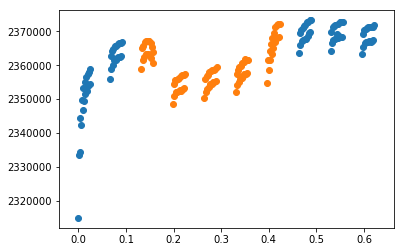

In [113]:
plt.scatter(sorted_times[inc],flux_tot[inc])
plt.scatter(sorted_times[~inc],flux_tot[~inc])

Text(0.5,0,'xshift')

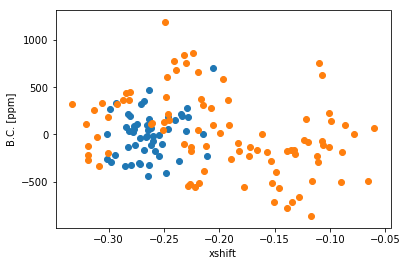

In [111]:
inc=np.ones(len(sorted_times),dtype=bool)
inc[excl_lis]=False
Exclude_first=np.ones(len(sorted_times),dtype=bool)
Exclude_first[Fir]=False
Exclude_first[Sec]=False
Exclude_first[153]=False
plt.scatter(data_xshift[inc*Exclude_first],(I[inc*Exclude_first]-np.mean(I[inc*Exclude_first]))*1e6)
plt.scatter(data_xshift[~inc*Exclude_first],(I[~inc*Exclude_first]-np.mean(I[~inc*Exclude_first]))*1e6)
plt.ylabel('B.C. [ppm]')
plt.xlabel('xshift')
#plt.savefig('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/BC_xshift_correlation.pdf',format='pdf')

In [77]:
from astropy.modeling.models import BlackBody1D
from astropy import units as u
from astropy.modeling.blackbody import FLAM
bb = BlackBody1D(temperature=5778*u.K)
wav = np.arange(1000, 110000) * u.AA
flux = bb(wav).to(FLAM, u.spectral_density(wav))
#import astropy

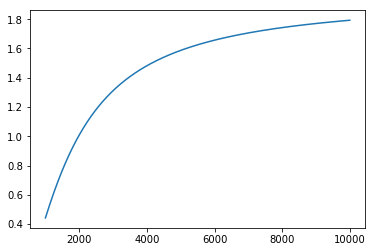

In [98]:
import matplotlib.pyplot as plt
import numpy as np

h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity
wave0=1e-6*np.arange(1.3,1.4,0.001)
wave1=1e-6*np.arange(1.55,1.65,0.001)
T=np.arange(1000,10000,1)
ratio=np.array([])
for i in range(len(T)):
    ratio=np.append(ratio,simps(planck(wave0,T[i]),wave0)/simps(planck(wave1,T[i]),wave1))
#from scipy.integrate import simps
#flux=planck(wave,2000)
#print (simps(flux,wave))
plt.plot(T,ratio)

Filename: /Users/s.baratuva.nl/Desktop/WFC3.IR.G141.1st.sens.2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     28   7751R x 3C   [E, E, E]   
[ 9950.  9951.  9952. ... 17698. 17699. 17700.]
[0. 0. 0. ... 0. 0. 0.]
1.4171911e+16
1.14413 14.670633 14.370176


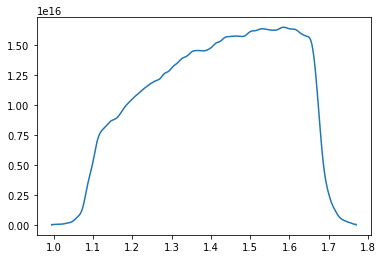

In [6]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
hdul=fits.open('/Users/s.baratuva.nl/Desktop/WFC3.IR.G141.1st.sens.2.fits')
hdul.info()
data=hdul[1].data
#print (type(data))
#wave=data[0,:]
#print (data[:][0])
hdr=hdul[1].header
#print (hdr)
#hdr['WAVELENGHTH']
#lamb=hdul[1].header['WAVELENGTH']
#sens=hdul[1].header['Sensitivity']
#plt.plot(lamb,sens)
import pandas as pd
df=pd.DataFrame(data)
df1=df.loc[:,'WAVELENGTH']
df2=df.loc[:,'SENSITIVITY']
lamb=df1.values
sens=df2.values
print (lamb)
print (sens)
#data=df.to_numpy()
#df.plot(x='WAVELENGTH',Y='SENSITIVITY')
plt.plot(lamb*1e-4,sens)
sens1=sens[np.where(lamb*1e-4>1.3)[0]]
lamb1=lamb[np.where(lamb*1e-4>1.3)[0]]
sens1=sens1[np.where(lamb1*1e-4<1.4)[0]]
lamb1=lamb1[np.where(lamb1*1e-4<1.4)[0]]
print (np.mean(sens1))

sens2=sens[np.where(lamb*1e-4>1.55)[0]]
lamb2=lamb[np.where(lamb*1e-4>1.55)[0]]
sens2=sens2[np.where(lamb2*1e-4<1.65)[0]]
lamb2=lamb2[np.where(lamb2*1e-4<1.65)[0]]
print (np.mean(sens2)/np.mean(sens1),np.log10(np.std(sens1)),np.log10(np.std(sens2)))

In [14]:
def stel_spec(filename,lamb,sens):
    w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/'+filename,skiprows=2,usecols=(0,1),unpack=True)
#print (len(w0),len(lamb))
    plt.plot(w0,f0)
    f_temp=f0[np.where(w0>1.15)[0]]
    w_temp=w0[np.where(w0>1.15)[0]]
    f_temp=f_temp[np.where(w_temp<1.6)[0]]
    w_temp=w_temp[np.where(w_temp<1.6)[0]]
    from scipy import interpolate
    f=interpolate.interp1d(lamb*1e-4,sens)
#print (w0,lamb*1e-4)
    sens_new=f(w_temp)
#plt.plot(w_temp,sens_new)
    stel_spec=f_temp/sens_new
    return w_temp,stel_spec
#plt.plot(w_temp,stel_spec)

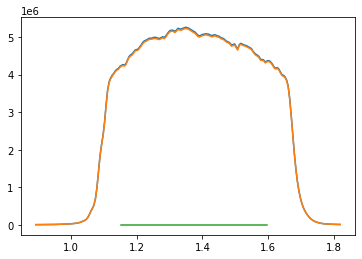

In [15]:
filename1='ie93g1g6q_spec.txt'
filename2='ie93d1eeq_spec.txt'
w,spec1=stel_spec(filename1,lamb,sens)
w,spec2=stel_spec(filename2,lamb,sens)
#c1=np.linalg.norm(spec1)
#c2=np.linalg.norm(spec2)
plt.plot(w,spec1)
#plt.plot(w,spec2)


Filename: /Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/lte05000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (1569128,)   float32   
  1  ABUNDANCES    1 BinTableHDU     15   83R x 3C   [I, 2A, E]   
(1569128, 1569128)


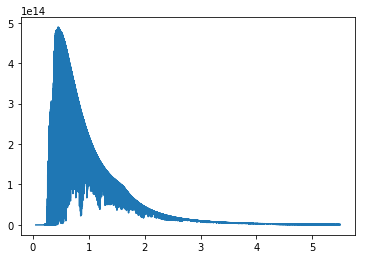

In [114]:
file_model='/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/lte05000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'

from astropy.io import fits
hdul=fits.open(file_model)
hdul.info()
model=hdul[0].data
#print (type(data))
#wave=data[0,:]
#print (data[:][0])
hdr=hdul[0].header
#print (hdr)


hdul1=fits.open('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
#print (hdul1[0].header)

wave=hdul1[0].data

print (len(model),len(wave))

plt.plot(wave*1e-4,model)


96


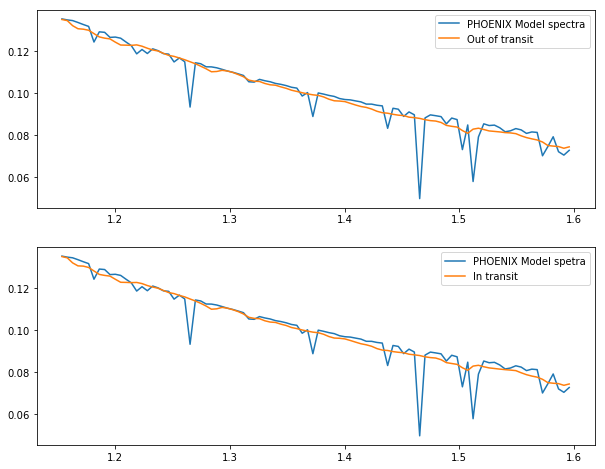

In [116]:
f=interpolate.interp1d(wave*1e-4,model)
rebinned_model=f(w)
c3=np.linalg.norm(rebinned_model)
fig,axs=plt.subplots(2,1,figsize=(10,8))
axs[0].plot(w,rebinned_model/c3,label='PHOENIX Model spectra')
axs[0].plot(w,spec1/c1,label='Out of transit')
axs[1].plot(w,rebinned_model/c3,label='PHOENIX Model spetra')
axs[1].plot(w,spec2/c2,label='In transit')
axs[0].legend()
axs[1].legend()
print (len(w))

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity
wave0=1e-6*np.arange(1.3,1.4,0.001)
wave1=1e-6*np.arange(1.55,1.65,0.001)




def Ratio(T,r,wave0,wave1):
    r1=simps(planck(wave0,T),wave0)
    r2=simps(planck(wave1,T),wave1)
    rat=(r1/r2)-r
    return rat

r=1.19*1.14413
print (I)
x=scipy.optimize.bisect(Ratio,1000,5500,args=(r,wave0,wave1))
print (x)
#r=I[inc]
Temperature=np.array([])
#for i in range(len(r)):
#    print (r[i])
#    x=scipy.optimize.bisect(Ratio,3000,7000,args=(r[i],wave0,wave1))
#    Temperature=np.append(Temperature,x)
#    print (x)



[1.20215563 1.20068462 1.19969884 1.20002677 1.19981208 1.19954852
 1.1991714  1.19926938 1.1985525  1.19929623 1.19831515 1.19895646
 1.19827397 1.19867253 1.19838652 1.19864734 1.19858434 1.19857991
 1.19920643 1.1990559  1.1986658  1.19887416 1.19824363 1.19872845
 1.198084   1.1988001  1.19859933 1.19822136 1.19869375 1.1982132
 1.19827333 1.19840276 1.19826466 1.19830821 1.19810706 1.19842092
 1.1985018  1.19858187 1.19822519 1.19829154 1.1980609  1.19911403
 1.19813174 1.19898444 1.19814762 1.19829497 1.19852186 1.19827423
 1.19817061 1.19845531 1.1978502  1.19835909 1.19786214 1.19842213
 1.19778855 1.19817709 1.19764384 1.19807066 1.19796158 1.1975818
 1.19816969 1.19835864 1.19763727 1.1981307  1.19784209 1.1981931
 1.19768831 1.19818785 1.198188   1.19786382 1.19748905 1.19824951
 1.19837232 1.19845816 1.19779913 1.19863746 1.19783296 1.19818541
 1.19784127 1.19797006 1.19825173 1.19840326 1.19781214 1.19822072
 1.19810077 1.1982375  1.19826661 1.1982272  1.19780491 1.1981849

In [46]:
np.where(lamb*1e-4>1.3)[0]

array([3051, 3052, 3053, ..., 7748, 7749, 7750])

In [48]:
:

SyntaxError: unexpected EOF while parsing (<ipython-input-48-f996a80207d6>, line 1)

In [109]:
def func(x,a):
    f=x**2-x**3+a
    return f
print (scipy.optimize.bisect(func,0.5,10,args=(0.0)))

1.0


(array([1.26609427e+11, 1.26663945e+11, 1.26718038e+11, 1.26771707e+11,
       1.26824952e+11, 1.26877774e+11, 1.26930174e+11, 1.26982153e+11,
       1.27033711e+11, 1.27084849e+11, 1.27135568e+11, 1.27185869e+11,
       1.27235752e+11, 1.27285219e+11, 1.27334270e+11, 1.27382906e+11,
       1.27431128e+11, 1.27478936e+11, 1.27526332e+11, 1.27573316e+11,
       1.27619888e+11, 1.27666051e+11, 1.27711804e+11, 1.27757148e+11,
       1.27802085e+11, 1.27846615e+11, 1.27890738e+11, 1.27934456e+11,
       1.27977770e+11, 1.28020680e+11, 1.28063187e+11, 1.28105291e+11,
       1.28146995e+11, 1.28188298e+11, 1.28229201e+11, 1.28269706e+11,
       1.28309813e+11, 1.28349522e+11, 1.28388835e+11, 1.28427753e+11,
       1.28466276e+11, 1.28504405e+11, 1.28542141e+11, 1.28579485e+11,
       1.28616438e+11, 1.28653000e+11, 1.28689173e+11, 1.28724957e+11,
       1.28760352e+11, 1.28795361e+11, 1.28829983e+11, 1.28864220e+11,
       1.28898072e+11, 1.28931541e+11, 1.28964626e+11, 1.28997330e+11,
     

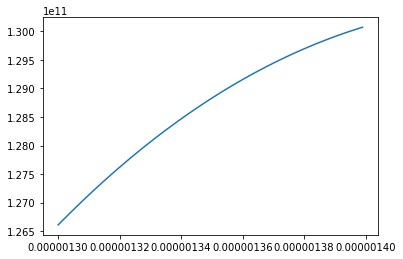

In [84]:
plt.plot(wave,flux)
print (flux,wave)

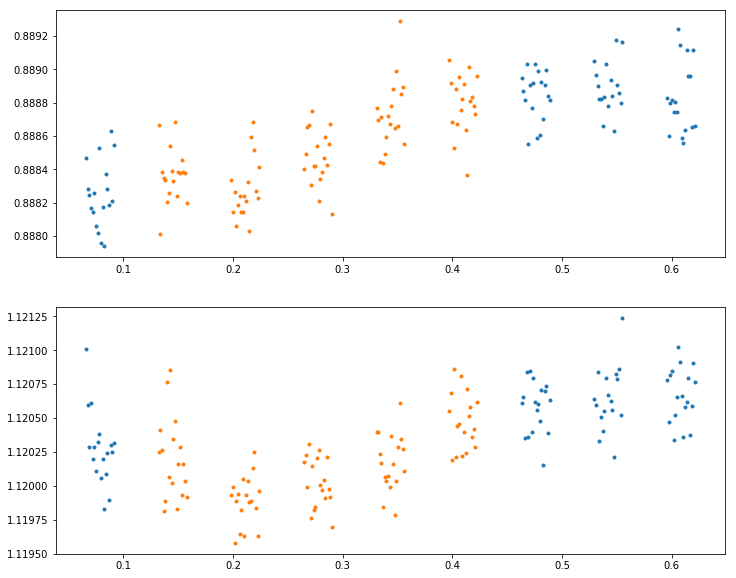

In [9]:
w0,f0=np.loadtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/ie93a1c8q_spec.txt',skiprows=2,usecols=(0,1),unpack=True)
wave_bin0=w0[(w0>1.1) & (w0<1.2)]
#print (wave_bin)
wave_bin1=w0[(w0>1.5) & (w0<1.6)]
wave_bin2=w0[(w0>1.3) & (w0<1.4)]
Exclude_first=np.ones(len(sorted_times),dtype=bool)
Exclude_first[Fir]=False
Exclude_first[153]=False
#Exclude_first[For]=False
#lis1=[139,140,141,142,143]
#lis1=lis1+18
#Exclude_first[lis1]=False
#Exclude_first[Sev]=False
#Exclude_first[Sec]=False
#Exclude_first[Sec]=False
excl_lis=[]
#excl_lis.extend(Fir)
excl_lis.extend(For)
excl_lis.extend(Fif)
excl_lis.extend(Six)
excl_lis.extend(Sev)
excl_lis.extend(Thi)
#excl_lis.extend(Sec)
#excl_lis.append(153)
filelist_temp=np.array(sorted(filelist))
#print (np.array(filelist2)[inc],filelist[inc])
#filelist2=sorted(filelist[inc])
#print (filelist2[inc])

inc=np.ones(len(sorted_times),dtype=bool)
inc[excl_lis]=False
LC1, LC_err1 = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin0, average=True, weighted=False)
LC2, LC_err2 = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin1, average=True, weighted=False)
LC3, LC_err3 = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin2, average=True, weighted=False)
fig, axs= plt.subplots(2,1,figsize=(12,10))
axs[0].plot(sorted_times[inc*Exclude_first],LC1[inc*Exclude_first]/LC2[inc*Exclude_first],ls='none',marker='.')
axs[0].plot(sorted_times[~inc*Exclude_first],LC1[~inc*Exclude_first]/LC2[~inc*Exclude_first],ls='none',marker='.')
axs[1].plot(sorted_times[inc*Exclude_first],LC3[inc*Exclude_first]/LC2[inc*Exclude_first],ls='none',marker='.')
axs[1].plot(sorted_times[~inc*Exclude_first],LC3[~inc*Exclude_first]/LC2[~inc*Exclude_first],ls='none',marker='.')

<ErrorbarContainer object of 3 artists>

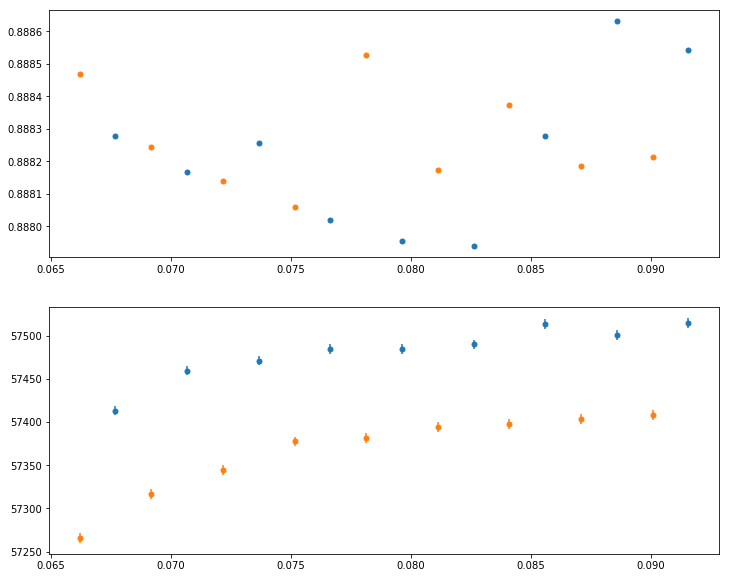

In [45]:
Exclude_first=np.ones(len(sorted_times),dtype=bool)
Exclude_first[Sec]=False
forward=np.ones(len(For),dtype=bool)
fname,direction=np.genfromtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/Data/visit_c1.lis',usecols=(0,3),skip_header=1,dtype=str,unpack=True)
forward[np.where(direction=='reverse')[0]]=False
fig,axs=plt.subplots(2,1,figsize=(12,10))
axs[0].plot(sorted_times[~Exclude_first][forward],LC1[~Exclude_first][forward]/LC2[~Exclude_first][forward],ls='none',marker='.',ms=10)
axs[0].plot(sorted_times[~Exclude_first][~forward],LC1[~Exclude_first][~forward]/LC2[~Exclude_first][~forward],ls='none',marker='.',ms=10)
wave_bin4=w0[(w0>1.12) & (w0<1.65)]
LC4, LC_err4 = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin2, average=True, weighted=False)
axs[1].errorbar(sorted_times[~Exclude_first][forward],LC4[~Exclude_first][forward],yerr=LC_err4[~Exclude_first][forward],ls='none',marker='.',ms=10)
axs[1].errorbar(sorted_times[~Exclude_first][~forward],LC4[~Exclude_first][~forward],yerr=LC_err4[~Exclude_first][~forward],ls='none',marker='.',ms=10)




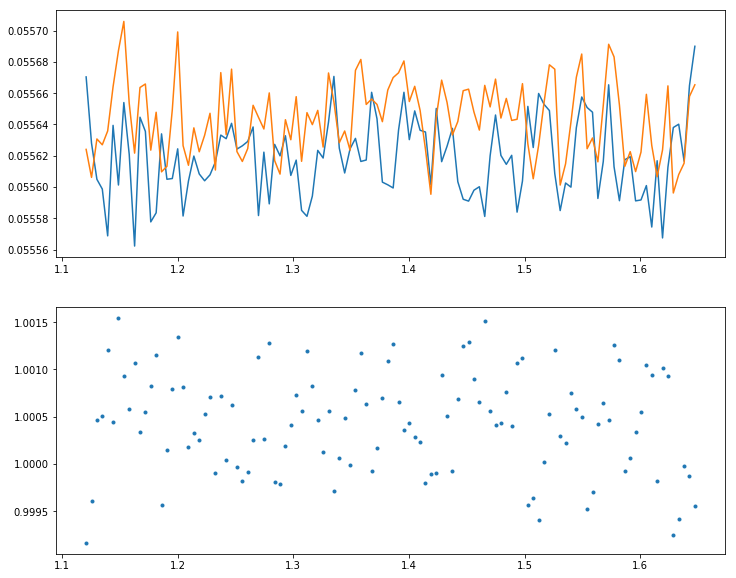

In [40]:
Nr_pixels = 1
bins = []
i = 0
w1=1.12
w2=1.65
WL_waves = w0[(w0 > w1) & (w0 < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_wave_avg = [np.mean(bin) for bin in bins]
Lightcurve=[]
for i in range (len(bins)):
    LC,LC_err=fit_fns.calc_WL(df_sorted, df_sorted_err, bins[i], average=True, weighted=False)
    Lightcurve.append(LC)
exp1=33
exp0=177
exp3=141
spec=np.array([])
spec2=np.array([])
spec3=np.array([])
for i in range(len(bins_wave_avg)):
#    spec=np.append(spec,Lightcurve[i][exp1]/sum(Lightcurve[i][Sec]))
    spec2=np.append(spec2,Lightcurve[i][exp0]/sum(Lightcurve[i][Ten]))
    spec3=np.append(spec3,Lightcurve[i][exp3]/sum(Lightcurve[i][Nin]))
fig,axs=plt.subplots(2,1,figsize=(12,10))
#axs[1].plot(bins_wave_avg,spec/spec2,ls='none',marker='.')
axs[1].plot(bins_wave_avg,spec3/spec2,ls='none',marker='.')
#axs[0].plot(bins_wave_avg,spec)
axs[0].plot(bins_wave_avg,spec2)
axs[0].plot(bins_wave_avg,spec3)


In [96]:
import numpy as np
x,y,z=np.genfromtxt('/Users/s.baratuva.nl/Desktop/PhD/hst_data_analysis/v1298_taub/output/v1298_emcee_spectra.rtf',skip_header=2,unpack=True)

ValueError: Some errors were detected !
    Line #8 (got 2 columns instead of 1)
    Line #12 (got 4 columns instead of 1)
    Line #13 (got 5 columns instead of 1)

In [17]:
import platon

ImportError: No module named platon